### Данные

Получены данные по домам в Нижегородской области, парсингом сайта Циан в апреле 2022 года.

##### Основная идея:

Определить справедливую стоимость домов в Нижегородской области.

<img src="kottedzh.jpg"  style="max-height: 500px; max-width: 500px;">

Версия на русском языке, но дорабатываю на английском.

- **Главное** - общая информация из внешних карточек объявлений на сайте.
- **Время_разм** -  время последнего обновления объявления.
- **Цена_внеш** - цена указанная во внешней карточке объявления.
- **Ссылка** - ссылка на внутреннюю каточку объявления.
- **Общая пл** - основные данные по площади, и конструкции дома.
- **Описание** - подробное описание дома.
- **Общ инф** - дополнительные сведения, основные коммуникации, год постройки и т.п.
- **Адрес** - адрес указанный в объявлении.
- **Цена за М2** - цена за квадратный метр, вместе с участком.
- **Цена** - цена во внутреннней карточке объявления. Теоритически основная и должна совпадать с внешней карточкой.
- **Просмотры** - просмотры объявления.
- **Тариф** - тариф по которому размещено объявление. 

### Содержание
1. [Обработка сырых данных полученных парсингом.](#sec1)
    * [1.2 Проверка признаков](#sec1.2) 
2. [Feature engineering](#sec2)  
    * [2.1 Работа с адресом и получение долготы и широты](#sec2.1)
    * [2.2 Данные из википедии по количеству населения в районах.](#sec2.2)
    * [2.3 Новые признаки.](#sec2.3)
    * [2.4 Обработка данных по участкам (выкачанных отдельно с сайта).](#sec2.4)
3. [Обработка выбросов в данных](#sec3)
    * [3.2 Удаление данных узкой категории, которые вносят выбросы](#sec3.1)
4. [Обработка пропущенных значений](#sec4)
5. [EDA - Разведочный анализ данных](#sec5)
    * [5.2 Data visualization](#sec5.2)
    * [5.3 Ключевой признак: Состояние дома.](#sec5.3)
    * [5.4 Time data.](#sec5.4)
6. [Финальная чистка выбросов, для улучшения модели.](#sec6)
7. [Трансформация целевого признака.](#sec7)
8. [Feature selection.](#sec8)
9. [Correlation.](#sec9)
10. [Modeling.](#sec10)
11. [Выводы:](#sec11)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import re,string,timeit
from pprint import pprint
from geopy.geocoders import Nominatim
from math import radians, cos, sin, asin, sqrt

In [2]:
import mymodule

In [3]:
from mymodule import \
read, search, search_house_type, search_year, search_general, search_general_2, search_partition,\
geo, geo_ind, geo_ind_2, geo_2, geo_fillna

### Соединение данных полученных парсингом.

In [4]:
df = read('0_0.9')
df2 = read('0.9_2')
df3 = read('2_5')
df4 = read('5_14')
df5 = read('14_')

df_conc = pd.concat([df, df2, df3, df4, df5], axis=0)
# Удаляю дубликаты, и перемешиваю рандомно данные
df_conc = df_conc.drop_duplicates(subset=['Ссылка'])
df = df_conc.sample(len(df_conc), random_state=101, ).reset_index(drop=True).to_csv('df_cian_house.csv', index=False)

In [5]:
df = pd.read_csv('df_cian_house.csv')
df[:2]

Главное  \
0  Дом, 50 м², 6 сот., ИЖСНижегородская область,Г...   
1  Дом, 100 м², 47 сот.Только на ЦианНижегородска...   

                    Время_разм    Цена_внеш  \
0  9 часов назадсегодня, 08:53    600 000 ₽   
1   полгода назад30 сен, 12:21  1 700 000 ₽   

                                        Ссылка  \
0  https://nn.cian.ru/sale/suburban/263648098/   
1  https://nn.cian.ru/sale/suburban/264700816/   

                                            Общая пл  \
0  50 м²Общая6.0 сот.УчастокКирпичныйТип дома1Эта...   
1  100 м²Общая47.0 сот.УчастокКирпичныйТип дома1Э...   

                                            Описание  \
0  Продам земельный участок г. Заволжье, посёлок ...   
1  Продам дом. Электрическое отопление. В трех ко...   

                                             Общ инф  \
0  Общая информацияСтатус участкаИндивидуальное ж...   
1  Общая информацияОтоплениеСанузел в домеСтатус ...   

                                               Адрес   Цена за М2  \
0  Нижегородская область, Городецкий район, Перво...  12 000 ₽/м²   
1  Нижегородская область, Сеченовский район, Ясно...  17 000 ₽/м²   

          Цена                     Просмотры    Тариф  
0    600 000 ₽  275 просмотров, 3 за сегодня  Платное  
1  1 700 000 ₽  207 просмотров, 1 за сегодня      NaN

#### Гипотезы

- Цена внешней карточки и внутренней карточки домов на сайте могут расходиться.
- Взаимосвязь районы и цены. Чем дороже, тем ближе к центру.
- Взаимосвязь просмотры и цены. Чем дешевле, тем больше просмотров.
- Взаимосвязь кол-во населения в районе и кол-во продаж. Чем больше населения, тем ближе к центру и дороже.
- Пропорции участка и дома. К большим домам большие участки.

Могут портить всю картину:
- Ветхие дома, которые ничего не стоят. Продаются по цене участка.
- Дорогие дома, особенно в центре под коммерцию.

- Желание людей, купить поближе к воде дома. Реки, озера и т.д. Или лесам, заповедникам.
- Инфраструктура может влиять на цену продажи. Вопрос как эти данные собрать.

<a id="sec1"></a>
### [1. Обработка сырых данных полученных парсингом.](#sec1)

##### Общая площадь в м2

In [6]:
df['ПлощадьДома'] = df['Общая пл'].str.partition('Общая')[0].str[0:-3] # Методом разбиения строки и обычными срезами

m2 = (df['Общая пл'].str.partition('Общая')[0].str[-3:]) # Проверка
print(pd.DataFrame({'':m2.value_counts()}),'\n')
# Каким то образом в базу домов попали участки без домов. Удаляю эти позиции.
df = df.drop(index=[3736, 4991]).reset_index(drop=True)

print('Вычищаю проблемные остатки:','\n', '\n', pd.DataFrame(df.ПлощадьДома.sort_values()).head(1),'\n')
df['ПлощадьДома'].iloc[3007] = df.ПлощадьДома.iloc[3007][-5:]

print(pd.DataFrame(df.ПлощадьДома.sort_values()).tail(23))
df['ПлощадьДома'].iloc[
    [910, 4923, 3563, 2251, 3624, 2821, 1224, 3430, 3021]] = df.ПлощадьДома.iloc[
    [910, 4923, 3563, 2251, 3624, 2821, 1224, 3430, 3021]].str[-2:]
df['ПлощадьДома'].iloc[
    [2946, 3972, 1551, 1146, 4362, 3813, 3406, 204, 4716, 3073, 4843, 4231, 581, 4786]] = df.ПлощадьДома.iloc[
    [2946, 3972, 1551, 1146, 4362, 3813, 3406, 204, 4716, 3073, 4843, 4231, 581, 4786]].str[-3:]

df['ПлощадьДома'] = df.ПлощадьДома.str.replace(' ', '')
# Сохраняю запятую для дробных чисел
df['ПлощадьДома'] = df.ПлощадьДома.str.split(',').str[0] + '.' + df.ПлощадьДома.str.split(',').str[1].fillna('0')
df['ПлощадьДома'] = df.ПлощадьДома.astype('float64')

         
 м²  5013
мли     2 

Вычищаю проблемные остатки: 
 
                                  ПлощадьДома
3007  .Дом 100,3 м2 на участке 21 сотка100,3 

                               ПлощадьДома
2946       Дом 100мет на уч.7,5 сот ИЖС100
3972                Дом 165м2 из бревна165
910       Дом 80м. на участке 7,5сот ИЖС80
4923              Дом в Нижнем Новгороде98
1551       Дом дер.Пруды. Общ 112 кв.м.112
3563   Дом и участок в центре Лукьянович35
1146            Дом мечты, живой уютный250
4362                Дом на Красной Этне147
2251   Жилой дом 45 мин. до Н. Новгорода50
3813                   Коттедж  в Ройке101
3406  Коттедж (300 кв.м.) Богородский р300
204            Коттедж, 200 м², 20 сот.200
3624               ЛУЧШИЙ дом по району!60
4716   Продается  дом, 128 кв.м., /2 эт128
581    Продается  дом, 530 кв.м., /2 эт530
4786   Продается  дом, 900 кв.м., /3 эт900
2821    Продам дом на участке 15.5 соток45
3073                         Продам дом122
1224                   Прод

##### Участок в сотках

In [7]:
# У нас есть значения в ГА, которые нужно перевести в СОТки. 
df['УчастокГа'] = df['Общая пл'].str.partition('Общая')[2].str.partition('га')[1]
df['УчастокСот'] = df['Общая пл'].str.partition('Общая')[2].str.partition('сот')[1] 
df['Участок'] = df['Общая пл'].str.partition('Общая')[2].str.partition(' сот.Участок')[0].str.partition(' гаУчасток')[0]

print(pd.DataFrame(df.Участок.sort_values()).head(1),'\n')
print(pd.DataFrame(df.Участок.sort_values()).tail(2),'\n')

df.loc[[2945], 'Участок'] = '10'
df = df.drop(index=[3513, 1992, 3772]).reset_index(drop=True) # Мало инфо по домам, удаляю 

df['Участок'] = df.Участок.astype('float64')
 
for ind, land in enumerate(df['УчастокГа']):
    if land == 'га':
        df.loc[[ind], 'Участок'] = df.loc[[ind], 'Участок'] * 100
        
print(pd.DataFrame(df.УчастокСот.value_counts()),'\n')
print('Здесь сидит 1 шт., которую вручную проставил значение:','\n', '\n', pd.DataFrame(df['УчастокГа'].value_counts()))

     Участок
3513         

                               Участок
1992  ДеревянныйТип дома1Этажей в доме
3772                 КирпичныйТип дома 

     УчастокСот
сот        4958
             52 

Здесь сидит 1 шт., которую вручную проставил значение: 
 
     УчастокГа
         4959
га         51


##### Тип дома

In [8]:
df['ТипДома'] = df['Общая пл'].str.partition('Тип дома')[0].str.partition('Участок')[2].str.partition(
    '1Этажей')[0].str.partition('2Этажей')[0].str.partition('3Этажей')[0].str.partition('4Этажей')[0].str.strip()

df['ТипДома'] = df.ТипДома.replace('', 'Неизвестно')
print(pd.DataFrame(df.ТипДома.sort_values()).head(5),'\n')
print(pd.DataFrame(df.ТипДома.sort_values()).tail(1),'\n')

df.loc[3020, 'ТипДома'] = 'Кирпичный'
df.loc[[3346, 4989, 1907, 4819, 1002, 2169], 'ТипДома'] = 'Неизвестно'
print(pd.DataFrame({'Тип дома %': round(df.ТипДома.value_counts(normalize=True),3)})*100)

           ТипДома
3346  1965Построен
4989  1966Построен
1907  2010Построен
4819  2018Построен
1002  2022Построен 

                                                ТипДома
3020  с домом в центре Дивеево40 м²Общая5.0 сот.Учас... 

                     Тип дома %
Деревянный                 37.1
Кирпичный                  32.6
Неизвестно                 19.4
Газосиликатный блок         2.5
Каркасный                   2.3
Газобетонный блок           1.6
Блочный                     1.2
Пенобетонный блок           1.2
Щитовой                     0.8
Монолитный                  0.7
Монолитно-кирпичный         0.4
Панельный                   0.3


In [9]:
data = df[df['ТипДома']=='Неизвестно']
# Используя регулярные выражения, определяю, какой еще может быть тип дома
description = []
for i in data['Описание']:
    i = i.translate(str.maketrans('', '', string.punctuation))
    res = i.split()
    try:
        res = ' '.join(res[res.index('построен')-1:])
    except:
        res = 'NaN'
    description.append(res)
    
description = pd.Series(description)
description[description!='NaN']

2      Коттедж построен по последним современным техн...
39     Дом построен из кирпича утеплен керамзитом вып...
49     этажный построен из красного качественного кир...
51     районе построен на продажу под чистовую отделк...
68     дом построен с возможностью возвести дровяной ...
                             ...                        
921    светлый построен из качественных стройматериал...
930    Дом построен на совесть Материал стен кирпич с...
934    Дом построен под ключ готов к эксплуатации Фун...
951    этажный построен из красного качественного кир...
963    будет построен летом 2022 года Дом будет постр...
Length: 68, dtype: object

##### Пересчет типа домов по описанию

In [10]:
%%time

lst = {'upper':
       ['Деревянный', 'Кирпичный', 'Газосиликатный блок','Каркасный', 'Газобетонный блок','Блочный','Пенобетонный блок',
        'Бревенчатый','Щитовой','Монолитный', 'Газосиликатных блоков', 'Монолитно-кирпичный', 'Панельный','Каркасный',
        'Бруса','Брус','Бревна','Бревно','Силикатного кирпича', 'Сруб','Индивидуальному проекту','Индивидуальный проект',
        'Красного кирпича','Красный кирпич','Газосиликатного блока','Каркасной технологии','Каркасная','Каркасной',
        'Блочный','Газоблоков','Газоблок','Щитовой','Газосиликата','Газосиликат','Сруба','Керамического кирпича',
        'Керамический кирпич','Брёвна', 'Панелей','Пенобетонных блоков','Белого кирпича',
        'Белый кирпич','Специальному проекту','Специальный проект','Газоблок', 'Дом из кирпича']}

words = pd.DataFrame(lst)
words['lower'] = words['upper'].str.lower()
df['ТипДома'] = search_house_type(words.lower.copy(), df.Описание.copy(), df.ТипДома.copy())
df['ТипДома'] = search_house_type(words.upper.copy(), df.Описание.copy(), df.ТипДома.copy())

df['ТипДома'] = df.ТипДома.replace(
    {'Кирпичный, кирпичный':'Кирпичный', 'Деревянный, деревянный':'Деревянный','Панелей':'Панельный',
     'Газосиликатных блоков':'Газосиликатный блок','Бруса': 'Брус','Бревна':'Бревенчатый','Сруба':'Бревенчатый', 
     'Силикатного кирпича': 'Кирпичный', 'Сруб':'Бревенчатый','Индивидуальному проекту': 'Индивидуальный проект', 
     'Красного кирпича':'Кирпичный','Газосиликатного блока':'Газосиликатный блок', 'Каркасной технологии':'Каркасный',
     'Газоблоков': 'Газосиликатный блок','Газосиликатных блоков, газосиликатных блоков':'Газосиликатный блок', 
     'Сруб, сруб':'Бревенчатый', 'Газосиликата':'Газосиликатный блок', 'Сруба':'Бревенчатый','Бруса, бруса':'Брус',
     'Керамического кирпича':'Кирпичный','Газосиликатный блок, газосиликатный блок':'Газосиликатный блок', 
     'Брёвна':'Бревенчатый','Пенобетонных блоков':'Пенобетонный блок', 'Бревна, бревна':'Бревенчатый', 
     'Белого кирпича':'Кирпичный', 'Специальному проекту':'Индивидуальный проект', 'Газоблок':'Газосиликатный блок',
     'Дом из кирпича':'Кирпичный','Деревянный, деревянный':'Деревянный', 'Газосиликат':'Газосиликатный блок',
     'Красный кирпич': 'Кирпичный','Бревно, бревно':'Бревенчатый', 'Каркасная':'Каркасный', 'Белый кирпич': 'Кирпичный',
     'Бревно':'Бревенчатый', 'Nan':'NaN'})

print(pd.DataFrame({'Тип дома %': round(df.ТипДома.value_counts(normalize=True),3)*100}),'\n')

                       Тип дома %
Деревянный                   38.1
Кирпичный                    35.2
Неизвестно                   11.4
Газосиликатный блок           3.7
Каркасный                     2.7
Бревенчатый                   1.8
Газобетонный блок             1.6
Блочный                       1.3
Пенобетонный блок             1.2
Монолитный                    0.8
Щитовой                       0.8
Панельный                     0.4
Брус                          0.4
Монолитно-кирпичный           0.4
Индивидуальный проект         0.2
Керамический кирпич           0.1 

Wall time: 8.04 s


##### Этажи

In [11]:
df['Этажи'] = df['Общая пл'].str.partition('Этажей в доме')[0].str[-1:]

print(pd.DataFrame(df.Этажи.value_counts()),'\n')
df['Этажи'] = df.Этажи.replace({'к':'NaN', 'а':'NaN','н':'NaN','я': 'NaN', '8': 'NaN', '0': 'NaN'})
print(pd.DataFrame({'Этажи %': round(df.Этажи.value_counts(normalize=True),4)*100}),'\n')
df['Этажи'] = df.Этажи.astype('float64')

   Этажи
1   2247
2   2078
3    309
к    193
а    105
н     40
4     35
8      1
0      1
5      1 

     Этажи %
1      44.85
2      41.48
NaN     6.79
3       6.17
4       0.70
5       0.02 



##### Год постройки

In [12]:
df['Год'] = df['Общая пл'].str.partition('Построен')[0].str[-4:]

df['Год'] = df.Год.apply(lambda x: ' '.join(re.findall(r'\d+', x))).replace('', '0')
print(pd.DataFrame({'Год %': round(df.Год.value_counts(normalize=True).head(1),3)*100}))

   Год %
0   57.9


In [13]:
data = df[df['Год']=='0']
# Используя регулярные выражения, определяю, как выцепить год
description = []
for i in data['Описание']:
    i = i.translate(str.maketrans('', '', string.punctuation))
    res = i.split()
    try:
        res = ' '.join(res[res.index('постройки')-3:])
    except:
        res = '0'
    description.append(res)
    
description = pd.Series(description)
description[description!='0']

23      фруктовые деревьяпосадки дворовые постройки ба...
49      и чуланом холодные постройки наверное 63 5 В д...
56      посадки деревьев дворовые постройки Ворота мет...
57      дом 1980 года постройки в том году сделали при...
69      дом 2019 года постройки на ул Харенка 2этажный...
                              ...                        
2850    кирпичный 2009 года постройки 2 этажный 278 кв...
2863    коттедж 2015 года постройки д Карабатово ул Со...
2883    квм 2014 года постройки часть одноэтажного дер...
2898    коттедж 2008 года постройки в пос Высоково Сор...
2902    дома отличное год постройки 1990 г печное отоп...
Length: 233, dtype: object

##### Пересчет годов по описанию

In [14]:
year = [] # Прогоняю сначала по списку со словом года для большей точности
for i in np.arange(1850, 2025):
    i = str(i) + ' ' + 'года'
    year.append(i)
df['Год'] = search_year(year.copy(), df.Описание.copy(), df.Год.copy())
        
year2 = [] # И просто по всем годам, что есть
for i in np.arange(1850, 2025):
    year2.append(i) 
df['Год'] = search_year(year2.copy(), df.Описание.copy(), df.Год.copy())
            
df['Год'] = df.Год.str.split().str[0].str[0:4]
df['Год'] = df.Год.astype('float64')
print(pd.DataFrame({'Год %': round(df.Год.value_counts(normalize=True).head(1),3)*100}))

100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:25<00:00,  6.74it/s]

     Год %
0.0   52.9


##### С годами постройки домов определенно возникает сложность. 
- Половины данных нет. 
- Плюс, часто отсутствуют номера домов в объявлениях, что не дает возмодность найти в источниках интернета.

- Можно было бы выкачать данные и проверить по базе данного сайта https://dom.mingkh.ru/nizhegorodskaya-oblast/ 
- Но и тут дома находятся в очень в редких случаях. 

- Гораздо эффективнее в этом плане работать по квартирам.

##### Общая информация

- Прохожусь в две части. Первая, парсим общую информацию str.partition. И вторая часть, что неизвестно ищу в описании.
- Теоритически, что не нахожу, считаю в доме нет.

In [15]:
df.rename(columns={'Общ инф': 'Общ_инф'}, inplace=True)

df['Отопление'] = ''
df['Отопление'] = search_general(df.Описание.copy(), df.Отопление, df.Общ_инф.copy())

df['Электричество'] = ''
df['Электричество'] = search_general(df.Описание.copy(), df.Электричество, df.Общ_инф.copy())

df['Газ'] = ''
df['Газ'] = search_general(df.Описание.copy(), df.Газ, df.Общ_инф.copy())

df['Баня'] = ''
df['Баня'] = search_general(df.Описание.copy(), df.Баня, df.Общ_инф.copy())

df['Водоснабжение'] = ''
df['Водоснабжение'] = search_general(df.Описание.copy(), df.Водоснабжение, df.Общ_инф.copy())

df['Канализация'] = ''
df['Канализация'] = search_general(df.Описание.copy(), df.Канализация, df.Общ_инф.copy())

df['Гараж'] = ''
df['Гараж'] = search_general(df.Описание.copy(), df.Гараж, df.Общ_инф.copy())

df['Охрана'] = ''
df['Охрана'] = search_general(df.Описание.copy(), df.Охрана, df.Общ_инф.copy())

df['Бассейн'] = ''
df['Бассейн'] = search_general(df.Описание.copy(), df.Бассейн, df.Общ_инф.copy())

      Отопление %
есть                 63.2
нет                  36.8 

      Электричество %
есть                     79.9
нет                      20.1 

      Газ %
есть           62.3
нет            37.7 

      Баня %
нет             59.1
есть            40.9 

      Водоснабжение %
есть                     59.3
нет                      40.7 

      Канализация %
есть                   50.1
нет                    49.9 

      Гараж %
нет              70.5
есть             29.5 

      Охрана %
нет               94.4
есть               5.6 

      Бассейн %
нет                95.2
есть                4.8 



In [16]:
lst = ['Санузел в доме',
       'санузел в доме', 
       'Туалет на улице', 
       'туалет на улице',
       'Туалет во дворе',
       'Туалет во дворе', 
       'Туалет в доме', 
       'туалет в доме',
       'Уличный туалет',
       'уличный туалет', 
       'Туалет','туалет', 
       'Санузел','санузел']
df['Санузел'] = df.Общ_инф.str.partition('Санузел на улице')[1] + df.Общ_инф.str.partition('Санузел в доме')[1]
df['Санузел'] = search_general_2(df.Описание.copy(), df.Санузел.copy(), lst)     
df['Санузел'] = df.Санузел.replace(
    {'':'нет', 
     'Санузел':'Санузел в доме', 
     'Туалет':'Санузел в доме', 
     'санузел, санузел':'Санузел в доме',
     'Туалет на улице':'Санузел на улице', 
     'Туалет в доме':'Санузел в доме', 
     'Уличный туалет':'Санузел на улице',
     'Санузел, санузел, санузел':'Санузел в доме',
     'Туалет во дворе':'Санузел на улице',
     'Туалет, туалет':'Санузел в доме',
     'Санузел, санузел':'Санузел в доме'})
print(pd.DataFrame({'\033[4m' + 'Санузел' + ' '+'%'+'\033[0m': round(df.Санузел.value_counts(normalize=True),3)*100}),'\n')

###########################################################################################################################

df['СтатусУчастка'] = ''
lst = ['Индивидуальное жилищное строительство', 
       'Личное подсобное хозяйство', 
       'Садоводство', 
       'Фермерское хозяйство', 
      'Дачное некоммерческое партнерство', 
       'Земля промышленного назначения']
df['СтатусУчастка'] = search_partition(df.СтатусУчастка.copy(), df.Общ_инф.copy(), lst)          
lst = ['ИЖС',
       'ЛПХ', 
       'СНТ']
df['СтатусУчастка'] = search_general_2(df.Описание.copy(), df.СтатусУчастка.copy(), lst)
df['СтатусУчастка'] = df.СтатусУчастка.replace(
    {'':'Неизвестно', 
     'Ижс':'Индивидуальное жилищное строительство', 
     'Лпх':'Личное подсобное хозяйство', 
     'Снт' : 'Садоводство',
     'Дачное некоммерческое партнерство':'Садоводство', 
     'Снт, снт':'Садоводство',
     'Снт, снт, снт':'Садоводство',
     'Снт, снт, снт, снт':'Садоводство'})
print(pd.DataFrame({'\033[4m' + 'Статус участка' + ' '+'%'+'\033[0m': round(df.СтатусУчастка.value_counts(
    normalize=True),3)*100}),'\n')

###########################################################################################################################

df['КоличествоСпален'] = ''
lst = ['Количество спален1', 'Количество спален2', 'Количество спален3', 'Количество спален4', 'Количество спален5', 
       'Количество спален6', 'Количество спален7', 'Количество спален8', 'Количество спален9']
df['КоличествоСпален'] = search_partition(df.КоличествоСпален.copy(), df.Общ_инф.copy(), lst)          
df['КоличествоСпален']  = df.КоличествоСпален.str.split('спален').str[-1:].str.join(", ").replace('','Неизвестно')
print(pd.DataFrame({'\033[4m' + 'Количество спален' + ' '+'%'+'\033[0m': round(df.КоличествоСпален.value_counts(
    normalize=True),3)*100}),'\n')

###########################################################################################################################

df['Ремонт'] = ''
lst = ['Без ремонта', 
       'Косметический', 
       'Евроремонт', 
       'Дизайнерский']
df['Ремонт'] = search_partition(df.Ремонт.copy(), df.Общ_инф.copy(), lst)        
df['Ремонт'] = df.Ремонт.replace('', 'Неизвестно')
print(pd.DataFrame({'\033[4m' + 'Ремонт' + ' '+'%'+'\033[0m': round(df.Ремонт.value_counts(normalize=True),3)*100}),'\n')

                  Санузел %
нет                            40.8
Санузел в доме                 39.4
Санузел на улице               19.8 

                                       Статус участка %
Индивидуальное жилищное строительство                      56.7
Личное подсобное хозяйство                                 15.5
Неизвестно                                                 14.4
Садоводство                                                12.3
Фермерское хозяйство                                        1.0
Земля промышленного назначения                              0.1 

            Количество спален %
Неизвестно                         39.3
2                                  18.4
3                                  13.2
4                                  10.0
1                                   9.7
5                                   5.1
6                                   2.6
7                                   0.9
8                                   0.5
9                           

In [17]:
# Поиск слов для обработки неизвестных значений в разделе общая информация
data = df[df['Ремонт']=='Неизвестно']

description = []     
for i in data['Описание']:
    i = i.translate(str.maketrans('', '', string.punctuation))
    res = i.split()
    try:
        res = ' '.join(res[res.index('чердак')-4:])
    except:
        res = '0'
    description.append(res)
    
description = pd.Series(description)
description[description!='0']

77      по 55 кв М чердак 60 кв М и цокольный этаж 55к...
84      подведено коммуникации рядом большой чердак 10...
188     под охранной сигнализацией Имеется чердак можн...
318     забор кирпичный гараж есть чердак и полноценны...
508     комнаты кухня санузел котельная чердак Новая баня
                              ...                        
3784    комнаты имеется погреб и чердак Вода скважина ...
3853    во дворе Крыша и чердак в норме Участок аккура...
3855    этажа также погреб чулан чердак На первом этаж...
4092    участка терраса дерево крыльцо чердак расчет п...
4094    2 этажа цокольный этаж чердак Материал стен си...
Length: 66, dtype: object

##### Дата размещения объявлений

In [18]:
df['Дата'] = df.Время_разм.str.partition('назад')[2] + df.Время_разм.str.partition('вчера')[2]
df['Дата'] = df.Дата.str[:-7].str.replace('сегодня','26 апр').str.replace('вчера','25 апр')

def month_converter(data):
    num = data[:-4]
    month = data[-3:]
    months = ['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
    if months.index(month) > 4:
        year = '2021'
    else:
        year = '2022'
    return  f'{year}'  + '-' + str(months.index(month) + 1) + '-' + num

df['Дата'] = df.Дата.apply(month_converter)
df['Дата'] = pd.to_datetime(df.Дата, format='%Y-%m-%d')

print(pd.DataFrame(df.Дата.value_counts()))

            Дата
2022-04-25  1047
2022-04-26   855
2022-04-19   273
2021-09-21   268
2021-09-27   131
...          ...
2021-11-13     1
2021-11-21     1
2021-11-02     1
2022-01-11     1
2021-11-05     1

[209 rows x 1 columns]


##### Просмотры

In [19]:
df['Просмотры'] = df.Просмотры.str.partition('просмотров')[0].str.partition('просмотра')[0].str.partition(
    'просмотр')[0].str.replace(' ', '').str.replace('Нет', '0').astype('int64')

print(pd.DataFrame(df.Просмотры.sort_values().tail(5)))

      Просмотры
387        7773
1774       7910
4820       8312
2352       8793
2684      11494


##### Тариф объявлений

In [20]:
df['Тариф'] = df.Тариф.fillna('Бесплатное')
print(pd.DataFrame({'Тариф %': round(df.Тариф.value_counts(normalize=True),3)*100}))

            Тариф %
Платное        70.6
Бесплатное     26.4
Премиум         2.0
Топ             0.9


<a id="sec1.2"></a>
### [1.2 Проверка признаков](#sec1.2)

##### Цена дома

Разница между ценой домов во внешней карточке и внутренней карточке на сайте

In [21]:
print(pd.DataFrame(df.Цена_внеш.sort_values().tail(1)),'\n')

df['ЦенаВнеш'] = df.Цена_внеш.str.replace('ЖК «Шоколад»', '0').str[:-2].str.replace(' ', '')
df.loc[1301, 'ЦенаВнеш'] = df.loc[1301, 'ЦенаВнеш'].replace('', '16500000')
df['ЦенаВнеш'] = df.ЦенаВнеш.astype('int64')


df['ЦенаВнутр'] = df.Цена.str[:-2].str.replace(chr(160), '').astype('int64')
diff = df['ЦенаВнутр'] - df['ЦенаВнеш']
print(pd.DataFrame({'Diff':diff.sort_values().tail(5)}))

         Цена_внеш
1301  ЖК «Шоколад» 

        Diff
3295    5000
1129   10000
3085   40000
789   100000
4613  500000


- Разница в цене в 5 позициях всего. 
- Т е несущественна. 
- Нет какой либо путаницы на сайте с ценами внешней и внутренней карточки. 
- Возможно каким то образом не обновились цены.

##### Цена за квадратный метр

In [22]:
df['ЦенаМ2'] = df['Цена за М2'].str[:-5].str.replace(' ', '').str.replace('₽', '').astype('int64')

##### Проверка на схождение, цен и площади

In [23]:
exam = df['ЦенаВнутр'] / df['ЦенаМ2'] 
diff_m = exam - df['ПлощадьДома']
diff_m.sort_values().tail(5)

3494         1.146789
4850         1.991435
2518         2.033898
1777        13.722127
3754    200000.000000
dtype: float64

- Опять, буквально не сходится около 5 позиций.
- Что не существенно.

In [24]:
df.rename(columns={'ЦенаВнутр': 'ЦенаДома'}, inplace=True)

In [25]:
df.to_csv('df_cian_house.csv', index=False)

In [4]:
df = pd.read_csv('df_cian_house.csv')

<a id="sec2"></a>
### [2. Feature engineering.](#sec2)

<a id="sec2.1"></a>
### [2.1. Работа с адресом и получение долготы и широты.](#sec2.1)

- Пример работы гео библиотеки
- Выбрал GeoPy - т к она проста в использовании
- Минус, долгая обработка по времени

In [5]:
nominatim = Nominatim(user_agent='user')
location = nominatim.geocode('Нижегородская область, Бор, Боталово-4 жилой район').raw
pprint(location['lat'])
pprint(location['lon'])
pprint(location['display_name'])

'56.37321935'
'44.060690457510105'
('Кулибина 1-й переулок, Бор, городской округ Бор, Нижегородская область, '
 'Приволжский федеральный округ, Россия')


In [6]:
# Перебором значений адреса, выделяю значения, которые не определяются гео библиотекой 
print(pd.DataFrame(df.Адрес.str.split(',').str[2].value_counts()), '\n')

punctuation = set(['На карте', 'мкр. ', ' рп', ' СНТ', ' пгт', ' с/пос', ' ТСН', ' ДНП', ' ДПК', ' дп', ' деревня', ' село',
              ' микрорайон', ' поселок', 'Поселок ', ' коттеджный', ' садовое товарищество', 'Сельское поселение ', 
              ' дачный кооператив', ' жилой район', ' садовые участки', ' пл.', 
               ' Административно-территориальное образование', 'Им. '])

df['Гео'] = df['Адрес']
for delimiter in punctuation:
    df['Гео'] = df.Гео.str.replace(delimiter, '', regex=True)
    
df['Гео'] = df.Гео.str.replace('р-н','район').str.replace('Новая Кудьма','Кудьма')

print(pd.DataFrame(df.Гео.str.split(',').str[2].value_counts()))

                     Адрес
 р-н Советский         131
 р-н Нижегородский     129
 р-н Сормовский        111
 р-н Автозаводский      98
 р-н Приокский          91
...                    ...
 Виля рпНа карте         1
 ул. Российская          1
 ул. Винокурова          1
 Палец селоНа карте      1
 Вита СНТНа карте        1

[2055 rows x 1 columns] 

                      Гео
 район Советский      131
 район Нижегородский  129
 район Сормовский     111
 район Автозаводский   98
 район Приокский       91
...                   ...
 Кужутки                1
 Лисино                 1
 ул. Зеленая            1
 Высокая                1
 Вита                   1

[1548 rows x 1 columns]


In [7]:
df['Широта'], df['Долгота'], df['АдресКоррект'] = geo(df.Гео.copy())

100%|██████████████████████████████████████████████████████████████████████████████| 5010/5010 [46:03<00:00,  1.81it/s]


In [8]:
print(pd.DataFrame({'Осталось пропущенных значений':df.Широта.value_counts().head(1)}))

   Осталось пропущенных значений
0                            946


In [9]:
df['Гео2'] = df['Гео'].str.split(',').str[0:3].str.join(',') + ',' + df['Гео'].str.split(',').str[4:5].str.join(',')
df['Гео2'] = geo_ind(df.Гео2.copy(), df.АдресКоррект.copy())
geo_lat, geo_lon, disp_name = geo_2(df.Гео2.copy())
df['Широта'], df['Долгота'], df['АдресКоррект'] = geo_fillna(
    df.Широта.copy(), df.Долгота.copy(), df.АдресКоррект.copy(), geo_lat, geo_lon, disp_name)

100%|██████████████████████████████████████████████████████████████████████████████| 5010/5010 [09:39<00:00,  8.65it/s]


In [10]:
print(pd.DataFrame({'Осталось пропущенных значений':df.Широта.value_counts().head(1)}))

   Осталось пропущенных значений
0                            242


In [11]:
df['Гео3'] = df['Гео'].str.split(',').str[0:4].str.join(',')
df['Гео3'] = df.Гео3.str.replace('Семеновский район, Гранит', 'Гранит').str.replace(
    'Борский городской округ','Бор').str.replace('Бор городской округ','Бор')
df['Гео3'] = geo_ind(df.Гео3.copy(), df.АдресКоррект.copy())
geo_lat, geo_lon, disp_name = geo_2(df.Гео3.copy())
df['Широта'], df['Долгота'], df['АдресКоррект'] = geo_fillna(
    df.Широта.copy(), df.Долгота.copy(), df.АдресКоррект.copy(), geo_lat, geo_lon, disp_name)

100%|██████████████████████████████████████████████████████████████████████████████| 5010/5010 [02:00<00:00, 41.48it/s]


In [12]:
print(pd.DataFrame({'Осталось пропущенных значений':df.Широта.value_counts().head(1)}))

   Осталось пропущенных значений
0                            169


In [13]:
df['Гео4'] = df['Гео'].str.split(',').str[0:3].str.join(',')
df['Гео4'] = df.Гео4.str.replace('Борский городской округ','Бор')
df['Гео4'] = geo_ind(df.Гео4.copy(), df.АдресКоррект.copy())
geo_lat, geo_lon, disp_name = geo_2(df.Гео4.copy())
df['Широта'], df['Долгота'], df['АдресКоррект'] = geo_fillna(
    df.Широта.copy(), df.Долгота.copy(), df.АдресКоррект.copy(),  geo_lat, geo_lon, disp_name)

100%|██████████████████████████████████████████████████████████████████████████████| 5010/5010 [01:24<00:00, 59.36it/s]


In [14]:
print(pd.DataFrame({'Осталось пропущенных значений':df.Широта.value_counts().head(1)}))

   Осталось пропущенных значений
0                            137


In [15]:
df['Гео5'] = df['Гео'].str.split(',').str[0:2].str.join(',')
df['Гео5'] = df.Гео5.str.replace('Бор городской округ','Бор')
df['Гео5'] = geo_ind(df.Гео5.copy(), df.АдресКоррект.copy())
geo_lat, geo_lon, disp_name = geo_2(df.Гео5.copy())
df['Широта'], df['Долгота'], df['АдресКоррект'] = geo_fillna(
    df.Широта.copy(), df.Долгота.copy(), df.АдресКоррект.copy(), geo_lat, geo_lon, disp_name)

100%|██████████████████████████████████████████████████████████████████████████████| 5010/5010 [01:08<00:00, 73.37it/s]


In [16]:
len(df[df['Широта']!='0'])

5010

In [17]:
df.to_csv('df2_cian_house.csv', index=False)

In [5]:
df = pd.read_csv('df2_cian_house.csv')

<a id="sec2.2"></a>
### [2.2. Данные из википедии по количеству населения в районах.](#sec2.2)

Данные понадобятся, чтобы сопоставить с адресами и получить признак районы.

##### Нижегородская область без Нижнего Новгорода

In [6]:
tables = pd.read_html('https://ru.wikipedia.org/wiki/%D0%9D%D0%B8%D0%B6%D0%B5%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B0%D1%8F_%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D1%8C')

population = tables[4][['Название', 'Население, человек']].copy().rename(columns={'Население, человек': 'Население'})
population['Население'] = population.Население.str.split('[').str[0].str[1:].str.replace(chr(160), '')
population.loc[41, 'Население'] = '117326'
population['Население'] = population.Население.astype('int64')
population = population.drop(df.iloc[[39]].index, axis=0).reset_index(drop=True)
print('Количество населения в Нижегородской области:', population.Население.sum())

Количество населения в Нижегородской области: 1915712


##### Нижний Новгород

In [7]:
tables = pd.read_html('https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%9D%D0%B8%D0%B6%D0%BD%D0%B5%D0%B3%D0%BE_%D0%9D%D0%BE%D0%B2%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%B0')

population2 = tables[0][['Административно-территориальное образование', 'Всего население(чел.)']].copy().rename(
    columns={'Административно-территориальное образование': 'Название', 'Всего население(чел.)':'Население'})
population2['Население'] = population2.Население.str.split('[').str[0].str[1:].str.replace(chr(160), '')
population2['Население'] = population2.Население.astype('int64')
population2 = population2.drop(df.iloc[[4, 6, 11, 12]].index, axis=0).reset_index(drop=True)
population2.loc[[4],'Название'] = population2.loc[[4],'Название'].str[:-3]
population2.loc[[5, 6],'Название'] = population2.loc[[5, 6],'Название'].str[:-4]
# population2['Название'] = population2['Название'] + ',' + ' ' + 'НН'
print('Количество населения в Нижнем Новгороде:', population2.Население.sum())

Количество населения в Нижнем Новгороде: 1251060


##### Нижегородская область и Нижний Новгород по районам вместе

In [8]:
population_nn = pd.concat([population, population2], axis=0).reset_index(drop=True)
population_nn['НазваниеКоррект'] = population_nn['Название'] + ',' + ' ' + 'Нижегородская область'
population_nn['НазваниеКоррект'] = population_nn.НазваниеКоррект.str.replace('Семёновский', 'Семёновский городской округ')
print('Количество населения в Нижнем Новгороде и области:', population_nn.Население.sum())

Количество населения в Нижнем Новгороде и области: 3166772


In [9]:
population_nn[:2]

Название  Население                           НазваниеКоррект
0  Ардатовский район      22218  Ардатовский район, Нижегородская область
1  Арзамасский район      39009  Арзамасский район, Нижегородская область

In [10]:
# Функция
population_nn['Адрес'] = ''  # Получаю упорядоченные адреса по районам из гео библиотеки
population_nn['Широта'], population_nn['Долгота'], population_nn['Адрес'] = geo(population_nn.НазваниеКоррект.copy())

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:29<00:00,  2.02it/s]


In [11]:
population_nn[:2]

Название  Население                           НазваниеКоррект  \
0  Ардатовский район      22218  Ардатовский район, Нижегородская область   
1  Арзамасский район      39009  Арзамасский район, Нижегородская область   

                                               Адрес              Широта  \
0  Ардатовский район, Нижегородская область, Прив...  55.329637000000005   
1  Арзамасский район, Нижегородская область, Прив...         55.44847575   

             Долгота  
0  43.15826717236164  
1  43.70878921547071

##### Категории населения (количество населения)

- По численности населения сделаем категории, используя основные тенденции плотности распределения

                      Категории населения %
1) 110-300 тыс. чел.                  16.67
2) 50-110 тыс. чел.                   15.00
3) 25-50 тыс. чел.                    15.00
4) 15-25 тыс. чел.                    25.00
5) 0-15 тыс. чел.                     28.33


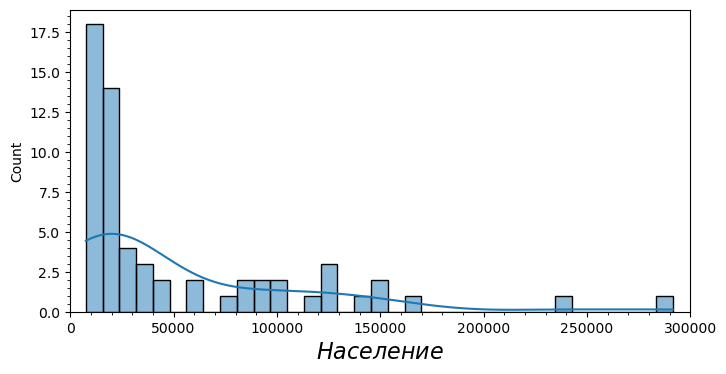

In [12]:
plt.figure(figsize=(8,4), dpi=100)
sns.histplot(data=population_nn, kde=True, x='Население', bins=35);
plt.xlim(0, 300_000)

plt.minorticks_on()
plt.xlabel(r'$Население$', fontsize=16);

def cohort(population):
    if population > 110_000:
        return '1) 110-300 тыс. чел.'
    elif population > 50_000:
        return '2) 50-110 тыс. чел.'
    elif population > 25_000:
        return '3) 25-50 тыс. чел.'
    elif population > 15_000:
        return '4) 15-25 тыс. чел.'
    else:
        return "5) 0-15 тыс. чел."

population_nn['КатегорииНаселения'] = population_nn['Население'].apply(cohort)
print(pd.DataFrame({'Категории населения %': round(population_nn['КатегорииНаселения'
                                                                ].value_counts(normalize=True),4).sort_index()*100}))

<a id="sec2.3"></a>
### [2.3. Новые признаки.](#sec2.3)

##### Районы

В которых продаются дома.

In [13]:
lst = population_nn.drop(df.iloc[[39, 42, 43, 44, 46, 48, 49, 57]
                          ].index, axis=0)['Адрес'].str.split(',').str[0].value_counts().index

lst2 = ['городской округ Арзамас','городской округ Выкса', 'городской округ Дзержинск','городской округ Кулебаки', 
        'городской округ Первомайск','городской округ Чкаловск','Новинский сельсовет, городской округ Нижний Новгород',
       'Семёновский городской округ', 'Ногинск, Богородский городской округ', 'Николо-Погостинский сельсовет', 
        'Дубки, Нижегородская область', 'Мулино, Нижегородская область', 'Мячково, Нижегородская область']

df['Районы'] = ''
df['Районы'] = search(lst.copy(), df.АдресКоррект.copy(), df.Районы.copy()) # Функция
df['Районы'] = search(lst2.copy(), df.АдресКоррект.copy(), df.Районы.copy())

df['Районы'] = df['Районы'].replace(
    {'Сормовский район':'Сормовский район, Нижний Новгород', 'Приокский район':'Приокский район, Нижний Новгород', 
     'Ардатовский район, Ардатовский район':'Ардатовский район', 'Московский район':'Московский район, Нижний Новгород', 
     'Нижегородский район':'Нижегородский район, Нижний Новгород', 'Ленинский район':'Ленинский район, Нижний Новгород',
     'Советский район':'Советский район, Нижний Новгород','Автозаводский район':'Автозаводский район, Нижний Новгород',
     'Бешенцево, городской округ Нижний Новгород':'Приокский район, Нижний Новгород',
     'Новопокровское, городской округ Нижний Новгород':'Советский район, Нижний Новгород',
     'Подновье, городской округ Нижний Новгород':'Нижегородский район, Нижний Новгород',
     'Зелёный Город, городской округ Нижний Новгород':'Нижегородский район, Нижний Новгород',
     'Ленинский район, городской округ Нижний Новгород':'Ленинский район, Нижний Новгород',
     'Нижегородский район, Зелёный Город':'Нижегородский район, Нижний Новгород',
     'Сормовский район, городской округ Нижний Новгород':'Сормовский район, Нижний Новгород',
     'Ногинск, Богородский городской округ':'Богородский муниципальный округ',
     'Канавинский район':'Канавинский район, Нижний Новгород',
     'Николо-Погостинский сельсовет':'Городецкий район', 'Дубки, Нижегородская область':'Володарский район', 
     'Мулино, Нижегородская область':'Володарский район','Мячково, Нижегородская область':'Володарский район','':'0'})

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 49.87it/s]


In [14]:
print(pd.DataFrame({'Районы %': round(df['Районы'].value_counts(normalize=True),4)})*100)

                                                    Районы %
Кстовский район                                        14.09
городской округ Бор                                     9.94
Богородский муниципальный округ                         8.76
Арзамасский район                                       4.41
Павловский муниципальный округ                          3.89
Балахнинский муниципальный округ                        3.59
Дальнеконстантиновский район                            3.53
Городецкий район                                        3.47
Нижегородский район, Нижний Новгород                    2.69
Советский район, Нижний Новгород                        2.61
Сормовский район, Нижний Новгород                       2.22
Лысковский муниципальный округ                          2.12
Дивеевский муниципальный округ                          2.10
Семёновский городской округ                             2.04
Автозаводский район, Нижний Новгород                    2.00
Приокский район, Нижний 

##### Обработка районов по количеству населения. 
- Чтобы соединить данные по домам и населению.

In [29]:
lst3 = df['Районы'].value_counts().index
lst4 = ['Ленинский район, городской округ Нижний Новгород', 'Нижегородский район, Зелёный Город', 
        'Сормовский район, городской округ Нижний Новгород', 'Автозаводский район, городской округ Нижний Новгород',
       'Канавинский район, городской округ Нижний Новгород', 'Московский район, городской округ Нижний Новгород',
       'Нижегородский район, городской округ Нижний Новгород', 'Приокский район, городской округ Нижний Новгород',
       'Советский район, городской округ Нижний Новгород']

population_nn['Районы'] = ''
population_nn['Районы'] = search(lst3.copy(), population_nn.Адрес.copy(), population_nn.Районы.copy())
population_nn['Районы'] = search(lst4.copy(), population_nn.Адрес.copy(), population_nn.Районы.copy())

population_nn['Районы'] = population_nn.Районы.str.replace(
    'Сормовский район, городской округ Нижний Новгород', 'Сормовский район, Нижний Новгород').str.replace(
    'Ленинский район, городской округ Нижний Новгород', 'Ленинский район, Нижний Новгород').str.replace(
    'Нижегородский район, Зелёный Город', 'Нижегородский район, Нижний Новгород').str.replace(
    'Автозаводский район, городской округ Нижний Новгород', 'Автозаводский район, Нижний Новгород').str.replace(
    'Канавинский район, городской округ Нижний Новгород', 'Канавинский район, Нижний Новгород').str.replace(
    'Московский район, городской округ Нижний Новгород', 'Московский район, Нижний Новгород').str.replace(
    'Нижегородский район, городской округ Нижний Новгород', 'Нижегородский район, Нижний Новгород').str.replace(
    'Приокский район, городской округ Нижний Новгород', 'Приокский район, Нижний Новгород').str.replace(
    'Советский район, городской округ Нижний Новгород', 'Советский район, Нижний Новгород')

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1747.87it/s]


In [32]:
population_nn['Районы'][:5]

0                   Ардатовский район
1                   Арзамасский район
2    Балахнинский муниципальный округ
3     Богородский муниципальный округ
4              Большеболдинский район
Name: Районы, dtype: object

In [33]:
len(df['Районы'].value_counts())==len(population_nn['Районы'])

True

In [34]:
df = pd.merge(df,population_nn[['Районы', 'КатегорииНаселения']],how='left',on='Районы')

In [35]:
df[:2]

Главное  \
0  Дом, 50 м², 6 сот., ИЖСНижегородская область,Г...   
1  Дом, 100 м², 47 сот.Только на ЦианНижегородска...   

                    Время_разм    Цена_внеш  \
0  9 часов назадсегодня, 08:53    600 000 ₽   
1   полгода назад30 сен, 12:21  1 700 000 ₽   

                                        Ссылка  \
0  https://nn.cian.ru/sale/suburban/263648098/   
1  https://nn.cian.ru/sale/suburban/264700816/   

                                            Общая пл  \
0  50 м²Общая6.0 сот.УчастокКирпичныйТип дома1Эта...   
1  100 м²Общая47.0 сот.УчастокКирпичныйТип дома1Э...   

                                            Описание  \
0  Продам земельный участок г. Заволжье, посёлок ...   
1  Продам дом. Электрическое отопление. В трех ко...   

                                             Общ_инф  \
0  Общая информацияСтатус участкаИндивидуальное ж...   
1  Общая информацияОтоплениеСанузел в домеСтатус ...   

                                               Адрес   Цена за М2  \
0  Нижегородская область, Городецкий район, Перво...  12 000 ₽/м²   
1  Нижегородская область, Сеченовский район, Ясно...  17 000 ₽/м²   

          Цена  ...                                                Гео  \
0    600 000 ₽  ...  Нижегородская область, Городецкий район, Перво...   
1  1 700 000 ₽  ...  Нижегородская область, Сеченовский район, Ясно...   

      Широта    Долгота                                       АдресКоррект  \
0  56.612888  43.363255  Школьная улица, городское поселение Первомайск...   
1  55.258084  45.927876  улица 1 Мая, Ясное, Сеченовский сельсовет, Сеч...   

  Гео2  Гео3 Гео4  Гео5             Районы   КатегорииНаселения  
0    0     0    0     0   Городецкий район  2) 50-110 тыс. чел.  
1    0     0    0     0  Сеченовский район    5) 0-15 тыс. чел.  

[2 rows x 46 columns]

##### Растояние от центра.
Вычисление расстояния от центра до дома продажи по прямой.

- Т к ближе к центру земля дороже. 
- За центр принимаю Нижегородский кремль, центр Нижнего Новгорода.

In [37]:
def haversine(data):
    """
    Вычисление расстояния в километрах между двумя точками на Земле
    """
    lon1 = data['Долгота']
    lat1 = data['Широта']
    lon2 = 44.0025226
    lat2 = 56.3286686

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    r = 6371
    return c * r

df['Долгота'] = df.Долгота.replace(0, 'NaN').astype('float64')
df['Широта'] = df.Широта.replace(0, 'NaN').astype('float64')

df['РастояниеЦентр'] = df[['Долгота', 'Широта']].apply(haversine, axis=1).round(1)
print(pd.DataFrame(df['РастояниеЦентр']))

      РастояниеЦентр
0               50.4
1              169.3
2               13.0
3               19.7
4              165.0
...              ...
5005            27.4
5006           120.8
5007            38.8
5008            52.7
5009            27.6

[5010 rows x 1 columns]


##### Тип местности

In [38]:
lst = ['деревня', 'село', 'мкр', 'городской округ', 'поселок', 'рп','Сельское поселение', 'микрорайон', 'пгт', 
       'коттеджный', 'Поселок','поселок, поселок', 'с/пос', 'городское поселение', 'деревня, деревня','Деревня', 
       'Муниципальный округ', 'муниципальный округ']

df['ТипМестности'] = ''
df['ТипМестности'] = search(lst.copy(), df.Адрес.copy(), df.ТипМестности.copy())
df['ТипМестности'] = df.ТипМестности.replace(
    {'':'Неизвестно', 'мкр': 'Микрорайон', 'рп' : 'Районное поселение', 'пгт': 'Поселок городского типа', 
        'коттеджный': 'Коттеджный поселок','поселок, поселок': 'Поселок', 'с/пос':'Сельское поселение', 
        'деревня, деревня': 'Деревня'}).str.capitalize()
print(pd.DataFrame({'Тип местности %': round(df.ТипМестности.value_counts(normalize=True),4)})*100)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 12.45it/s]

                         Тип местности %
Неизвестно                         33.57
Деревня                            16.05
Село                               15.59
Городской округ                    10.74
Микрорайон                          9.90
Муниципальный округ                 4.69
Поселок                             4.01
Районное поселение                  3.19
Сельское поселение                  1.64
Поселок городского типа             0.30
Коттеджный поселок                  0.28
Городское поселение                 0.04


##### Водные пространства

In [39]:
lst = ['Река', 'река', 'реки', 'Реки', 'Озеро', 'озеро', 'болото', 'Болото','Море', 'море', 'Моря', 'моря']

df['ВодныеПространства'] = ''
df['ВодныеПространства'] = search(lst.copy(), df.Описание.copy(), df.ВодныеПространства.copy())     
df['ВодныеПространства'] = df.ВодныеПространства.str.split().str[-1:].str.join(", ").str.capitalize().replace(
    {'':'Нет', 'Реки':'Река', 'Моря':'Море'})
print(pd.DataFrame({'Водные пространства %': round(df.ВодныеПространства.value_counts(normalize=True),4)})*100)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.42it/s]

       Водные пространства %
Нет                    78.98
Река                   12.48
Озеро                   7.29
Море                    1.26


##### Тип продажи

In [40]:
lst = ['Поместье','поместье', 'Усадьба','усадьба', 'Усадьбу', 'усадьбу', 'Купеческий', 'купеческий', 'Коттедж', 'коттедж', 
       'СНТ','снт','ДНП','днп','Дом','дом', 'Дома','дома', 'Дача','дача','Дачу','дачу','Квартира','квартира', 
       'Квартиру','квартиру','Участок','участок', 'Сад', 'сад','Огород','огород','Земля','земля', 'Землю','землю']

df['ТипПродажи'] = ''
df['ТипПродажи'] = search(lst.copy(), df.Главное.copy(), df.ТипПродажи.copy()) 
df['ТипПродажи'] = df.ТипПродажи.str.split().str[-1:].str.join(", ").str.capitalize().replace('Усадьбу','Усадьба')
print(pd.DataFrame({'Тип продажи %': round(df.ТипПродажи.value_counts(normalize=True),4)})*100)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.60it/s]

            Тип продажи %
Дом                 72.95
Коттедж             18.34
Снт                  7.60
Усадьба              0.78
Купеческий           0.16
Поместье             0.12
Днп                  0.04


##### Подвал

In [41]:
lst = ['Подвал','подвал', 'Погреб', 'погреб']
df['Подвал'] = df['Описание'].str.partition('подвал')[1]
df['Подвал'] = search(lst.copy(), df.Описание.copy(), df.Подвал.copy())     
df['Подвал'] = df.Подвал.str.split().str[-1:].str.join('').str.capitalize().replace({'':'Неизвестно','Погреб':'Подвал'})
print(pd.DataFrame({'Подвал %': round(df.Подвал.value_counts(normalize=True),4)})*100)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]

            Подвал %
Неизвестно     87.29
Подвал         12.71


##### Разница в объявлениях по дате публикации в днях

In [42]:
df['ДатаСегодня'] = '2022-04-27'
df['ДатаСегодня'] = pd.to_datetime(df.ДатаСегодня, format='%Y-%m-%d')
df['Дата'] = pd.to_datetime(df.Дата, format='%Y-%m-%d')
df['ДатаРазница'] = df['ДатаСегодня'] - df['Дата']
df['ДатаРазница'] = df.ДатаРазница.astype('str')
df['ДатаРазница'] = df.ДатаРазница.str[:-5].astype('int64')
print(pd.DataFrame(df.ДатаРазница[:5]))

   ДатаРазница
0            1
1          209
2            2
3            1
4          213


In [43]:
df.to_csv('df3_cian_house.csv', index=False)

In [44]:
df = pd.read_csv('df3_cian_house.csv')

<a id="sec2.4"></a>
### [2.4. Обработка данных по участкам (выкачанных отдельно с сайта).](#sec2.4)

##### Получаю признак стоимость участка, стоимость сотки и стоимость дома без участка

- Отдельно спарсил данные по участкам в Нижегородской области

In [5]:
df_land = pd.read_csv('df_conc_cianplot14.05.csv')

In [6]:
df_land['УчастокГа'] = df_land.Главное.str.partition('Участок, ')[2].str.partition('га')[1]
df_land['УчастокСот'] = df_land.Главное.str.partition('Участок, ')[2].str.partition('сот')[1]
df_land['Участок'] = df_land.Главное.str.partition('Участок, ')[2].str.partition(' сот.')[0].str.partition(' га')[0]

print(pd.DataFrame(df_land.Участок.sort_values().tail(1)),'\n')
df_land = df_land.drop(index=[3628]).reset_index(drop=True)
df_land['Участок'] = df_land.Участок.astype('float64')

print(pd.DataFrame(df_land.УчастокСот.value_counts()),'\n')
print(pd.DataFrame(df_land.УчастокГа.value_counts()),'\n')

for ind, land in enumerate(df_land['УчастокГа']):
    if land == 'га':
        df_land.loc[[ind], 'Участок'] = df_land.loc[[ind], 'Участок'] * 100

     Участок
3628     ИЖС 

     УчастокСот
сот        4267
            138 

    УчастокГа
         4267
га        138 



In [7]:
df_land['ЦенаКоррект'] = df_land['Цена'].str[:-2].str.replace(' ', '')
df_land = df_land.drop(index=[3712, 51, 3282]).reset_index(drop=True)
df_land['ЦенаКоррект']=df_land['ЦенаКоррект'].astype('int64')

In [8]:
df_land[:2]

Главное                                              Адрес  \
0  Участок, 10 сот., ИЖС  Нижегородская область,Богородский район,д. Тре...   
1       Участок, 10 сот.  Нижегородская область,Богородский район,д. Кил...   

        Цена                                       Ссылка  \
0   70 000 ₽  https://nn.cian.ru/sale/suburban/271888085/   
1  180 000 ₽  https://nn.cian.ru/sale/suburban/266835377/   

                                            Описание УчастокГа УчастокСот  \
0  В продаже участок\n10 сот., земли поселений (И...                  сот   
1  Участок для ИЖС в деревне Килелей. Сельские та...                  сот   

   Участок  ЦенаКоррект  
0     10.0        70000  
1     10.0       180000

In [9]:
# Перебором значений адреса, выделяю значения, которые не определяются гео библиотекой 
print(pd.DataFrame(df_land.Адрес.str.split(',').str[2].value_counts()), '\n')

punctuation = set(['На карте', 'мкр. ', ' рп', ' СНТ', ' пгт', ' с/пос', ' ТСН', ' ДНП', ' ДПК', ' дп', ' деревня', ' село',
              ' микрорайон', ' поселок', 'Поселок ', ' коттеджный', ' садовое товарищество', 'Сельское поселение ', 
              ' дачный кооператив', ' жилой район', ' садовые участки', ' пл.', 
               'Административно-территориальное образование', 'Им. '])

df_land['Гео'] = df_land['Адрес']
for delimiter in punctuation:
    df_land['Гео'] = df_land.Гео.str.replace(delimiter, '', regex=True)
    
df_land['Гео'] = df_land.Гео.str.replace('р-н','район')

print(pd.DataFrame(df_land.Гео.str.split(',').str[2].value_counts()))

                   Адрес
р-н Нижегородский     93
р-н Советский         77
р-н Приокский         57
с. Елховка            48
д. Бугры              45
...                  ...
д. Лапшлей             1
Березка СНТ            1
д. Малые Могильцы      1
д. Бастраново          1
д. Щелково             1

[1377 rows x 1 columns] 

                     Гео
район Нижегородский   93
район Советский       77
район Приокский       57
с. Елховка            48
д. Бугры              45
...                  ...
Песочная улица         1
д. Пурка               1
д. Чащиха              1
площадь Советская      1
д. Щелково             1

[1342 rows x 1 columns]


In [10]:
df_land['Гео'] = df_land['Гео'].str.split(',').str[0:4].str.join(',')
df_land['Широта'], df_land['Долгота'], df_land['АдресКоррект'] = geo(df_land.Гео.copy())

100%|██████████████████████████████████████████████████████████████████████████████| 4402/4402 [38:25<00:00,  1.91it/s]


In [11]:
print(pd.DataFrame({'Осталось пропущенных значений':df_land.Широта.value_counts().head(1)}))

   Осталось пропущенных значений
0                           1291


In [12]:
df_land['Гео2'] = df_land['Гео'].str.replace('Бор городской округ','Бор').str.replace(' с/с','').str.replace(
    'пос. ','').str.replace('Новая Кудьма тер.','Кудьма').str.replace('Новая Кудьма','Кудьма')
df_land['Гео2'] = df_land['Гео2'].str.split(',').str[0:3].str.join(',')

df_land['Гео2'] = geo_ind_2(df_land['Гео2'].copy(), df_land['АдресКоррект'].copy())
geo_lat, geo_lon, disp_name = geo_2(df_land.Гео2.copy())
df_land['Широта'], df_land['Долгота'], df_land['АдресКоррект'] = geo_fillna(
    df_land.Широта.copy(), df_land.Долгота.copy(), df_land.АдресКоррект.copy(), geo_lat, geo_lon, disp_name)

C:\Users\79200\AppData\Local\Temp/ipykernel_7828/3596094797.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_land['Гео2'] = df_land['Гео'].str.replace('Бор городской округ','Бор').str.replace(' с/с','').str.replace(
100%|██████████████████████████████████████████████████████████████████████████████| 4402/4402 [11:45<00:00,  6.24it/s]


In [13]:
print(pd.DataFrame({'Осталось пропущенных значений':df_land.Широта.value_counts().head(1)}))

   Осталось пропущенных значений
0                            198


In [14]:
df_land['Гео3'] = df_land['Гео2'].str.split(',').str[0:2].str.join(',')

df_land['Гео3'] = geo_ind_2(df_land['Гео3'].copy(), df_land['АдресКоррект'].copy())
geo_lat, geo_lon, disp_name = geo_2(df_land.Гео3.copy())
df_land['Широта'], df_land['Долгота'], df_land['АдресКоррект'] = geo_fillna(
    df_land.Широта.copy(), df_land.Долгота.copy(), df_land.АдресКоррект.copy(), geo_lat, geo_lon, disp_name)

100%|██████████████████████████████████████████████████████████████████████████████| 4402/4402 [01:42<00:00, 42.97it/s]


In [15]:
len(df_land[df_land['Широта']=='0'])

0

##### Приведение признака районы к стандарту

In [16]:
lst = df['Районы'].value_counts().index
lst2 = ['Автозаводский район', 'Московский район', 'Нижегородский район', 'Сормовский район', 'Приокский район', 
        'Ленинский район', 'Советский район', 'Золино, Нижегородская область', 'Седельниково, Нижегородская область']

df_land['Районы'] = ''
df_land['Районы'] = search(lst.copy(), df_land.АдресКоррект.copy(), df_land.Районы.copy())
df_land['Районы'] = search(lst2.copy(), df_land.АдресКоррект.copy(), df_land.Районы.copy())
df_land['Районы'] = df_land['Районы'].replace(
    {'Сормовский район':'Сормовский район, Нижний Новгород', 'Приокский район':'Приокский район, Нижний Новгород', 
     'Ардатовский район, Ардатовский район':'Ардатовский район', 'Московский район':'Московский район, Нижний Новгород', 
     'Нижегородский район':'Нижегородский район, Нижний Новгород', 'Ленинский район':'Ленинский район, Нижний Новгород',
     'Советский район':'Советский район, Нижний Новгород','Автозаводский район':'Автозаводский район, Нижний Новгород',
     'Сормовский район, городской округ Нижний Новгород':'Сормовский район, Нижний Новгород',
     'Ногинск, Богородский городской округ':'Богородский муниципальный округ',
     'Николо-Погостинский сельсовет':'Городецкий район','':'0', 
     'Бешенцево, городской округ Нижний Новгород':'Приокский район, Нижний Новгород',
     'Новопокровское, городской округ Нижний Новгород':'Советский район, Нижний Новгород',
     'Подновье, городской округ Нижний Новгород':'Нижегородский район, Нижний Новгород',
     'Зелёный Город, городской округ Нижний Новгород':'Нижегородский район, Нижний Новгород',
     'Ленинский район, городской округ Нижний Новгород':'Ленинский район, Нижний Новгород',
     'Нижегородский район, Зелёный Город':'Нижегородский район, Нижний Новгород', 
     'Золино, Нижегородская область': 'Володарский район', 'Седельниково, Нижегородская область':'Володарский район'})

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 70.26it/s]


In [17]:
df_land[df_land['Районы']=='0']['АдресКоррект']

Series([], Name: АдресКоррект, dtype: object)

In [18]:
len(df_land['Районы'].value_counts())

59

In [3]:
# df_land.to_csv('df2_conc_cianplot14.05.csv', index=False)

In [45]:
df_land = pd.read_csv('df2_conc_cianplot14.05.csv')

##### Тип участка

In [46]:
lst = ['ИЖС', 'ДНП', 'Земля промназначения', 'Инвестпроект', 'Садоводство', 'Личное подсобное хозяйство',
       'Фермерское хозяйство', 'Индивидуальное жилищное строительство', 'СНТ', 'ЛПХ']

df_land['Тип'] = ''
df_land['Тип'] = search(lst.copy(), df_land.Главное.copy(), df_land.Тип.copy())
df_land['Тип'] = search(lst.copy(), df_land.Описание.copy(), df_land.Тип.copy())
df_land['Тип'] = df_land.Тип.replace(
    {'':'Неизвестно', 'СНТ, СНТ': 'СНТ', 'СНТ, СНТ, СНТ' : 'СНТ', 'ИЖС, ИЖС': 'ИЖС', 'СНТ, СНТ, СНТ, СНТ': 'СНТ',
     'Личное подсобное хозяйство': 'ЛПХ', 'СНТ, СНТ, СНТ, СНТ, СНТ, СНТ':'СНТ', 'ДНП, ДНП': 'ДНП'}).str.capitalize()
print(pd.DataFrame({'Тип %': round(df_land.Тип.value_counts(normalize=True),4)})*100)
# Удаляю сомнительные участки
df_land = df_land.drop(index=df_land[df_land['Тип'] == 'Земля промназначения'].index).reset_index(drop=True)
df_land = df_land.drop(index=df_land[df_land['Тип'] == 'Инвестпроект'].index).reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.82it/s]

                      Тип %
Ижс                   56.75
Неизвестно            21.58
Садоводство           13.13
Фермерское хозяйство   2.32
Днп                    2.16
Снт                    1.68
Лпх                    1.29
Земля промназначения   0.86
Инвестпроект           0.23


In [47]:
df_land['ЦенаСот'] = round(df_land['ЦенаКоррект'] / df_land['Участок'],0).astype('int64')

##### Удаляю максимальные выбросы по участкам в цене

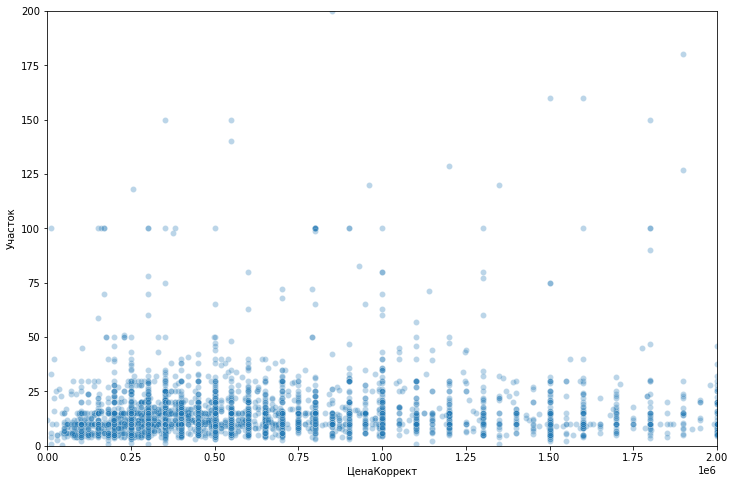

In [48]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_land, x='ЦенаКоррект', y= 'Участок', alpha=0.3)
plt.xlim(0, 2_000_000)
plt.ylim(0, 200)

df_land = df_land.drop(index=df_land[df_land['ЦенаКоррект']>2_000_000].index).reset_index(drop=True)
df_land = df_land.drop(index=df_land[df_land['Участок']>200].index).reset_index(drop=True)

##### По ценам на земельные участки нашел такой сайт 
https://tvoyadres.ru/nizhegorodskaya-oblast/tseny/dachi/ 

Цены приблизительно такие же выводит график на сайте по нужным районам.

In [49]:
# pd.set_option('display.float_format', lambda x: '% 1.f' % x)
round(df_land.groupby('Районы')['ЦенаСот'].median().sort_values(ascending=False),0)

Районы
Ленинский район, Нижний Новгород                        151087.0
Нижегородский район, Нижний Новгород                    142262.0
Советский район, Нижний Новгород                        141667.0
Автозаводский район, Нижний Новгород                    136666.0
городской округ Арзамас                                 135984.0
Сормовский район, Нижний Новгород                       120241.0
Московский район, Нижний Новгород                       105263.0
городской округ Дзержинск                               100000.0
Приокский район, Нижний Новгород                         93889.0
Новинский сельсовет, городской округ Нижний Новгород     76433.0
Канавинский район, Нижний Новгород                       71666.0
Дивеевский муниципальный округ                           61250.0
Балахнинский муниципальный округ                         60000.0
Кстовский район                                          50000.0
городской округ Бор                                      50000.0
Варнавинский район

In [50]:
df[:1]

Главное  \
0  Дом, 50 м², 6 сот., ИЖСНижегородская область,Г...   

                    Время_разм  Цена_внеш  \
0  9 часов назадсегодня, 08:53  600 000 ₽   

                                        Ссылка  \
0  https://nn.cian.ru/sale/suburban/263648098/   

                                            Общая пл  \
0  50 м²Общая6.0 сот.УчастокКирпичныйТип дома1Эта...   

                                            Описание  \
0  Продам земельный участок г. Заволжье, посёлок ...   

                                             Общ_инф  \
0  Общая информацияСтатус участкаИндивидуальное ж...   

                                               Адрес   Цена за М2       Цена  \
0  Нижегородская область, Городецкий район, Перво...  12 000 ₽/м²  600 000 ₽   

   ...  Гео5            Районы   КатегорииНаселения РастояниеЦентр  \
0  ...     0  Городецкий район  2) 50-110 тыс. чел.           50.4   

         ТипМестности  ВодныеПространства ТипПродажи      Подвал  ДатаСегодня  \
0  Районное поселение                 Нет        Дом  Неизвестно   2022-04-27   

  ДатаРазница  
0           1  

[1 rows x 53 columns]

### Соединение обработки по участкам с обработкой по домам

##### Признак цена за сотку, цена участка и пересчитанная цена дома

In [51]:
landPrice = round(df_land.groupby(['Районы'])['ЦенаСот'].mean().sort_values(ascending=False).reset_index(),0)
df = pd.merge(df, landPrice, how='left',on='Районы') # Соединение стоимости участка за 1 сот с домами

print('Процент пропущенных значений в цене за сотку:', round(df['ЦенаСот'].isnull().sum() / len(df) * 100, 2))
# Пропущенные значения в цене за сотку заполняю, исходя из категории населения
df['ЦенаСот'] = df.groupby(['КатегорииНаселения'])['ЦенаСот'].apply(lambda x: x.fillna(round(x.mean(),0)))

df['ЦенаУчастка'] = round(df['Участок'] * df['ЦенаСот'],0)
df['ЦенаБезУчастка'] = round(df['ЦенаДома'] - df['ЦенаУчастка'],0)

Процент пропущенных значений в цене за сотку: 0.52


<a id="sec3"></a>
### [3. Обработка выбросов в данных.](#sec3)

In [52]:
df = df.drop(
    ['Главное', 'Цена_внеш', 'Ссылка', 'Общая пл', 'Общ_инф', 'Адрес', 'Цена за М2', 'Цена', 
     'ЦенаВнеш', 'УчастокГа', 'УчастокСот', 'Гео', 'Гео2', 'Гео3', 'Гео4', 'Гео5','АдресКоррект', 'ДатаСегодня'], axis=1)

### Categorical Features

В случае категориальных функций мы будем использовать графики подсчета, чтобы визуализировать количество каждого отдельного значения в каждой функции. Мы видим, что некоторые категориальные функции, такие как Охрана, Бассейн, состоят в основном из одного значения, которое добавляет возможно мало полезной информации. Таким образом, мы можем удалить их позже.

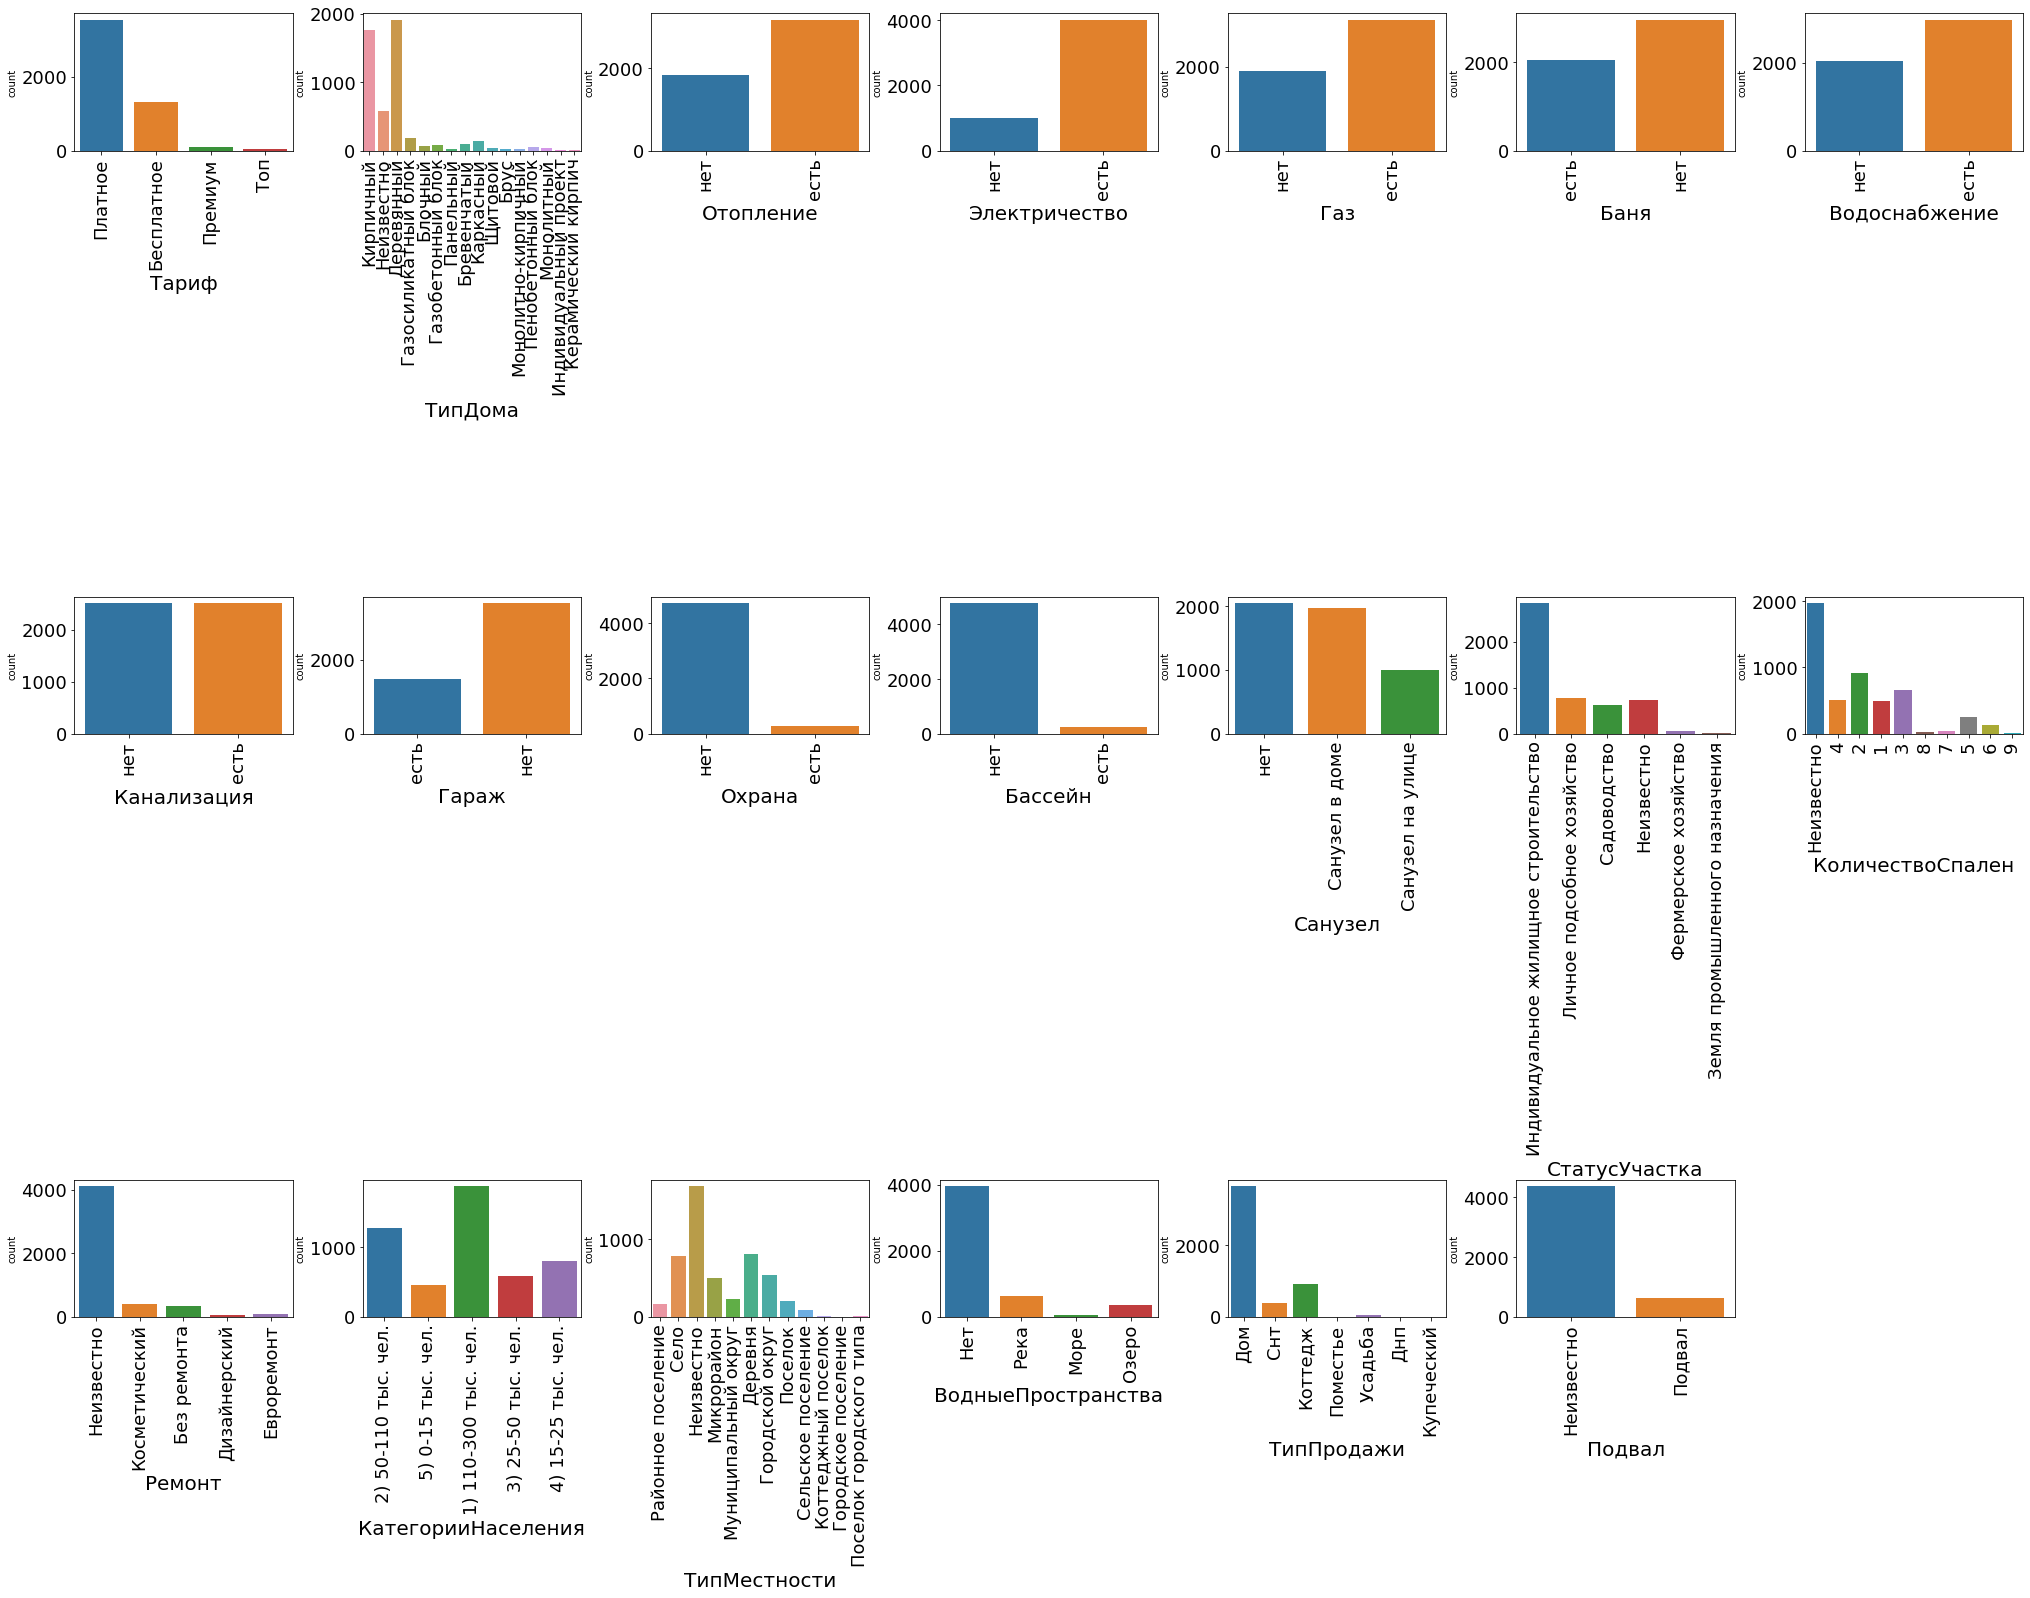

In [53]:
df_objs = df.select_dtypes(include='object').drop(['Описание', 'Районы', 'Время_разм', 'Дата'], axis=1)

fig = plt.figure(figsize=(28, 22))

for index,feature in enumerate(df_objs):
    plt.subplot(3,7,index+1)
    sns.countplot(x=feature, data=df_objs)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=5) 
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xticks(rotation=90)
    
fig.tight_layout(pad=0.0)

In [54]:
cat_col = df_objs.columns
overfit_cat = []
for i in cat_col:
    counts = df[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df) * 100 > 90:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)

In [55]:
print("Categorical Features with >90% of the same value: ",overfit_cat)

Categorical Features with >90% of the same value:  ['Охрана', 'Бассейн']


### Scatterplot.

Использование диаграммы рассеяния может помочь нам определить потенциальную линейную связь между числовыми функциями. Хотя диаграмма рассеяния не дает количественных доказательств силы линейной связи между нашими функциями, она полезна, помогая нам визуализировать любые отношения, которые не может рассчитать матрица корреляции. Например, квадратичные, экспоненциальные отношения.

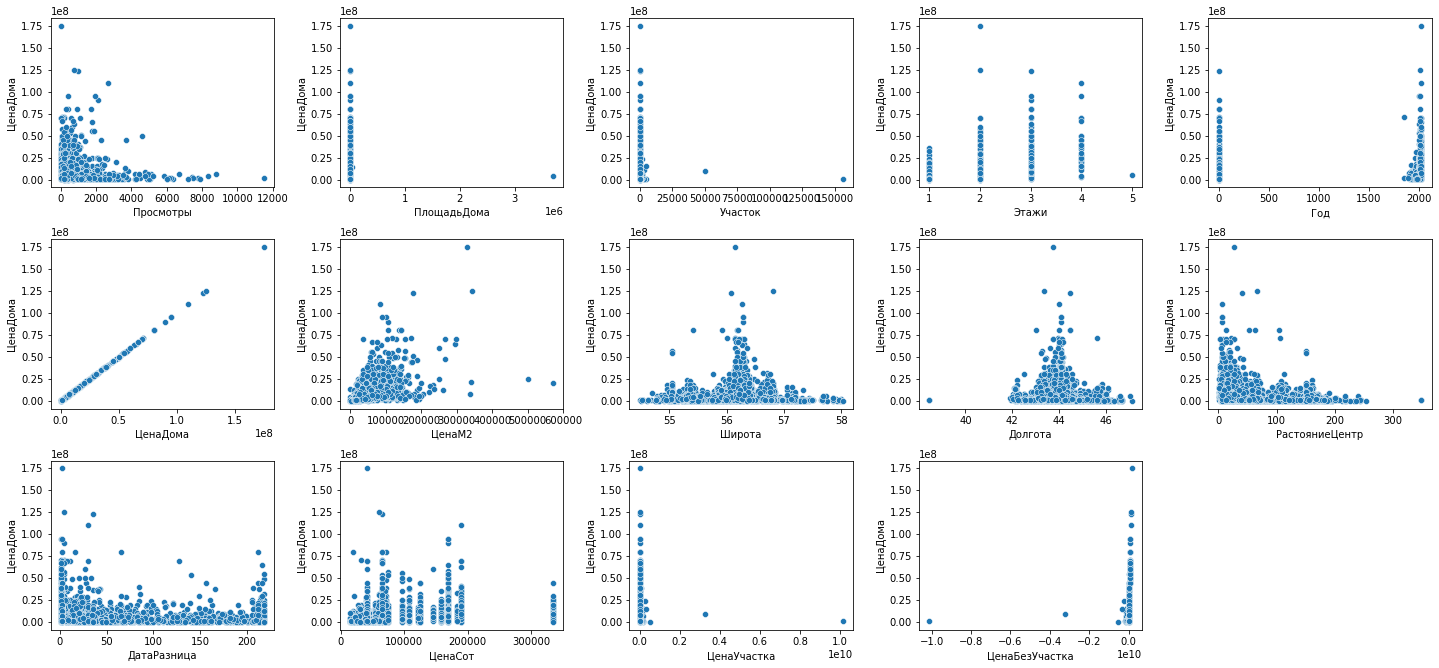

In [56]:
df_num = df.select_dtypes(exclude='object')

fig = plt.figure(figsize=(20,12))
for index in range(len(df_num.columns)):
    plt.subplot(4,5,index+1)
    sns.scatterplot(x=df_num.iloc[:,index], y='ЦенаДома', data=df)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
fig.tight_layout(pad=1.0)

### Ветхие дома и путаница в единицах измерения (сот, га, м2) на сайте.

##### Цена без участка

- Цена без участка бросается в глаза с минусовыми значениями. 
- Это новый признак. Смысл которого, найти реальные значения стоимости дома, за вычетом участка. 
- Здесь очевидно, что минусовые значения это во первых путаница у признака участок в метриках: сотки, га и м2, и оставшееся это просто навсего ветхие дома.

Обработка метрик /1000, 100, 10: 
 
       ЦенаБезУчастка
260    -1.012918e+10
3250   -3.237500e+09
2212   -5.384950e+08 



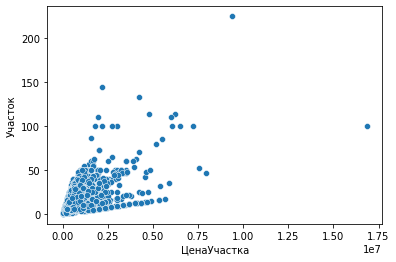

In [57]:
print('Обработка метрик /1000, 100, 10:','\n', '\n',pd.DataFrame(df['ЦенаБезУчастка'].sort_values()[:3]),'\n') 
# Видно что идет расхождение в разы поэтапно

df.loc[list(df['ЦенаБезУчастка'].sort_values()[1:3].index), 'Участок'] = df.loc[ # Исправление метрик, га, м2 на сотки
    list(df['ЦенаБезУчастка'].sort_values()[1:3].index), 'Участок'] / 1000

df.loc[list(df['ЦенаБезУчастка'].sort_values()[3:66].index), 'Участок'] = df.loc[
    list(df['ЦенаБезУчастка'].sort_values()[3:66].index), 'Участок'] / 100

df.loc[list(df['ЦенаБезУчастка'].sort_values()[66:116].index), 'Участок'] = df.loc[
    list(df['ЦенаБезУчастка'].sort_values()[66:116].index), 'Участок'] / 10

df = df.drop(index=[260]).reset_index(drop=True) # Удаление выброса

df['ЦенаУчастка'] = round(df['Участок'] * df['ЦенаСот'],0) # Пересчет значений
df['ЦенаБезУчастка'] = round(df['ЦенаДома'] - df['ЦенаУчастка'],0)

df.loc[df[df['ЦенаБезУчастка']<0].index, 'ЦенаБезУчастка'] = 0 # Что меньше нуля, это ветхие дома, которые берем за ноль

sns.scatterplot(data=df, y='Участок', x='ЦенаУчастка'); 

In [58]:
df.to_csv('df4_cian_house.csv', index=False)

In [4]:
df = pd.read_csv('df4_cian_house.csv')

##### Площадь дома

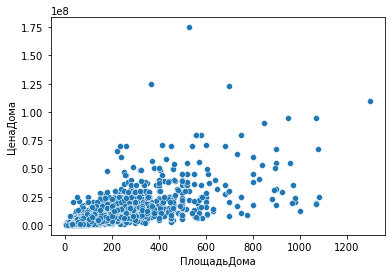

In [5]:
# df[df['ПлощадьДома']>1400]
# df[(df['ПлощадьДома']>600) & (df['ЦенаВнутр']<10000000)]
# df[(df['ПлощадьДома']>200) & (df['ЦенаВнутр']<500000)]
# df[(df['ПлощадьДома']>400) & (df['ЦенаВнутр']<5000000)]
df = df.drop(index=[3753, 775, 1776, 1160, 2517, 4849, 798, 1040, 3112, 3493, 3860, 4006, 
                    4549, 257, 622, 3025, 3166, 2770, 3107, 605]).reset_index(drop=True)
sns.scatterplot(data=df, x='ПлощадьДома', y = 'ЦенаДома');

##### Долгота

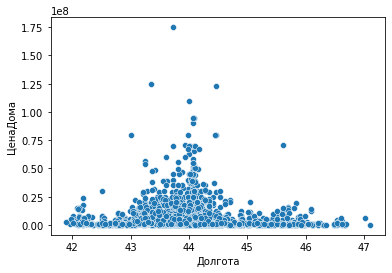

In [6]:
# df[df['Долгота']<40]
df = df.drop(index=[506, 2386]).reset_index(drop=True)
sns.scatterplot(data=df, x='Долгота', y = 'ЦенаДома');

##### Участок

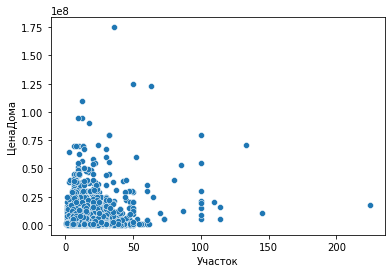

In [7]:
# df[df['Участок']>90]
# df[(df['Участок']>20) & (df['ЦенаВнутр']<200000)]
sns.scatterplot(data=df, x='Участок', y = 'ЦенаДома');

##### Площадь дома

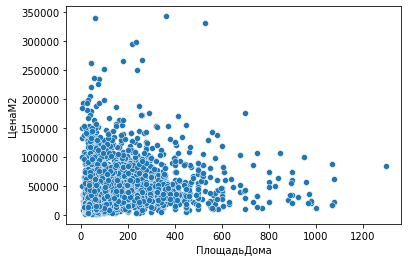

In [8]:
# df[df['ЦенаМ2']<2000]
# df[df['ЦенаМ2']>300000]
df = df.drop(index=[4595, 4569, 2777, 2599, 2944, 4524]).reset_index(drop=True)
sns.scatterplot(data=df, x='ПлощадьДома', y = 'ЦенаМ2');

<a id="sec3.1"></a>
### [3.1. Удаление данных узкой категории, которые вносят выбросы.](#sec3.1)

##### В стадии строительства.
- Переодически попадались данные, в стадии строительства.
- Удаляю т к это по сути выбросы.
- Данные на выходе были улучшены.

In [9]:
description = []
for i in df['Описание']:
    i = i.translate(str.maketrans('', '', string.punctuation))
    try:
        res = i[i.index('стадии строительства')-1:]
    except:
        res = 'NaN'
    description.append(res)
    
description = pd.Series(description)
print(description[description!='NaN'].index)

df = df.drop(index=[ 372,  703,  913,  972, 1075, 1127, 1975, 2082, 2086, 2092, 2106,
            2569, 2632, 3349, 4070, 4110, 4438, 4610, 4798, 4868]).reset_index(drop=True)

Int64Index([ 372,  703,  913,  972, 1075, 1127, 1975, 2082, 2086, 2092, 2106,
            2569, 2632, 3349, 4070, 4110, 4438, 4610, 4798, 4868],
           dtype='int64')


### Numeric Features
Что касается числовых признаков, нас всегда интересует распределение этих признаков, включая статистические характеристики этих столбцов, например, среднее значение, медиана, мода. Следовательно, мы будем использовать график распределения для визуализации их распределения данных.

##### Посмотрим на распределения

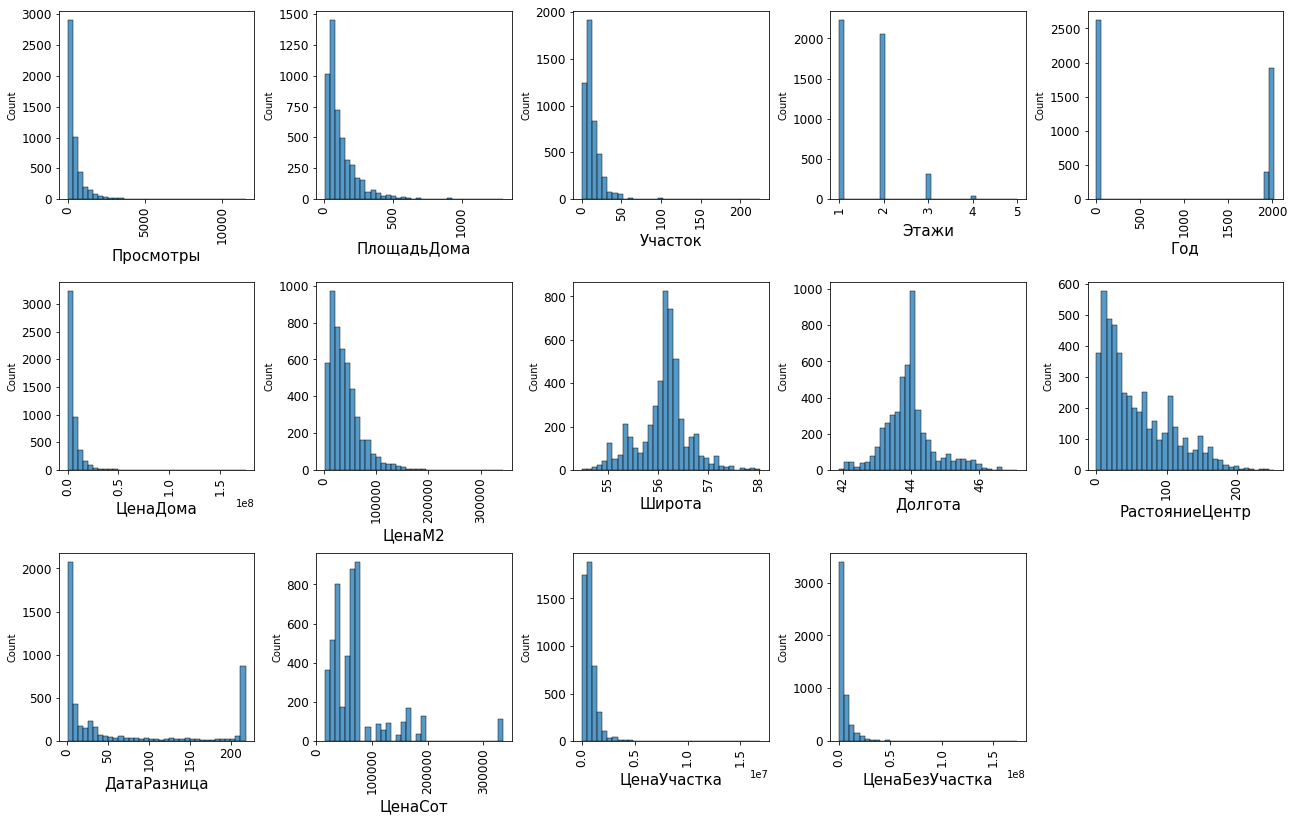

In [10]:
df_num = df.select_dtypes(exclude='object')

fig = plt.figure(figsize=(18,18))

for index,feature in enumerate(df_num):
    plt.subplot(5,5,index+1)
    sns.histplot(x=feature, data=df_num, bins=35)
    
    plt.xlabel('{}'.format(feature), size=15, labelpad=5) 
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.xticks(rotation=90)
    
fig.tight_layout(pad=1.0)

In [11]:
int_col = df_num.columns
overfit_num = []
for i in int_col:
    counts = df[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df) * 100 > 50:
        overfit_num.append(i)

overfit_num = list(overfit_num)

In [12]:
print("Numerical Features with >50% of the same value: ",overfit_num)

Numerical Features with >50% of the same value:  ['Год']


##### - Больше 50 % у нас не хватает в признаке год.
##### - Год по сути это один из ключевых признаков, который может значительно влиять на общую картину.
- Помимо, у нас много ассиметричных распределений.
- Особенно, это важно для целевого значения цена дома.

<a id="sec4"></a>
### [4. Обработка пропущенных значений.](#sec4)

In [13]:
def percent_missing(df):
    percent_nan = (df.isnull().sum() / len(df))*100
    percent_nan = percent_nan[percent_nan>0].sort_values(ascending=False)
    return percent_nan

In [14]:
print('\033[1m'+'Проценты пропущенных значений'+'\033[0m', '\n', '\n', percent_missing(df), sep='')

Проценты пропущенных значений

Этажи    6.772828
dtype: float64


Очень интересно, что всего 1 дом 5 этажный

In [15]:
print(df[df['Этажи']==5].index)
df.Описание.iloc[4757]

Int64Index([4757], dtype='int64')


'Дом в центре г. Володарска, каменный 90 кв, двухэтажный плюс цокольный этаж ( подвал). Кухня, зал с камином, четыре комнаты, две прихожии, санузел, кладовка. В доме газ АГВ, вода, свет 380 вт. Участок 11 соток. Все находится в шаговой доступности: платформа, остановки, магазины, школа, поликлиника, администрация. 5700 000руб.торг уместен.'

                Корреляция этажей
ПлощадьДома                  0.64
ЦенаДома                     0.51
ЦенаБезУчастка               0.51
ЦенаСот                      0.26
Год                          0.19 

       ПлощадьДома
Этажи             
1.0          60.95
2.0         152.72
3.0         345.83
4.0         567.85 



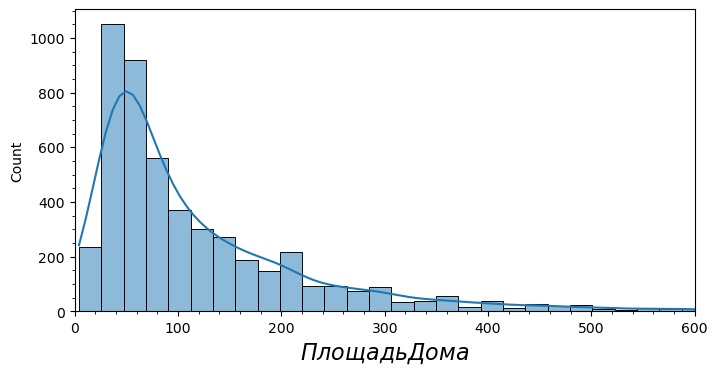

In [16]:
df = df.drop(index=[4757]).reset_index(drop=True)

print(pd.DataFrame({'Корреляция этажей' : round(df.corr()['Этажи'].sort_values(ascending=False)[1:6],2)}),'\n')

# Заполним пропущенные значения средними значениями, т к этажей всего 4 варианта с группировкой по площади дома 
# в категорийном значении
print(pd.DataFrame(round(df.groupby(['Этажи'])['ПлощадьДома'].mean(),2)),'\n')

plt.figure(figsize=(8,4), dpi=100)
sns.histplot(data=df, kde=True, x='ПлощадьДома', bins=60);
plt.xlim(0, 600)
plt.minorticks_on()
plt.xlabel(r'$Площадь Дома$', fontsize=16);
df['ПлощадьКат'] = pd.cut(df['ПлощадьДома'],
                               bins=[0., 65, 160, 350, np.inf],
                               labels=[1, 2, 3, 4]).astype('int64')

In [17]:
# Сравнение соотношений Площадь по категориям и Этажей
print(pd.DataFrame({'Площадь категории %': round(df['ПлощадьКат'].value_counts(normalize=True),2)}))
df['Этажи'] = df.groupby(['ПлощадьКат'])['Этажи'].apply(lambda x: x.fillna(round(x.mean(),0)))
print(pd.DataFrame({'Этажи %': round(df['Этажи'].value_counts(normalize=True),2)}))

   Площадь категории %
1                 0.43
2                 0.33
3                 0.18
4                 0.05
     Этажи %
1.0     0.48
2.0     0.45
3.0     0.07
4.0     0.01


<a id="sec5"></a>
### [5. EDA - Разведочный анализ данных.](#sec5)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Время_разм          4960 non-null   object 
 1   Описание            4960 non-null   object 
 2   Просмотры           4960 non-null   int64  
 3   Тариф               4960 non-null   object 
 4   ПлощадьДома         4960 non-null   float64
 5   Участок             4960 non-null   float64
 6   ТипДома             4960 non-null   object 
 7   Этажи               4960 non-null   float64
 8   Год                 4960 non-null   float64
 9   Отопление           4960 non-null   object 
 10  Электричество       4960 non-null   object 
 11  Газ                 4960 non-null   object 
 12  Баня                4960 non-null   object 
 13  Водоснабжение       4960 non-null   object 
 14  Канализация         4960 non-null   object 
 15  Гараж               4960 non-null   object 
 16  Охрана

In [19]:
# pd.set_option('display.float_format', lambda x: '%.0f' % x)
round(df.describe(),0)

Просмотры  ПлощадьДома  Участок   Этажи     Год     ЦенаДома    ЦенаМ2  \
count     4960.0       4960.0   4960.0  4960.0  4960.0       4960.0    4960.0   
mean       471.0        124.0     13.0     2.0   940.0    5803159.0   40877.0   
std        713.0        125.0     11.0     1.0   998.0    9177787.0   32114.0   
min          0.0          4.0      0.0     1.0     0.0      50000.0    2000.0   
25%         90.0         46.0      7.0     1.0     0.0     900000.0   18321.0   
50%        243.0         80.0     10.0     2.0     0.0    2960000.0   33333.0   
75%        567.0        159.0     16.0     2.0  2008.0    7000000.0   53910.0   
max      11494.0       1300.0    225.0     4.0  2024.0  174999999.0  342466.0   

       Широта  Долгота  РастояниеЦентр  ДатаРазница   ЦенаСот  ЦенаУчастка  \
count  4960.0   4960.0          4960.0       4960.0    4960.0       4960.0   
mean     56.0     44.0            58.0         63.0   72479.0     806443.0   
std       0.0      1.0            48.0         84.0   56699.0     696460.0   
min      54.0     42.0             0.0          1.0   14964.0       5394.0   
25%      56.0     44.0            18.0          2.0   41378.0     402616.0   
50%      56.0     44.0            42.0         13.0   64938.0     634352.0   
75%      56.0     44.0            88.0        120.0   70953.0     990046.0   
max      58.0     47.0           253.0        218.0  334551.0   16857000.0   

       ЦенаБезУчастка  ПлощадьКат  
count          4960.0      4960.0  
mean        5049065.0         2.0  
std         8896918.0         1.0  
min               0.0         1.0  
25%          353414.0         1.0  
50%         2161691.0         2.0  
75%         6243327.0         2.0  
max       173495199.0         4.0

In [20]:
df.describe(include='object')

Время_разм  \
count                           4960   
unique                          3265   
top     18 часов назадсегодня, 02:10   
freq                              28   

                                                 Описание    Тариф  \
count                                                4960     4960   
unique                                               4945        4   
top     Продам дом Чкаловский район д.Голышево бревенч...  Платное   
freq                                                    2     3505   

           ТипДома Отопление Электричество   Газ  Баня Водоснабжение  \
count         4960      4960          4960  4960  4960          4960   
unique          16         2             2     2     2             2   
top     Деревянный      есть          есть  есть   нет          есть   
freq          1894      3143          3965  3089  2925          2940   

       Канализация  ...                          СтатусУчастка  \
count         4960  ...                                   4960   
unique           2  ...                                      6   
top           есть  ...  Индивидуальное жилищное строительство   
freq          2482  ...                                   2815   

       КоличествоСпален      Ремонт        Дата           Районы  \
count              4960        4960        4960             4960   
unique               10           5         209               60   
top          Неизвестно  Неизвестно  2022-04-25  Кстовский район   
freq               1951        4062        1041              701   

          КатегорииНаселения ТипМестности ВодныеПространства ТипПродажи  \
count                   4960         4960               4960       4960   
unique                     5           12                  4          7   
top     1) 110-300 тыс. чел.   Неизвестно                Нет        Дом   
freq                    1858         1663               3917       3627   

            Подвал  
count         4960  
unique           2  
top     Неизвестно  
freq          4329  

[4 rows x 24 columns]

In [21]:
# Получение количества уникальных записей в каждом столбце 
df_nunique = list(map(lambda col: df[col].nunique(), df))
d = dict(zip(df, df_nunique))

# Количество уникальных записей по столбцам в порядке возрастания
sorted(d.items(), key=lambda x: x[1])

[('Отопление', 2),
 ('Электричество', 2),
 ('Газ', 2),
 ('Баня', 2),
 ('Водоснабжение', 2),
 ('Канализация', 2),
 ('Гараж', 2),
 ('Охрана', 2),
 ('Бассейн', 2),
 ('Подвал', 2),
 ('Санузел', 3),
 ('Тариф', 4),
 ('Этажи', 4),
 ('ВодныеПространства', 4),
 ('ПлощадьКат', 4),
 ('Ремонт', 5),
 ('КатегорииНаселения', 5),
 ('СтатусУчастка', 6),
 ('ТипПродажи', 7),
 ('КоличествоСпален', 10),
 ('ТипМестности', 12),
 ('ТипДома', 16),
 ('ЦенаСот', 58),
 ('Районы', 60),
 ('Год', 110),
 ('Дата', 209),
 ('ДатаРазница', 209),
 ('Участок', 401),
 ('ЦенаДома', 681),
 ('ПлощадьДома', 1078),
 ('РастояниеЦентр', 1295),
 ('Просмотры', 1373),
 ('ЦенаУчастка', 1730),
 ('ЦенаМ2', 2898),
 ('Широта', 3109),
 ('Долгота', 3111),
 ('Время_разм', 3265),
 ('ЦенаБезУчастка', 3985),
 ('Описание', 4945)]

##### Категории цен

Посмотрим по бинам, в каких сегментах больше скапливаются цены продаж. Сделаем категории цен.

   Цена категории %
4             22.36
2             17.48
5             14.72
3             14.29
6             11.77
1             11.11
7              8.27


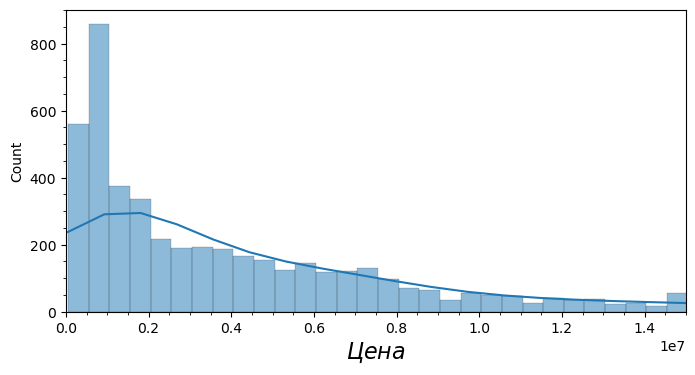

In [22]:
plt.figure(figsize=(8,4), dpi=100)
sns.histplot(data=df, kde=True, x='ЦенаДома', bins=350);
plt.xlim(0, 15_000_000)
plt.minorticks_on()
plt.xlabel(r'$Цена$', fontsize=16);

df['ЦенаКат'] = pd.cut(df['ЦенаДома'],
                               bins=[0., 500_000, 1_000_000, 2_000_000, 5_000_000, 8_000_000, 15_000_000, np.inf],
                               labels=[1, 2, 3, 4, 5, 6, 7]).astype('int64')

print(pd.DataFrame({'Цена категории %': round(df['ЦенаКат'].value_counts(normalize=True),4)*100}))

<a id="sec5.2"></a>
### [5.2 Data visualization.](#sec5.2)

##### Работа с гео данными

Посмотрим распределение данных географически

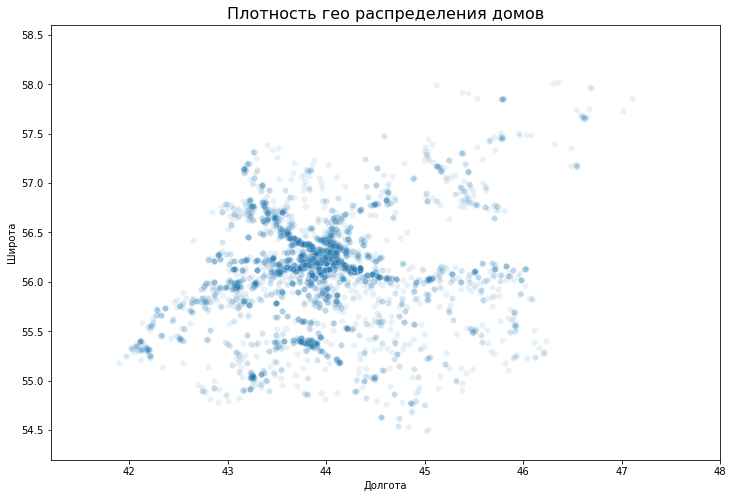

In [23]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data = df, x="Долгота", y="Широта",  alpha=0.1)
plt.ylim([54.2, 58.6])
plt.xlim([41.2, 48.0])
plt.title('Плотность гео распределения домов', fontsize=16);

Есть понятные очертания центра и направлений от центра.

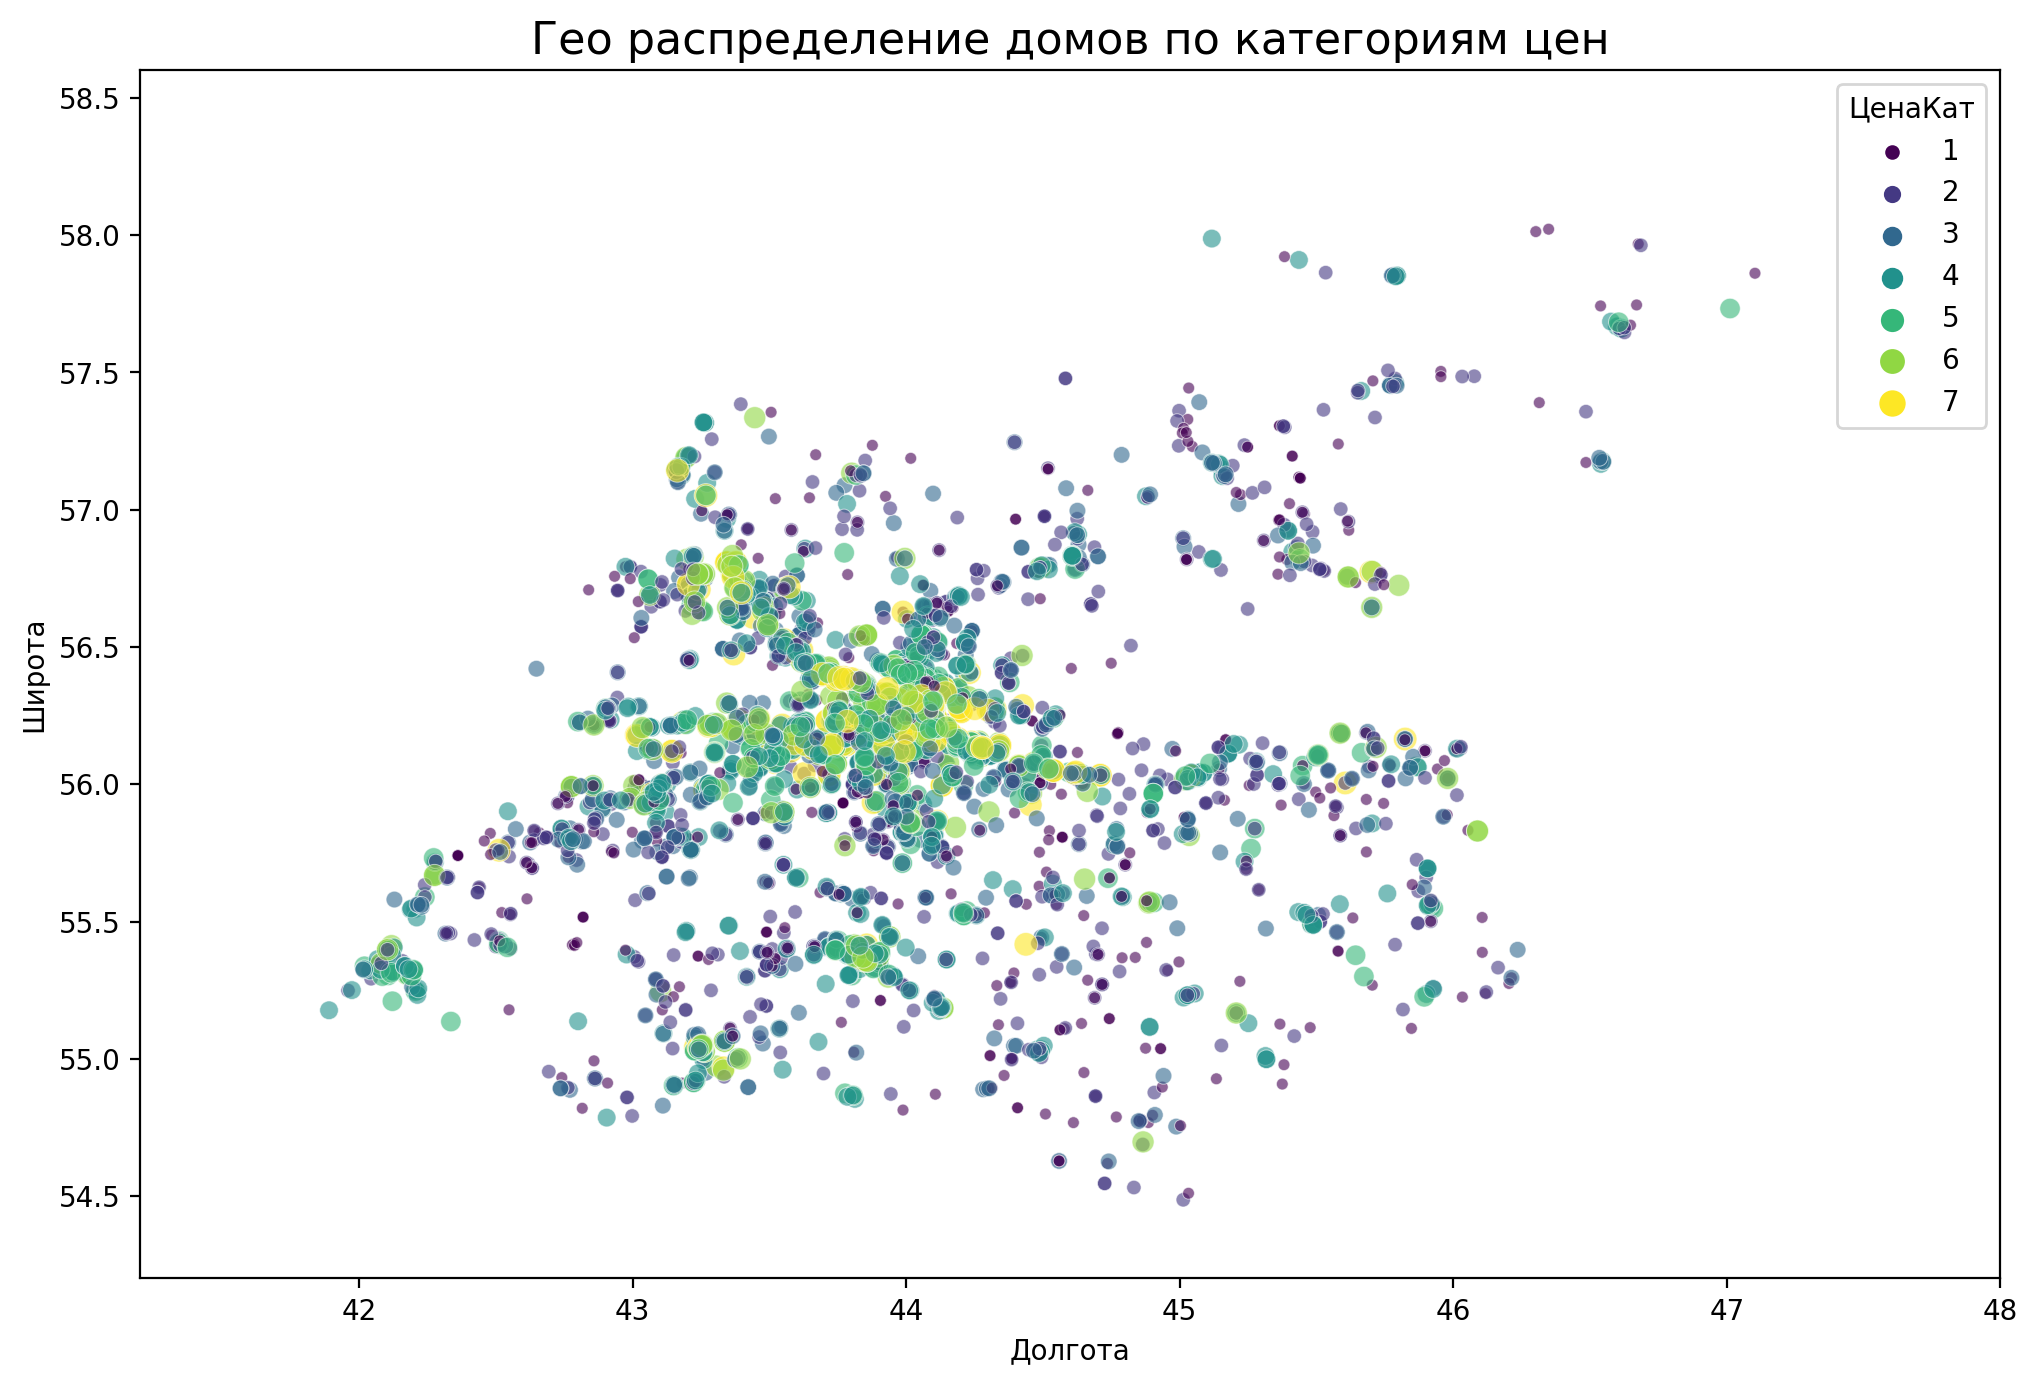

In [24]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data = df, y = 'Широта', x = 'Долгота', hue='ЦенаКат', 
                size='ЦенаКат', palette='viridis',  legend="full", alpha=0.6)
plt.ylim([54.2, 58.6])
plt.xlim([41.2, 48.0])
plt.title('Гео распределение домов по категориям цен', fontsize=16);
plt.show()

- Очевидно, что районы влияют на стоимость.
- Скорее всего, здесь должна быть взаимосвязь по количеству населения. Т к есть скопления домов по стоимости не только в центре.

##### Визуализация, с картой местности

In [25]:
import os
images_path = os.path.join(".", "images", "project")
os.makedirs(images_path, exist_ok=True)
filename = "NN.jpg"

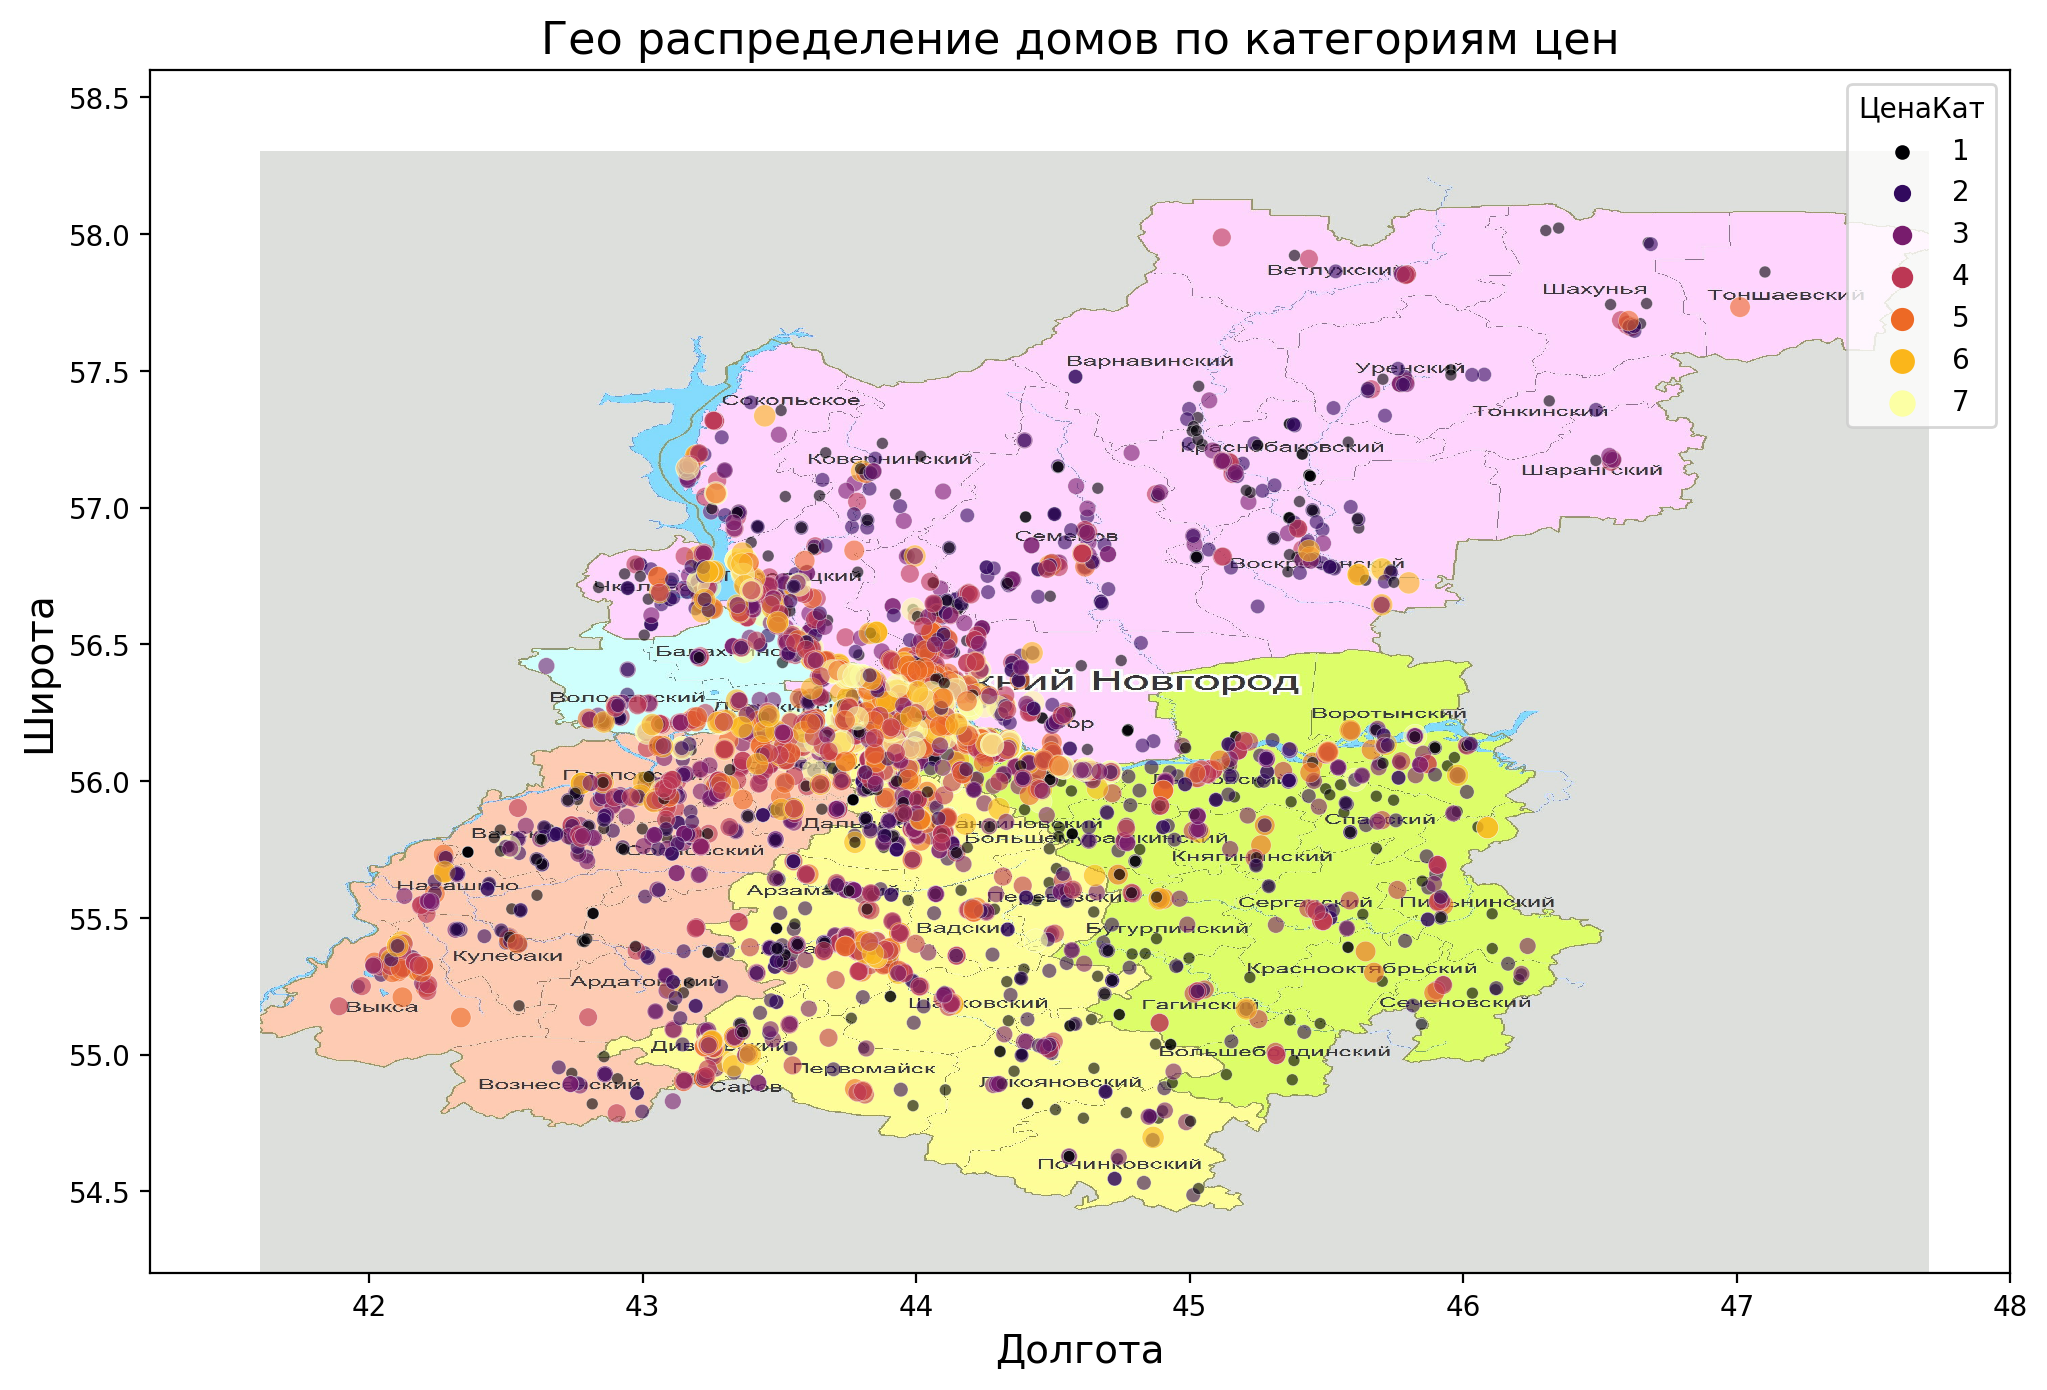

In [26]:
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join(images_path, filename))

plt.figure(figsize=(12, 8), dpi=200)

sns.scatterplot(data = df, y = 'Широта', x = 'Долгота', hue='ЦенаКат', 
                size='ЦенаКат', palette='inferno',  legend="full", alpha=0.6, linewidth=0.2)

plt.ylim([54.2, 58.6])
plt.xlim([41.2, 48.0])

plt.imshow(img, extent=[41.6, 47.7, 54.2, 58.3], alpha=0.8,
           cmap=plt.get_cmap("jet"), interpolation='nearest')
plt.ylabel("Широта", fontsize=14)
plt.xlabel("Долгота", fontsize=14);
plt.title('Гео распределение домов по категориям цен', fontsize=16);

- Явно видно распределение в центре и вдоль водных пространств и по всей видимости в крупных городах.

##### Распределение населения по районам

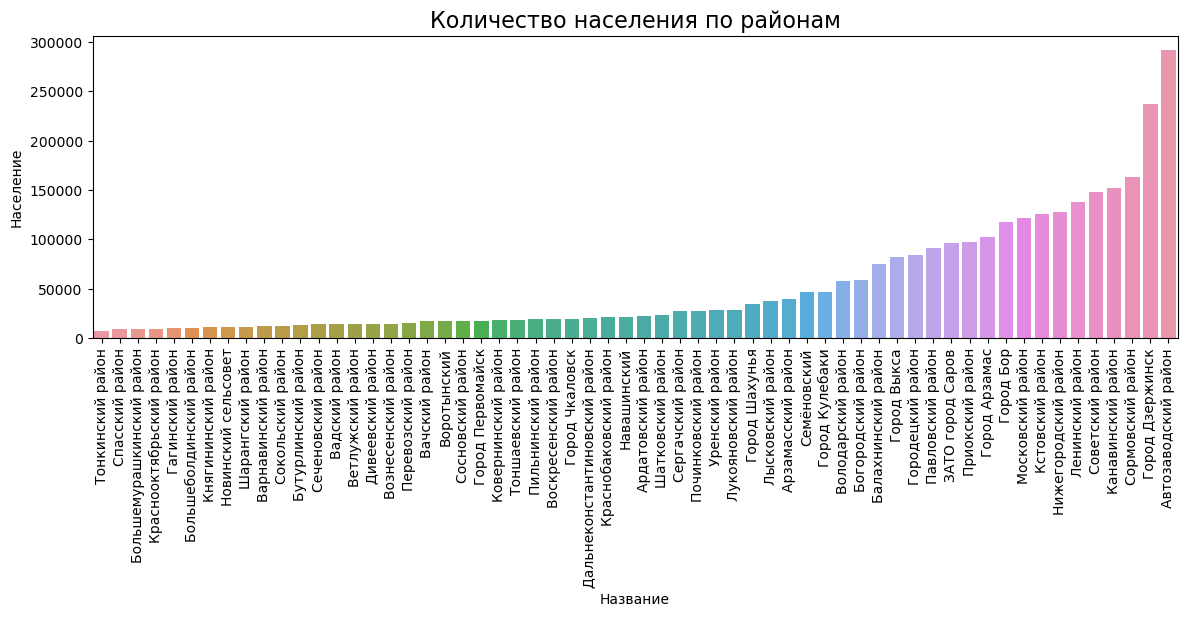

In [225]:
geo_graf = population_nn[['Название', 'Население']].sort_values('Население')
plt.figure(figsize=(14,4), dpi=100)
sns.barplot(data = geo_graf, x='Название', y = 'Население')
plt.title('Количество населения по районам', fontsize=16);
plt.xticks(rotation=90);

- Интересный факт, первые топ 3 места по количеству населения занимают рабочие районы Нижнего Новгорода: Автозаводский и Сормовский, а также промышленный город Дзержинск.

##### Количество населения в районах продаж

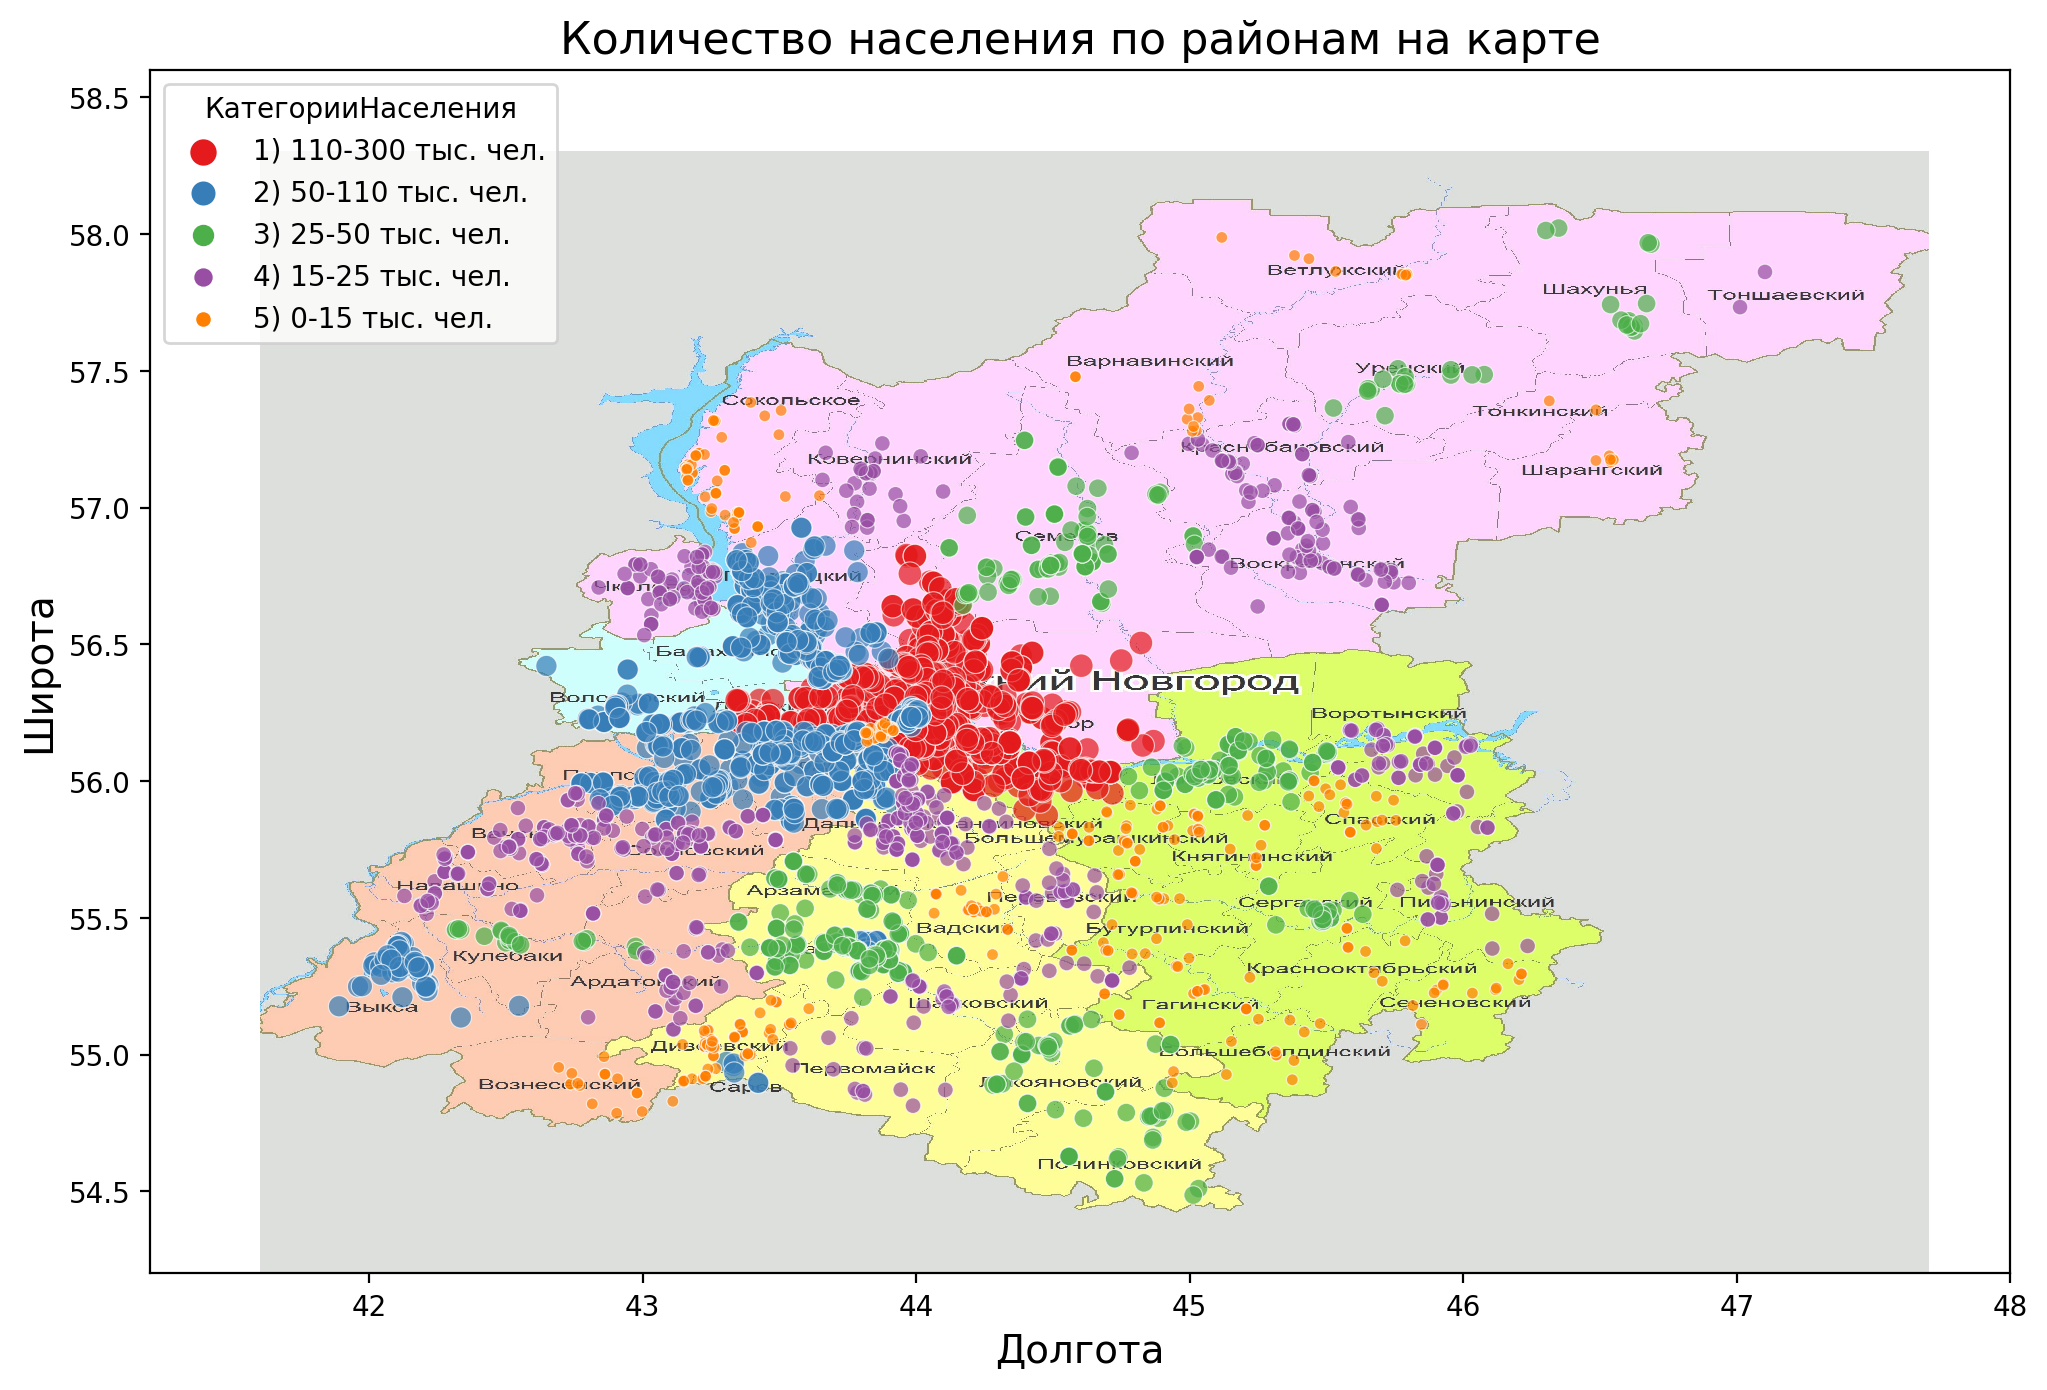

In [27]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data = df.sort_values('КатегорииНаселения'), y = 'Широта', x = 'Долгота', hue='КатегорииНаселения', 
                size='КатегорииНаселения', palette='Set1',  legend="full", alpha=0.7, linewidth=0.4)
plt.ylim([54.2, 58.6])
plt.xlim([41.2, 48.0])
plt.imshow(img, extent=[41.6, 47.7, 54.2, 58.3], alpha=0.8,
           cmap=plt.get_cmap("jet"), interpolation='nearest')
plt.ylabel("Широта", fontsize=14)
plt.xlabel("Долгота", fontsize=14);
plt.title('Количество населения по районам на карте', fontsize=16);

Получается следующее:
- Есть взаимосвязь населения, городов близких к центру и близость к водным пространствам

##### Детальные продажи по районам

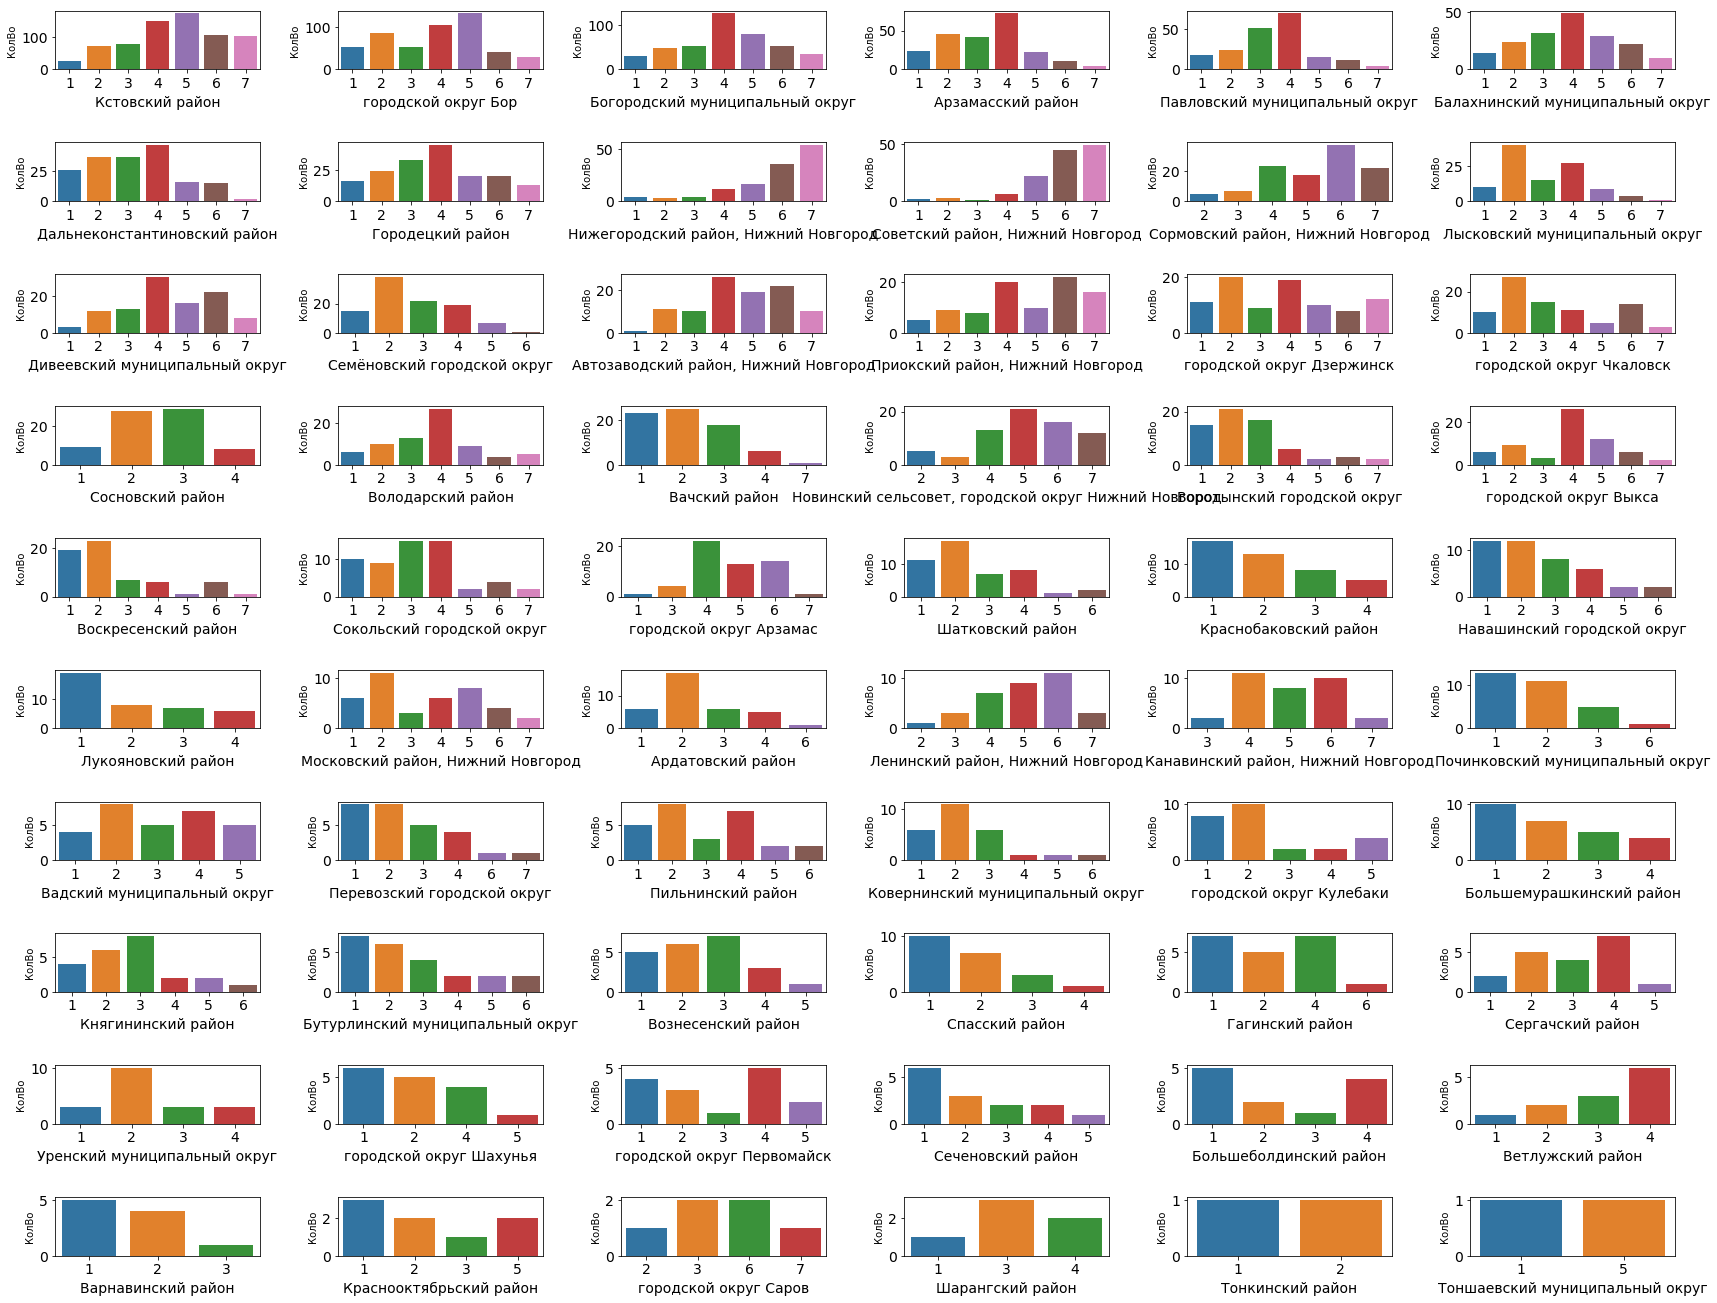

In [28]:
df['КолВо']=1
district_cat = df.groupby(['Районы', 'ЦенаКат'])['КолВо'].sum()
district_cat = district_cat.reset_index()

lst = df['Районы'].value_counts().index
fig = plt.figure(figsize=(24,20))
for index, feature in enumerate(lst):
    diagram = district_cat[district_cat['Районы']==f'{feature}']
    plt.subplot(11,6,index+1)
    sns.barplot(data =diagram,  x ='ЦенаКат', y='КолВо')
    plt.xlabel('{}'.format(feature), size=14, labelpad=5) 
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
fig.tight_layout(pad=3.0)
plt.show();

##### Распределение по годам

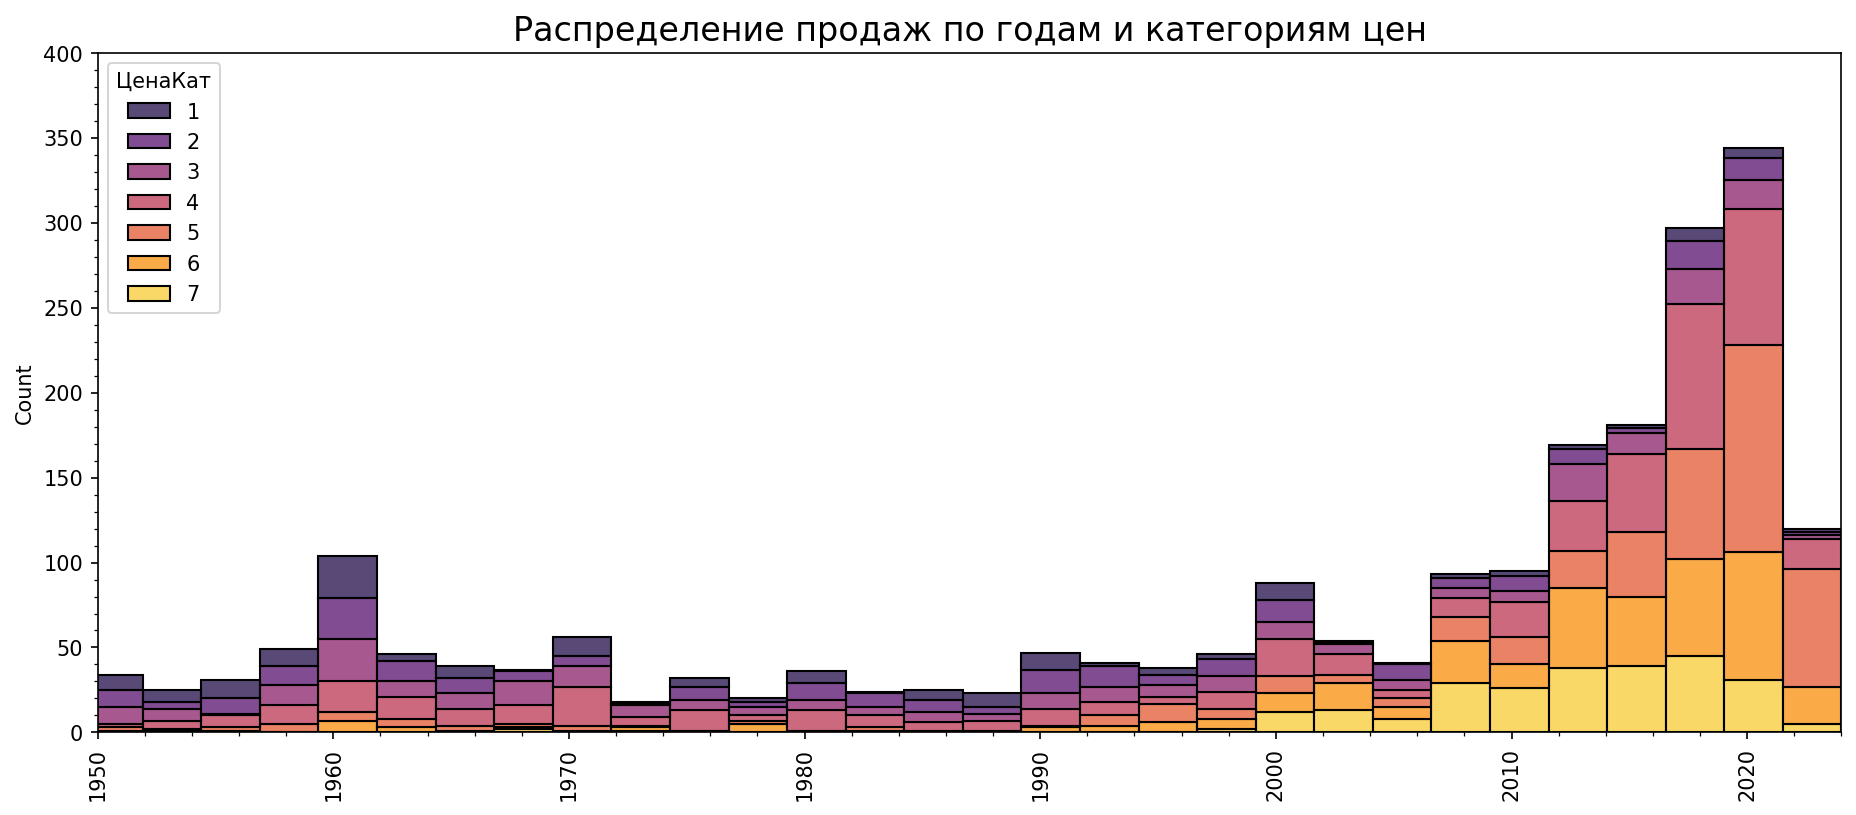

In [29]:
df['Год'] = df['Год'].fillna(0)
df['Год'] = df['Год'].astype('int64')
year = pd.pivot(data=df[df['Год']!=0], columns='ЦенаКат',values='Год')

plt.subplots(figsize=(15,6),dpi=150)
sns.histplot(year,bins=70, multiple="stack", palette='inferno')
plt.xlim(1950,2024)
plt.ylim(0,400)
plt.minorticks_on()
plt.title('Распределение продаж по годам и категориям цен', fontsize=16);
plt.xticks(rotation=90);

- Видно четко выраженную продажу новых домов от 2010 года, в основном в дорогих и средних категориях.
- Конечно мы должны понимать, что 50 % данных по годам у нас нет. Это может прибавить вес и остальным категориям.

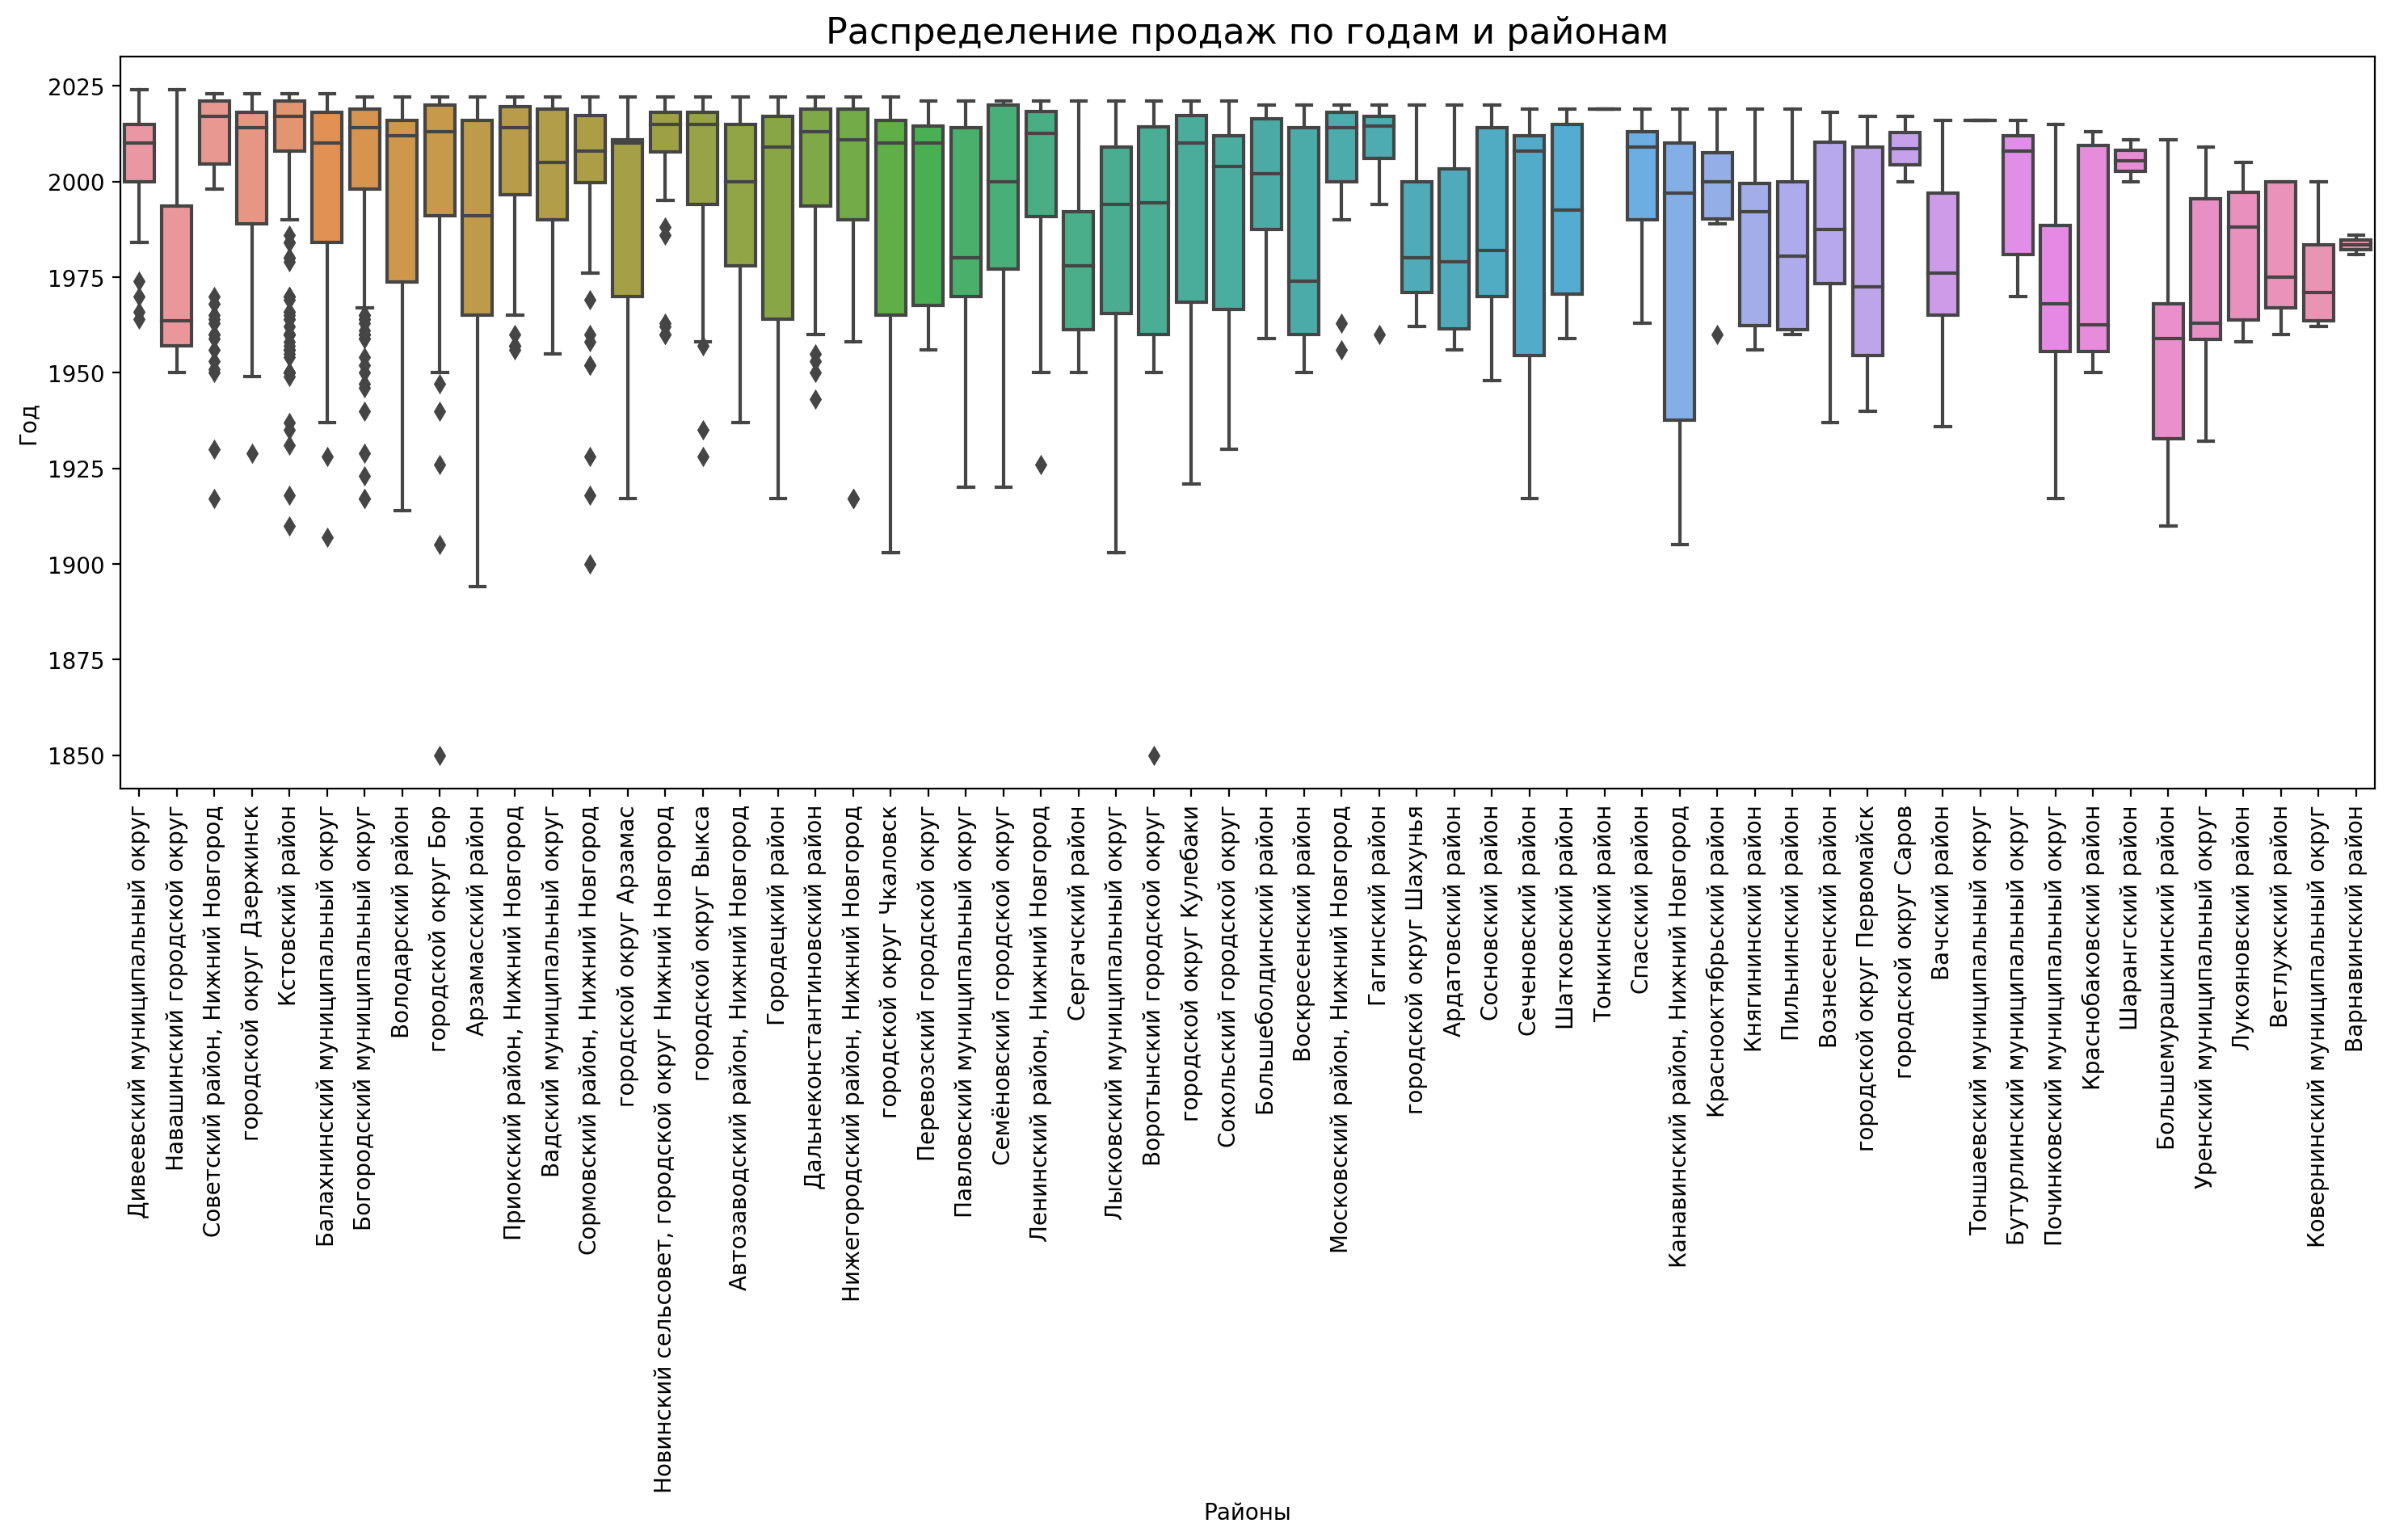

In [30]:
wear = df[df['Год']!=0].sort_values(['Районы', 'ЦенаКат', 'Год'])[['Районы', 'ЦенаКат', 'Год']]

plt.figure(figsize=(18,6), dpi=200)
sns.boxplot(data=wear.sort_values('Год', ascending=False), x='Районы', y='Год')
plt.title('Распределение продаж по годам и районам', fontsize=16);
plt.xticks(rotation=90);

- Есть районы в которых присутствуют значительные выбросы по годам, в сторону старых домов. 
- Но опять надо учитывать, что 50% данных отсутствуют.

<a id="sec5.3"></a>
### [5.3. Ключевой признак: Состояние дома.](#sec5.3)

- Должен перекрыть частично, данные в которых не хватает годов. И сбалансировать данные.

- На основании, что раньше были определены ветхие дома 
- Из графиков получаем хорошее количество новых домов

In [31]:
df['СостояниеДома'] = 'Неизвестно'

df.loc[list(df[df['Год']>2011].index), 'СостояниеДома'] = '2' # Новые
df.loc[list(df[df['ЦенаБезУчастка']<500_000].index), 'СостояниеДома'] = '0' # Ветхие
df.loc[list(df[df['СостояниеДома']=='Неизвестно'].index), 'СостояниеДома'] = '1' # Неизвестно
print(pd.DataFrame({'Состояние дома %': round(df['СостояниеДома'].value_counts(normalize=True),4)*100}))

   Состояние дома %
1             49.94
0             28.95
2             21.11


##### Процент ветхих домов без года

- 50 % у нас не хватает годов
- При том 19 % домов без годов у нас попадает в ветхие дома
- Чудная замена нехватки годов

- Видимо люди не хотят указывать года ветхих домов

In [32]:
print('Процент ветхих домов пойманные в незаполненных годах %:' , round(len(df[(df['СостояниеДома']=='0') & (df['Год']==0)]) / len(df)*100, 2), '\n')
print(pd.DataFrame({'Год %': round(df[['СостояниеДома', 'Год']].value_counts(normalize=True)[:15],4)*100}))

Процент ветхих домов пойманные в незаполненных годах %: 19.35 

                    Год %
СостояниеДома Год        
1             0     33.59
0             0     19.35
2             2021   4.11
              2020   2.42
              2022   2.24
              2018   2.08
              2015   1.81
              2017   1.75
              2019   1.71
              2016   1.69
              2014   1.19
1             2010   1.11
2             2013   1.09
1             2000   1.09
              1960   0.91


<a id="sec5.4"></a>
### [5.4. Time data.](#sec5.4)

##### Дата последнего обновления объявления

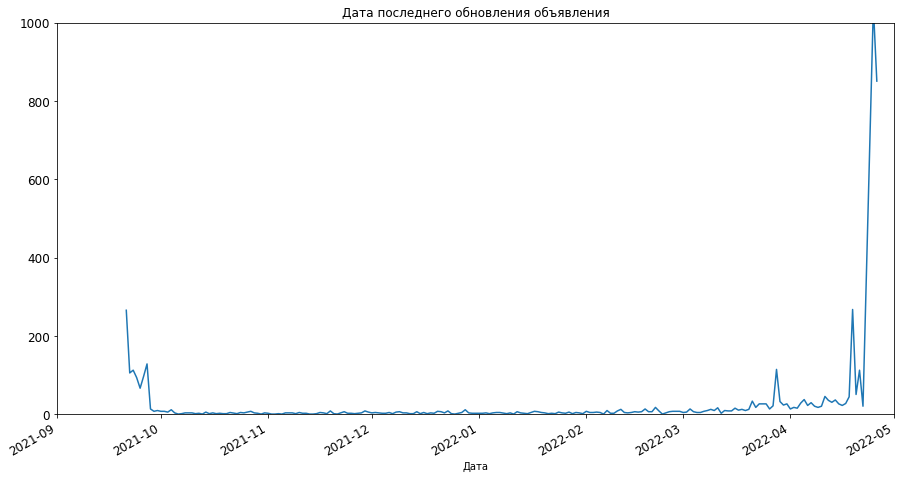

In [33]:
df['Дата'] = pd.to_datetime(df['Дата'], format='%Y-%m-%d')

df['КолВо']=1
year = df.groupby('Дата')['КолВо'].sum()

year.plot(figsize=(15,8), title= 'Дата последнего обновления объявления', fontsize=12)
plt.xlim('2021-09', '2022-05')
plt.ylim(0, 1000)
plt.show();

##### Процент объявлений, которые давно обновлялись: 

In [34]:
round(sum(df['Дата']<'2021-10')/ len(df) * 100, 2)

18.23

##### Процент объявлений, которые обновляют в ближайшие два дня

In [35]:
round(sum(df['Дата']>'2022-04-01')/ len(df) * 100, 2)

57.1

- Из данных видно, что обновляют часто в ближайшие 2 дня. 
- И было масштабное обновление в сентябре месяце. Возможно в сентябре есть сезон, когда люди хотят продать дома после сборки урожаев.

##### Время размещения объявлений

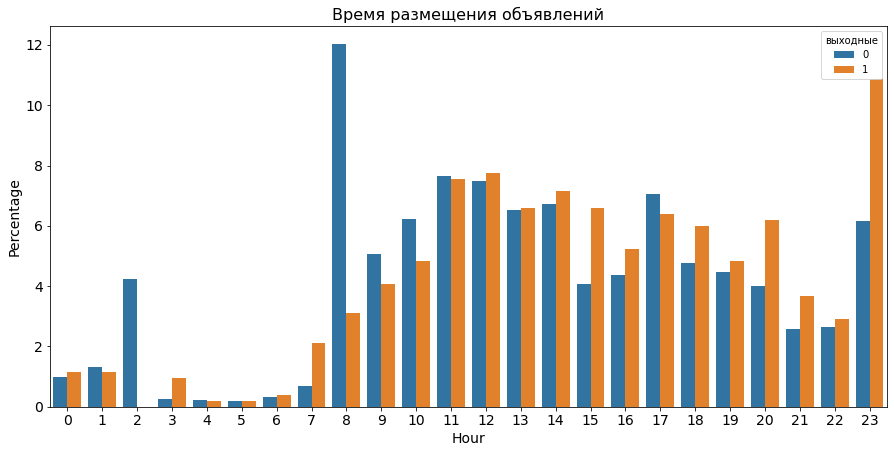

In [36]:
df['Час'] = df['Время_разм'].str[-5:-3].astype('int64')
df['день_недели'] = df['Дата'].apply(lambda x: x.dayofweek)
df['выходные'] = df['день_недели'].apply(lambda x: 1 if x >= 5 else 0)

norm_hours = (df.groupby(['выходные'])['Час']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('Час'))

plt.figure(figsize=(15, 7))
ax = sns.barplot(x="Час", y="percentage", hue="выходные", data=norm_hours)

plt.title('Hour-Weekends', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

plt.title('Время размещения объявлений', fontsize=16);

- Есть смысл заходить с утра просматривать объявления.

- Возможно 8 часовые объявления, это люди которые стремятся продать быстрее. Т к с утра уже обновляют свои объявления.
- В 2 ночи возможно размещают объявления компании, т к по выходным нет размещений. Компании возможно работают в другом регионе к примеру т к час довольно поздний для размещений. 

<a id="sec6"></a>
### [6. Финальная чистка выбросов, для улучшения модели.](#sec6)

In [37]:
df.drop(['Дата'], axis=1, inplace=True)

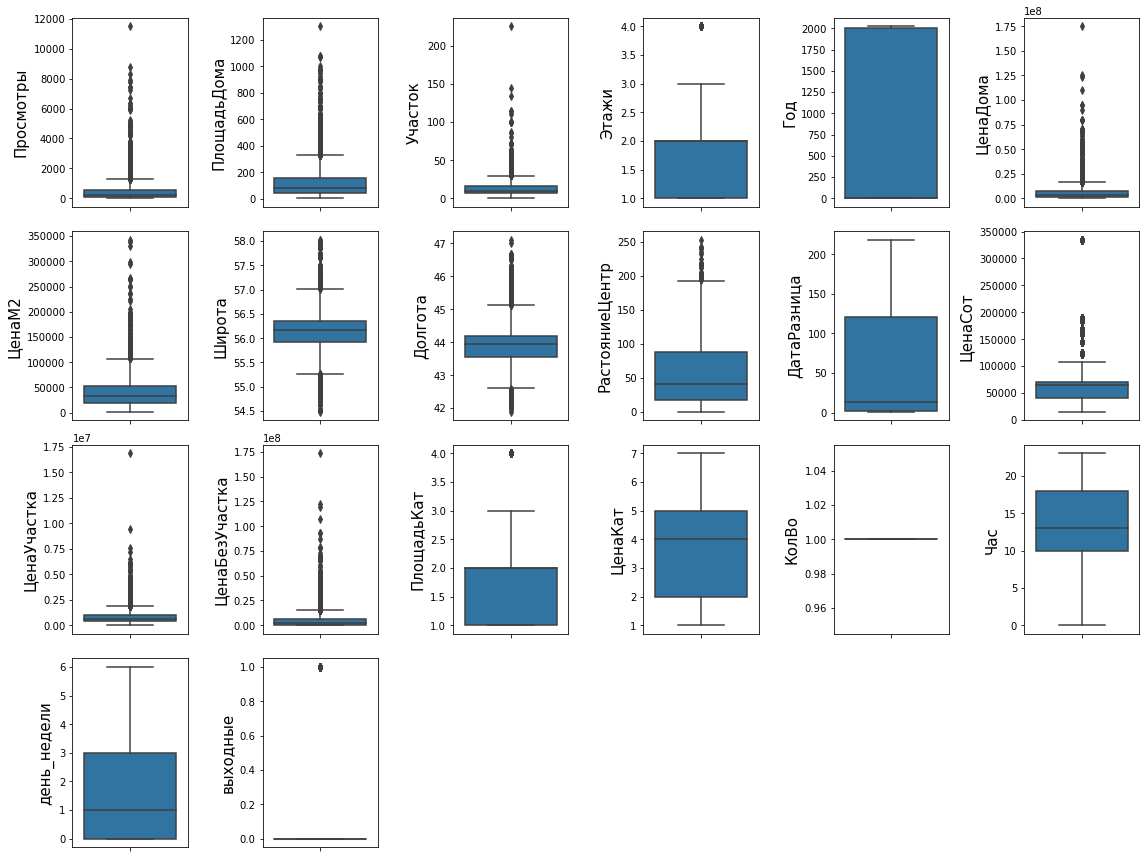

In [38]:
df_num = df.select_dtypes(exclude='object')

fig = plt.figure(figsize=(16,12))
for index, feature in enumerate(df_num):
    plt.subplot(4,6,index+1)
    sns.boxplot(y=feature, data=df_num)
    plt.ylabel('{}'.format(feature), size=15, labelpad=5) 
fig.tight_layout(pad=1.0)

df = df.drop(index=df[df['Просмотры']>10_000].index).reset_index(drop=True)
df = df.drop(index=df[df['ПлощадьДома']>1_200].index).reset_index(drop=True)
df = df.drop(index=df[df['Участок']>120].index).reset_index(drop=True)
df = df.drop(index=df[df['Этажи']>3].index).reset_index(drop=True)
df = df.drop(index=df[(df['Год']<1875) & (df['Год']>0)].index).reset_index(drop=True)
df = df.drop(index=df[df['ЦенаДома']>100_000_000].index).reset_index(drop=True)
df = df.drop(index=df[df['ЦенаУчастка']>8_000_000].index).reset_index(drop=True)

In [39]:
len(df)

4916

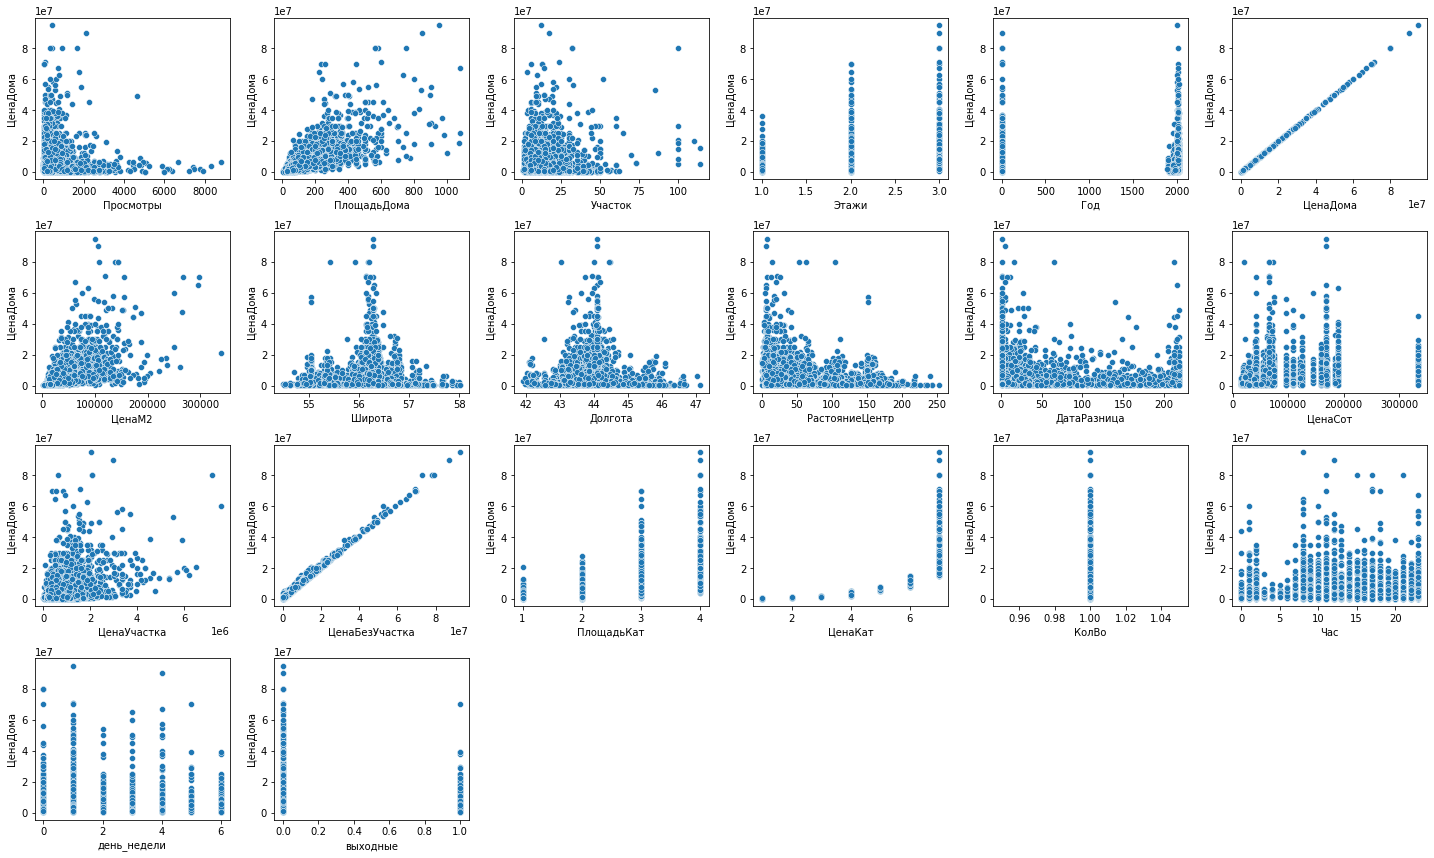

In [40]:
df_num = df.select_dtypes(exclude='object')

fig = plt.figure(figsize=(20,12))
for index in range(len(df_num.columns)):
    plt.subplot(4,6,index+1)
    sns.scatterplot(x=df_num.iloc[:,index], y='ЦенаДома', data=df)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
fig.tight_layout(pad=1.0)

df = df.drop(index=df[(df['ПлощадьДома']>600) & (df['ЦенаДома']<100_000)].index).reset_index(drop=True)
df = df.drop(index=df[df['Участок']>80].index).reset_index(drop=True)
df = df.drop(index=df[(df['Год']<1975) & (df['ЦенаДома']>15_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[df['ЦенаМ2']>300_000].index).reset_index(drop=True)
df = df.drop(index=df[(df['Широта']<55.5) & (df['ЦенаДома']>15_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[df['ЦенаУчастка']>4_000_000].index).reset_index(drop=True)

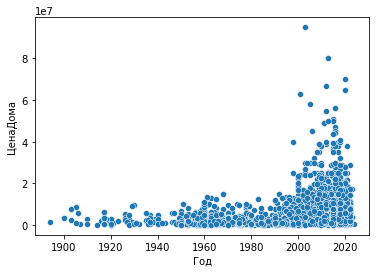

In [42]:
sns.scatterplot(data=df[df['Год']!=0] , x='Год', y = 'ЦенаДома');

In [43]:
len(df)

4738

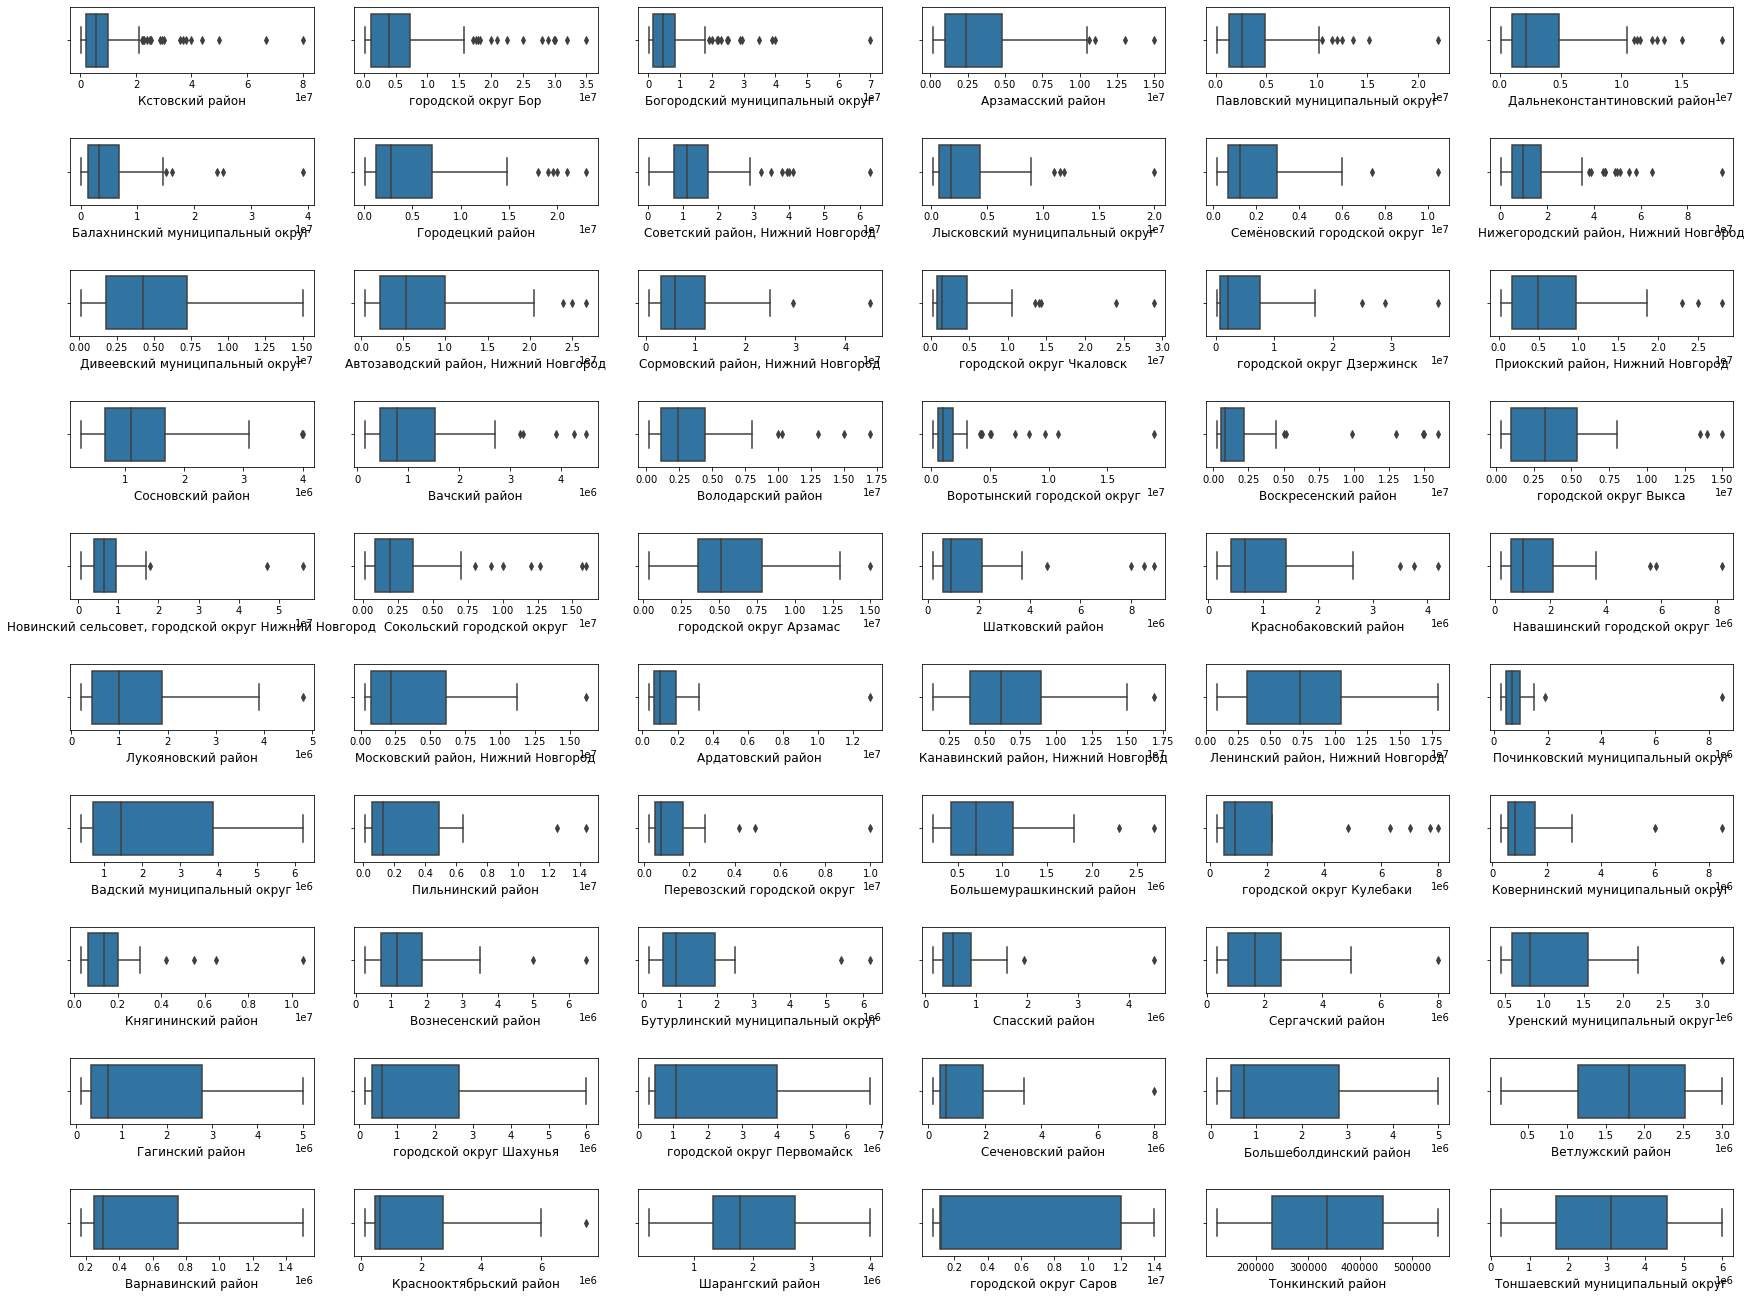

In [44]:
df['КолВо']=1
district_cat = df.groupby(['Районы', 'ЦенаДома'])['КолВо'].sum()
district_cat = district_cat.reset_index()
lst = df['Районы'].value_counts().index
fig = plt.figure(figsize=(24,20))
for index, feature in enumerate(lst):
    diagram = district_cat[district_cat['Районы']==f'{feature}']
    plt.subplot(11,6,index+1)
    sns.boxplot(data =diagram,  x ='ЦенаДома')
    plt.xlabel('{}'.format(feature), size=12, labelpad=5) 
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
fig.tight_layout(pad=3.0)
plt.show();
# Удаляю максимальные выбросы по районам
df = df.drop(index=df[(df['Районы']=='Кстовский район') & (df['ЦенаДома']>22_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Бор') & (df['ЦенаДома']>18_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Богородский муниципальный округ') & (df['ЦенаДома']>25_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Арзамасский район') & (df['ЦенаДома']>11_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Павловский муниципальный округ') & (df['ЦенаДома']>10_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Городецкий район') & (df['ЦенаДома']>17000000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Дальнеконстантиновский район') & (df['ЦенаДома']>7_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Балахнинский муниципальный округ') & (df['ЦенаДома']>17_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Советский район, Нижний Новгород') & (df['ЦенаДома']>40_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Нижегородский район, Нижний Новгород') & (df['ЦенаДома']>50_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Сормовский район, Нижний Новгород') & (df['ЦенаДома']>40_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Лысковский муниципальный округ') & (df['ЦенаДома']>15_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Семёновский городской округ') & (df['ЦенаДома']>8_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Автозаводский район, Нижний Новгород') & (df['ЦенаДома']>25_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Дивеевский муниципальный округ') & (df['ЦенаДома']>15_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Дзержинск') & (df['ЦенаДома']>30_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Приокский район, Нижний Новгород') & (df['ЦенаДома']>40_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Чкаловск') & (df['ЦенаДома']>12_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Сосновский район') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Вачский район') & (df['ЦенаДома']>3_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Володарский район') & (df['ЦенаДома']>10_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Воротынский городской округ') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Новинский сельсовет, городской округ Нижний Новгород') & (df['ЦенаДома']>30_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Выкса') & (df['ЦенаДома']>10_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Воскресенский район') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Сокольский городской округ') & (df['ЦенаДома']>7_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Арзамас') & (df['ЦенаДома']>12_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Шатковский район') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Краснобаковский район') & (df['ЦенаДома']>3_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Навашинский городской округ') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Лукояновский район') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Московский район, Нижний Новгород') & (df['ЦенаДома']>12_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Канавинский район, Нижний Новгород') & (df['ЦенаДома']>20_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Ардатовский район') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Ленинский район, Нижний Новгород') & (df['ЦенаДома']>20_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Починковский муниципальный округ') & (df['ЦенаДома']>2_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Ковернинский муниципальный округ') & (df['ЦенаДома']>7_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Пильнинский район') & (df['ЦенаДома']>7_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Перевозский городской округ') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Большемурашкинский район') & (df['ЦенаДома']>2_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Кулебаки') & (df['ЦенаДома']>6_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Бутурлинский муниципальный округ') & (df['ЦенаДома']>3_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Княгининский район') & (df['ЦенаДома']>2_500_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Вознесенский район') & (df['ЦенаДома']>4_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Спасский район') & (df['ЦенаДома']>2_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='городской округ Шахунья') & (df['ЦенаДома']>2_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Сергачский район') & (df['ЦенаДома']>6_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Уренский муниципальный округ') & (df['ЦенаДома']>3_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Сеченовский район') & (df['ЦенаДома']>6_000_000)].index).reset_index(drop=True)
df = df.drop(index=df[(df['Районы']=='Краснооктябрьский район') & (df['ЦенаДома']>1_000_000)].index).reset_index(drop=True)

In [45]:
len(df)

4525

In [46]:
df.to_csv('df5_cian_house.csv', index=False)

In [4]:
df = pd.read_csv('df5_cian_house.csv')

##### В основном видно, что есть спрос на дома поближе к центру, со средними ценами.

In [5]:
df.groupby(['Районы', 'КатегорииНаселения', 'ЦенаКат', 'РастояниеЦентр'])['Просмотры'].sum().sort_values(ascending=False)[:20]

Районы                                                КатегорииНаселения    ЦенаКат  РастояниеЦентр
Сормовский район, Нижний Новгород                     1) 110-300 тыс. чел.  4        15.6              23074
Приокский район, Нижний Новгород                      2) 50-110 тыс. чел.   2        9.8               12714
Кстовский район                                       1) 110-300 тыс. чел.  4        23.1              11800
Новинский сельсовет, городской округ Нижний Новгород  5) 0-15 тыс. чел.     4        16.3              10167
Нижегородский район, Нижний Новгород                  1) 110-300 тыс. чел.  5        17.6               9700
Кстовский район                                       1) 110-300 тыс. чел.  4        40.1               8726
Московский район, Нижний Новгород                     1) 110-300 тыс. чел.  4        8.9                8315
Кстовский район                                       1) 110-300 тыс. чел.  4        29.6               8195
Ленинский район, Нижний Новг

<a id="sec7"></a>
### [7. Трансформация целевого признака.](#sec7)

- Мы видим, что распределение целевого признака ассиметрично

- Я делаю логарифмирование целевого признака, чтобы получить нормальное распределение 

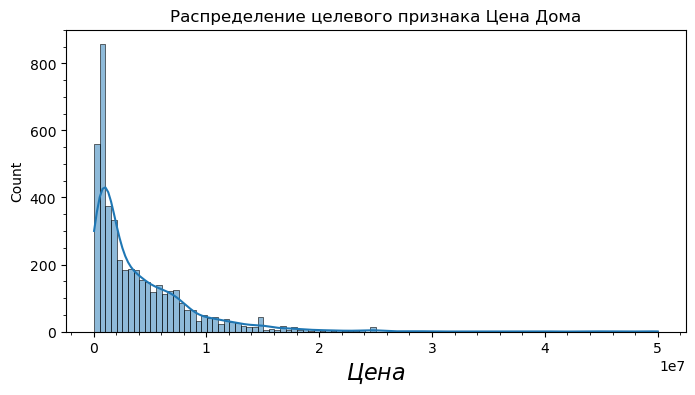

In [6]:
plt.figure(figsize=(8,4), dpi=100)
sns.histplot(data=df, kde=True, x='ЦенаДома', bins=100);
plt.minorticks_on()
plt.xlabel(r'$Цена$', fontsize=16);
plt.title('Распределение целевого признака Цена Дома', fontsize=12);

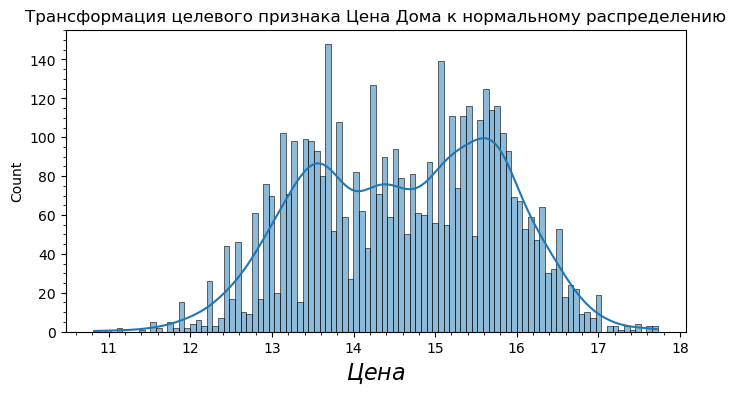

In [7]:
plt.figure(figsize=(8,4), dpi=100)
dist = sns.histplot(np.log(df['ЦенаДома']), kde=True, bins=100)
plt.minorticks_on()
plt.xlabel(r'$Цена$', fontsize=16);
plt.title('Трансформация целевого признака Цена Дома к нормальному распределению', fontsize=12);

In [8]:
df["ЦенаДома"] = np.log(df['ЦенаДома'])

<a id="sec8"></a>
### [8. Feature selection.](#sec8)

- Объединение признаков.
- Основные признаки дома объединим в категориальном значении, плюс добавим два признака площадь и растояние в категориальном значении.
- Получим признак оценка дома, который будет оценивать дом в бальной системе.

##### Признак оценка дома

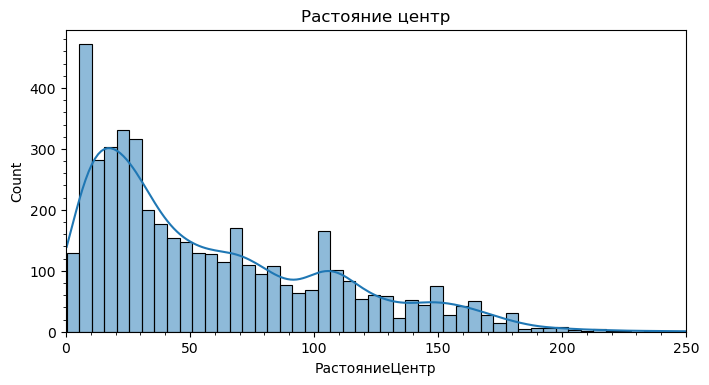

In [9]:
plt.figure(figsize=(8,4), dpi=100)
sns.histplot(data=df, kde=True, x='РастояниеЦентр', bins=50);
plt.xlim(0, 250)

plt.minorticks_on()
plt.title('Растояние центр', fontsize=12);

df['РастояниеКат'] = pd.cut(df['РастояниеЦентр'],
                               bins=[0., 10, 30, 70, 105, 150, np.inf],
                               labels=[6, 5, 4, 3, 2, 1]).astype('int64')

df['Санузел']=df['Санузел'].replace('нет','Санузел в доме')
df['Санузел']=df['Санузел'].replace({'Санузел на улице':0, 'Санузел в доме':1})

df[['Газ','Электричество', 'Отопление', 'Канализация', 'Водоснабжение', 'Баня', 'Гараж', 'Охрана','Бассейн', 
    'Подвал']] = df[['Газ', 'Электричество', 'Отопление', 'Канализация', 'Водоснабжение', 'Баня', 'Гараж', 'Охрана', 
                     'Бассейн', 'Подвал']].replace({'нет':'0', 'есть':'1', 'Подвал':'1', 'Неизвестно':'0'}).astype('int64')

df['Оценка'] = df['Газ']+df['Электричество']+df['Отопление']+df['Канализация']+df['Водоснабжение']+df['Баня']+df[
    'Гараж']+df['Охрана']+df['Бассейн']+df['Подвал']+df['Санузел']+df['ПлощадьКат']+df['РастояниеКат']

- Земля промышленного назначения удаляю, т к очень низкая цена для данной категории по медиане.

In [10]:
print(df.groupby(['СтатусУчастка'])['ЦенаСот'].median())
df = df.drop(index=df[df['СтатусУчастка']=='Земля промышленного назначения'].index).reset_index(drop=True)
df['СтатусУчастка']=df['СтатусУчастка'].replace({'Неизвестно':0, 'Фермерское хозяйство':0, 'Садоводство':1,
                                                 'Личное подсобное хозяйство':1, 
                                                 'Индивидуальное жилищное строительство':2})

СтатусУчастка
Земля промышленного назначения           28652.0
Индивидуальное жилищное строительство    60822.0
Личное подсобное хозяйство               41800.0
Неизвестно                               64938.0
Садоводство                              64938.0
Фермерское хозяйство                     42941.0
Name: ЦенаСот, dtype: float64


##### Приблизительный процент продаж у воды

Удаляю дальше, т к этот признак не дает результата.

In [11]:
round(df['ВодныеПространства'].value_counts(normalize=True),4)*100

Нет      79.31
Река     12.30
Озеро     7.32
Море      1.06
Name: ВодныеПространства, dtype: float64

In [12]:
df["КатегорииНаселения"] = df["КатегорииНаселения"].astype('category')
df["КатегорииНаселения"] = df["КатегорииНаселения"].cat.codes

Слишком много наименований признака, особенно которые дают небольшой процент, не дают особый результат. Лучше их объединить с другими по возможности для большего процента в группе признака.

In [13]:
df['ТипМестности']=df['ТипМестности'].replace({'Городское поселение':'Неизвестно', 
                                               'Поселок городского типа':'Неизвестно', 'Коттеджный поселок':'Неизвестно',
                                              'Районное поселение':'Поселок', 'Сельское поселение':'Поселок',
                                              })

In [14]:
df['ТипДома']=df['ТипДома'].replace({'Керамический кирпич':'Кирпичный', 'Монолитно-кирпичный':'Кирпичный', 
                                     'Брус':'Деревянный', 'Индивидуальный проект':'Неизвестно', 
                                    'Газосиликатный блок':'Блочный', 'Газобетонный блок':'Блочный', 
                                    'Пенобетонный блок':'Блочный', 'Щитовой':'Каркасный', 
                                     'Панельный':'Неизвестно', 'Бревенчатый':'Деревянный'})

Перевожу в ранговые значения признаки.

In [15]:
df['ТипПродажи']=df['ТипПродажи'].replace({'Днп':0,'Снт':0,'Дом':1,'Коттедж':2,'Усадьба':3,'Купеческий':3,'Поместье':3})

In [16]:
df['Тариф']=df['Тариф'].replace({'Бесплатное':0, 'Платное':1, 'Премиум':2, 'Топ':3})

In [17]:
df['Ремонт']=df['Ремонт'].replace({'Неизвестно':0, 'Без ремонта':0, 'Косметический':1, 'Евроремонт':2, 'Дизайнерский':3})

In [18]:
df["КоличествоСпален"]=df['КоличествоСпален'].replace('Неизвестно',0)
df["КоличествоСпален"]=df['КоличествоСпален'].astype('int64')

Удаляю, что уже использовано для новых признаков или дублирует признаки.

In [19]:
df.drop(['Баня', 'Гараж', 'Бассейн', 'Охрана', 'Газ','Электричество', 'Отопление', 'Канализация',
        'Водоснабжение', 'Подвал', 'Санузел'], axis=1, inplace=True)

In [20]:
df.drop(['ЦенаБезУчастка', 'КолВо', 'ЦенаСот', 'ЦенаУчастка', 'ПлощадьКат', 'ЦенаКат', 'ЦенаМ2', 
         'ВодныеПространства','Час', 'РастояниеКат', 'выходные', 'Время_разм', 'Описание', 
         'день_недели'], axis=1, inplace=True)

Создаю фиктивные признаки, для оставшихся признаков.

In [21]:
df = pd.get_dummies(df, columns=[ 'Районы', 'ТипДома', 'ТипМестности'])

### Удаление признаков, которые показали, что не важны для модели.

In [22]:
df.drop(['Районы_Городецкий район', 'Районы_Навашинский городской округ','Районы_Тоншаевский муниципальный округ', 
         'Районы_Тонкинский район','Районы_Большемурашкинский район', 'Районы_Большеболдинский район',
         'Районы_Вадский муниципальный округ', 'Районы_Княгининский район','Тариф', 
         'Районы_Балахнинский муниципальный округ','Районы_Воскресенский район', 'Районы_Воротынский городской округ',
         'Районы_Краснооктябрьский район', 'Районы_городской округ Дзержинск','Районы_Приокский район, Нижний Новгород',
         'Районы_Дальнеконстантиновский район', 'Районы_Вачский район','Районы_Лысковский муниципальный округ',
         'Районы_Семёновский городской округ', 'Районы_городской округ Кулебаки','Районы_Шарангский район', 
         'Районы_городской округ Выкса','Районы_Ардатовский район', 'ТипДома_Каркасный',
         'Районы_Бутурлинский муниципальный округ','Районы_городской округ Первомайск', 'Районы_городской округ Саров',
         'Районы_Вознесенский район','Районы_Новинский сельсовет, городской округ Нижний Новгород',
         'ТипМестности_Микрорайон', 'Районы_Богородский муниципальный округ','Районы_Павловский муниципальный округ', 
         'ТипМестности_Село','ТипДома_Монолитный', 'Районы_Володарский район','Районы_Перевозский городской округ',
         'Районы_Уренский муниципальный округ', 'Районы_Сергачский район','Районы_Канавинский район, Нижний Новгород',
         'Районы_Московский район, Нижний Новгород', 'Районы_Шатковский район','Районы_Спасский район', 
         'Районы_городской округ Чкаловск','Районы_городской округ Шахунья', 'Районы_Варнавинский район',
         'Районы_Починковский муниципальный округ', 'Районы_Сеченовский район','Районы_Ковернинский муниципальный округ', 
         'Районы_Ветлужский район','Районы_Пильнинский район', 'Районы_Сосновский район'], axis=1, inplace=True)

In [23]:
round(df.transpose(),1)

0       1       2       3     \
Просмотры                                    275.0   207.0  2574.0   551.0   
ПлощадьДома                                   50.0   100.0    30.0   420.0   
Участок                                        6.0    47.0     5.0    10.8   
Этажи                                          1.0     1.0     1.0     3.0   
Год                                            0.0  2013.0     0.0  1992.0   
СтатусУчастка                                  2.0     1.0     1.0     0.0   
КоличествоСпален                               0.0     4.0     2.0     0.0   
Ремонт                                         0.0     0.0     1.0     0.0   
ЦенаДома                                      13.3    14.3    13.4    16.5   
Широта                                        56.6    55.3    56.2    56.2   
Долгота                                       43.4    45.9    43.9    43.8   
КатегорииНаселения                             1.0     4.0     0.0     0.0   
РастояниеЦентр                                50.4   169.3    13.0    19.7   
ТипПродажи                                     1.0     1.0     0.0     1.0   
ДатаРазница                                    1.0   209.0     2.0     1.0   
СостояниеДома                                  0.0     0.0     0.0     1.0   
Оценка                                         8.0     5.0     9.0    14.0   
Районы_Автозаводский район, Нижний Новгород    0.0     0.0     1.0     1.0   
Районы_Арзамасский район                       0.0     0.0     0.0     0.0   
Районы_Гагинский район                         0.0     0.0     0.0     0.0   
Районы_Дивеевский муниципальный округ          0.0     0.0     0.0     0.0   
Районы_Краснобаковский район                   0.0     0.0     0.0     0.0   
Районы_Кстовский район                         0.0     0.0     0.0     0.0   
Районы_Ленинский район, Нижний Новгород        0.0     0.0     0.0     0.0   
Районы_Лукояновский район                      0.0     0.0     0.0     0.0   
Районы_Нижегородский район, Нижний Новгород    0.0     0.0     0.0     0.0   
Районы_Советский район, Нижний Новгород        0.0     0.0     0.0     0.0   
Районы_Сокольский городской округ              0.0     0.0     0.0     0.0   
Районы_Сормовский район, Нижний Новгород       0.0     0.0     0.0     0.0   
Районы_городской округ Арзамас                 0.0     0.0     0.0     0.0   
Районы_городской округ Бор                     0.0     0.0     0.0     0.0   
ТипДома_Блочный                                0.0     0.0     0.0     0.0   
ТипДома_Деревянный                             0.0     0.0     0.0     0.0   
ТипДома_Кирпичный                              1.0     1.0     1.0     1.0   
ТипДома_Неизвестно                             0.0     0.0     0.0     0.0   
ТипМестности_Городской округ                   0.0     0.0     0.0     0.0   
ТипМестности_Деревня                           0.0     0.0     0.0     0.0   
ТипМестности_Муниципальный округ               0.0     0.0     0.0     0.0   
ТипМестности_Неизвестно                        0.0     0.0     1.0     0.0   
ТипМестности_Поселок                           1.0     0.0     0.0     0.0   

                                              4      5       6       7     \
Просмотры                                     99.0  372.0  1472.0  1524.0   
ПлощадьДома                                   81.0   62.0    50.0    30.0   
Участок                                        6.0    9.0    15.0     4.0   
Этажи                                          1.0    2.0     1.0     1.0   
Год                                            0.0    0.0     0.0     0.0   
СтатусУчастка                                  2.0    1.0     2.0     2.0   
КоличествоСпален                               2.0    0.0     1.0     0.0   
Ремонт                                         0.0    0.0     1.0     0.0   
ЦенаДома                                      14.6   14.4    13.5    13.8   
Широта                                        57.5   56.6    56.6    56.2   


<a id="sec9"></a>
### [9. Correlation.](#sec9)

In [24]:
abs(df.corr()['ЦенаДома']).sort_values()

ТипДома_Неизвестно                             0.017857
Районы_городской округ Бор                     0.031975
ТипМестности_Поселок                           0.033223
ТипМестности_Муниципальный округ               0.037737
Районы_Арзамасский район                       0.043741
Просмотры                                      0.046001
Районы_Гагинский район                         0.053776
Районы_Сокольский городской округ              0.054234
Районы_Дивеевский муниципальный округ          0.055800
СтатусУчастка                                  0.060510
Районы_городской округ Арзамас                 0.067512
Широта                                         0.070063
Районы_Ленинский район, Нижний Новгород        0.071275
Районы_Автозаводский район, Нижний Новгород    0.077961
Районы_Лукояновский район                      0.090313
Районы_Краснобаковский район                   0.096835
Районы_Сормовский район, Нижний Новгород       0.114364
ТипМестности_Деревня                           0

##### Проверяю на мультиколлинеарность

In [25]:
df_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
df_corr_nd = df_corr.drop(df_corr[df_corr['Correlation Coefficient'] == 1.0].index)

In [26]:
corr = df_corr_nd['Correlation Coefficient'] > 0.5
df_corr_nd[corr]

Feature 1           Feature 2  Correlation Coefficient
40            ЦенаДома       СостояниеДома                 0.753130
42      РастояниеЦентр  КатегорииНаселения                 0.718307
44              Оценка            ЦенаДома                 0.705233
46            ЦенаДома         ПлощадьДома                 0.672354
48         ПлощадьДома               Этажи                 0.615840
50  ТипДома_Деревянный   ТипДома_Кирпичный                 0.607486
52         ПлощадьДома              Оценка                 0.552014
54      РастояниеЦентр              Оценка                 0.539236
56       СостояниеДома              Оценка                 0.519372
58               Этажи            ЦенаДома                 0.517454

In [27]:
# df.drop(['ТипДома_Деревянный'], axis=1, inplace=True)

In [28]:
df = df.reset_index(drop=True)

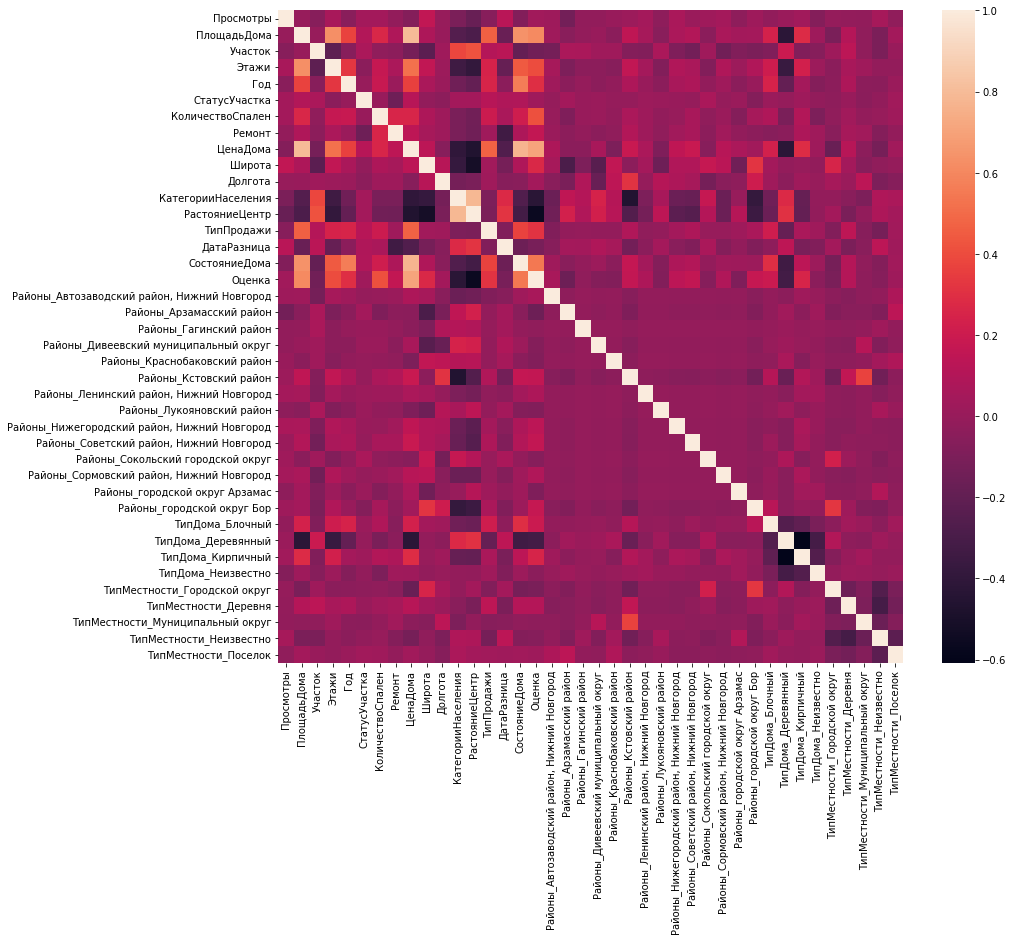

In [29]:
plt.figure(figsize=(14,12))

sns.heatmap(df.corr(method='spearman'), fmt=".1f");

<a id="sec10"></a>
### [10. Modeling.](#sec10)

In [30]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.inspection import permutation_importance
import warnings
import shap

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [31]:
X = df.drop(['ЦенаДома'], axis=1)
y = df['ЦенаДома'].values

In [32]:
# Т к данных не так много, оставлю на оставлю на тест 10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

##### RobustScaler 

RobustScaler — это метод преобразования, который удаляет медиану и масштабирует данные в соответствии с диапазоном квантилей (по умолчанию IQR: Interquartile Range). IQR представляет собой диапазон между 1-м квартилем (25-й квантиль) и 3-м квартилем (75-й квантиль). Он также устойчив к выбросам, что делает его идеальным для данных, в которых слишком много выбросов, которые резко уменьшат количество обучающих данных.

In [33]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [34]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

### Baseline 

In [39]:
def exp(y: np.ndarray) -> np.ndarray:
    """
    Потенционирование (обратное логарифмирование) 
    """
    return np.exp(y) - 1

In [40]:
models = [LinearRegression(), ElasticNet(), KNeighborsRegressor(), SVR(), RandomForestRegressor(), 
          AdaBoostRegressor(), GradientBoostingRegressor(),
         LGBMRegressor()]
scores = dict()

for m in models:
    m.fit(X_train_norm, y_train)
    y_pred = m.predict(X_test_norm)

    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test), exp(y_pred))), 3)}')
#     print(f'MAE: {round(mean_absolute_error(exp(y_test), exp(y_pred)), 3)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(exp(y_test), exp(y_pred)), 3)}%')
    print('-'*30, '\n')
    
models = CatBoostRegressor(verbose=0)
models = models.fit(X_train_norm, y_train)
y_pred = models.predict(X_test_norm)
print('model: CatBoostRegressor()')
print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test), exp(y_pred))), 3)}')
print(f'MAPE: {round(mean_absolute_percentage_error(exp(y_test), exp(y_pred)), 3)}%')
print('-'*30, '\n')

models = XGBRegressor()
models = models.fit(X_train_norm, y_train)
y_pred = models.predict(X_test_norm)
print('model: XGBRegressor()')
print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_test), exp(y_pred))), 3)}')
print(f'MAPE: {round(mean_absolute_percentage_error(exp(y_test), exp(y_pred)), 3)}%')
print('-'*30, '\n')

model: LinearRegression()
RMSE: 2612015.256
MAPE: 0.501%
------------------------------ 

model: ElasticNet()
RMSE: 4014459.618
MAPE: 1.454%
------------------------------ 

model: KNeighborsRegressor()
RMSE: 2158546.726
MAPE: 0.52%
------------------------------ 

model: SVR()
RMSE: 1737273.46
MAPE: 0.425%
------------------------------ 

model: RandomForestRegressor()
RMSE: 1825286.133
MAPE: 0.408%
------------------------------ 

model: AdaBoostRegressor()
RMSE: 2400184.219
MAPE: 0.481%
------------------------------ 

model: GradientBoostingRegressor()
RMSE: 1961173.412
MAPE: 0.432%
------------------------------ 

model: LGBMRegressor()
RMSE: 1741037.41
MAPE: 0.393%
------------------------------ 

model: CatBoostRegressor()
RMSE: 1718225.711
MAPE: 0.387%
------------------------------ 

model: XGBRegressor()
RMSE: 1793195.81
MAPE: 0.402%
------------------------------ 



##### Модели на основе SVR(), CatBoostRegressor(), RandomForestRegressor() считались очень долго по времени. 
- В районе по пол часа обсчет.
- Не стал настраивать до лучших результатов.

### Ensemble Algorithms

### Расмотрим два мощных, популярных и интересныx алгоритма показавших одни из луших результатов на Baseline.

### XGBoost 
Extreme Gradient Boost (XGB) is a boosting algorithm that uses the gradient boosting framework; where gradient descent algorithm is employed to minimize the errors in the sequential model. It improves on the gradient boosting framework with faster execution speed and improved performance.  
<br/>
<img src="https://miro.medium.com/max/1400/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg" width=700/>

##### Для более быстрого обсчета использую RandomizedSearch, для большого количества настроек.

In [37]:
'''
Find out more on the XGBRegressor implementation and parameters at 
https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
'''

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [38]:
%%time

param_lst = {
    'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.4],
    'n_estimators' : [400, 600, 800, 1000, 1200, 1400, 1600, 2000, 2400],
    'max_depth' : [2, 4, 6, 8, 10, 14],
    'min_child_weight' : [2, 4, 6, 8, 10, 12, 14],
    'reg_alpha' : [0.001, 0.01, 0.1, 0.4, 1, 3, 5],
    'reg_lambda' : [0.0001, 0.001, 0.1, 0.15, 0.2, 0.5, 1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5, verbose=1)
       
xgb_search = xgb_reg.fit(X_train_norm, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 26min 32s


In [39]:
best_param

{'reg_lambda': 0.15,
 'reg_alpha': 0.1,
 'n_estimators': 2000,
 'min_child_weight': 6,
 'max_depth': 6,
 'learning_rate': 0.01}

In [40]:
xgb =xgb.fit(X_train_norm, y_train)
y_pred = xgb.predict(X_test_norm)
print('MAE test:', mean_absolute_error(exp(y_test),exp(y_pred)))
print('RMSE test:', np.sqrt(mean_squared_error(exp(y_test),exp(y_pred))))
print('score train :', xgb.score(X_train_norm,y_train))
print('score test :', xgb.score(X_test_norm,y_test))

MAE test: 974406.7486172571
RMSE test: 1723444.594359759
score train : 0.9699176270982495
score test : 0.8639749529803483


### LightGBM
LightBGM is another gradient boosting framework developed by Microsoft that is based on decision tree algorithm, designed to be efficient and distributed. Some of the advantages of implementing LightBGM compared to other boosting frameworks include:
1. Faster training speed and higher efficiency (use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure)
2. Lower memory usage (Replaces continuous values to discrete bins which result in lower memory usage)
3. Better accuracy
4. Support of parallel and GPU learning
5. Capable of handling large-scale data (capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST)

LightGBM splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. This leaf-wise algorithm reduces more loss than the level-wise algorithm, hence resulting in much better accuracy which can rarely be achieved by any of the existing boosting algorithms.  

In [41]:
"""
Learn more avout LightBGM parameters at 
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
"""

lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression')

In [42]:
%%time

param_lst = {
    'max_depth' : [6, 8, 10, 14, 16, 18, 22],
    'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.4],
    'n_estimators' : [800, 1200, 1600, 2000, 2400, 2800, 3000, 3200, 3500, 3800],
    'lambda_l1' : [0.0001, 0.001, 0.01, 0.1, 0.4, 1],
    'lambda_l2' : [0.001, 0.01, 0.1, 0.2, 0.5, 1, 3],
    'feature_fraction' : [0.2, 0.3, 0.4, 0.5, 0.7],
    'min_child_samples' : [1, 2, 4, 6, 8, 10, 12, 14]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5, verbose=1)
       
lightgbm_search = lightgbm.fit(X_train_norm, y_train)

# LightBGM with tuned hyperparameters
best_param = lightgbm_search.best_params_
lgbm = LGBMRegressor(**best_param)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 17min 1s


In [43]:
best_param

{'n_estimators': 2400,
 'min_child_samples': 10,
 'max_depth': 10,
 'learning_rate': 0.01,
 'lambda_l2': 1,
 'lambda_l1': 0.01,
 'feature_fraction': 0.4}

In [44]:
lgbm=lgbm.fit(X_train_norm, y_train)
y_pred = lgbm.predict(X_test_norm)
print('MAE test:', mean_absolute_error(exp(y_test),exp(y_pred)))
print('RMSE test:', np.sqrt(mean_squared_error(exp(y_test),exp(y_pred))))
print('score train :', lgbm.score(X_train_norm,y_train))
print('score test :', lgbm.score(X_test_norm,y_test))

MAE test: 966532.3208074443
RMSE test: 1700736.9601877213
score train : 0.9722971850392317
score test : 0.8667240070246968


##### По времени и результатам, LightGBM показал лучшие. 

- Проверим на GridSearchCV с KFold

In [46]:
lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression')

In [47]:
%%time

parameters_grid = {
    'max_depth' : [9, 10, 11],
    'learning_rate' : [0.01],
    'n_estimators' : [2300, 2400, 2500],
    'lambda_l1' : [0.005, 0.01, 0.02],
    'lambda_l2' : [0.5, 1, 2],
    'feature_fraction' : [0.4, 0.5],
    'min_child_samples' : [9, 10, 11]
}

# model = LGBMRegressor()
cv = KFold(n_splits=5, shuffle=True)

grid_cv = GridSearchCV(estimator = lgbm, param_grid = parameters_grid,
                       scoring='neg_root_mean_squared_error',
                       cv=cv, verbose=1)
grid_cv.fit(X_train_norm, y_train)

best_param = grid_cv.best_params_
lgbm = LGBMRegressor(**best_param)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Wall time: 1h 32min 21s


In [48]:
best_param

{'feature_fraction': 0.4,
 'lambda_l1': 0.01,
 'lambda_l2': 2,
 'learning_rate': 0.01,
 'max_depth': 11,
 'min_child_samples': 9,
 'n_estimators': 2300}

In [49]:
lgbm=lgbm.fit(X_train_norm, y_train)
y_pred = lgbm.predict(X_test_norm)
print('MAE test:', mean_absolute_error(exp(y_test),exp(y_pred)))
print('RMSE test:', np.sqrt(mean_squared_error(exp(y_test),exp(y_pred))))
print('score train :', lgbm.score(X_train_norm,y_train))
print('score test :', lgbm.score(X_test_norm,y_test))

MAE test: 969006.1513027876
RMSE test: 1709461.521294424
score train : 0.9705073314972579
score test : 0.8660907231180797


### Cross validation
- Чтобы избежать переобучения и посмотреть, что происходит на разных этапах обучения модели.

In [50]:
cv = KFold(n_splits=20, shuffle=True, random_state=101)

finish_test_preds = []

mae_predicts = np.empty(20)
rmse_predicts = np.empty(20)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train_norm, y_train)):
    X_train_, X_val = X_train_norm[train_idx], X_train_norm[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = LGBMRegressor(**best_param)
    model.fit(X_train_, y_train_)

    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1

    mae_predicts[idx] = mean_absolute_error(y_val_exp, preds_exp)
    rmse_predicts[idx] = np.sqrt(mean_squared_error(y_val_exp, preds_exp))

    preds_test = model.predict(X_test_norm)
    finish_test_preds.append(preds_test)

    print(
        f"id = {idx}, rmse = {round(rmse_predicts[idx], 3)}, mae = {round(mae_predicts[idx], 3)} \n")

print(np.mean(rmse_predicts))

id = 0, rmse = 2092310.141, mae = 1080409.341 

id = 1, rmse = 2296666.758, mae = 1172370.245 

id = 2, rmse = 1468782.068, mae = 887164.071 

id = 3, rmse = 3181057.043, mae = 1249274.596 

id = 4, rmse = 2350883.371, mae = 1091059.116 

id = 5, rmse = 2612646.555, mae = 1244673.642 

id = 6, rmse = 1989411.105, mae = 1109064.954 

id = 7, rmse = 2185378.523, mae = 1063062.19 

id = 8, rmse = 2721536.374, mae = 1150387.967 

id = 9, rmse = 1908532.084, mae = 1038743.307 

id = 10, rmse = 2069649.423, mae = 1056843.338 

id = 11, rmse = 1966850.817, mae = 1001269.234 

id = 12, rmse = 2316721.878, mae = 1290897.949 

id = 13, rmse = 1753584.87, mae = 938671.931 

id = 14, rmse = 2004256.182, mae = 1042777.166 

id = 15, rmse = 3163906.872, mae = 1320817.365 

id = 16, rmse = 2258730.001, mae = 1186762.246 

id = 17, rmse = 1768411.03, mae = 976338.222 

id = 18, rmse = 1695483.905, mae = 1020051.709 

id = 19, rmse = 2069432.794, mae = 1066708.155 

2193711.589683816


In [51]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)

In [52]:
print(f'MAE: {mean_absolute_error(exp(y_test), exp(test_pred))}')
print(f'RMSE: {np.sqrt(mean_squared_error(exp(y_test), exp(test_pred)))}')

MAE: 961057.5153513207
RMSE: 1717292.342239148


In [53]:
exp(df['ЦенаДома'].mean())

2235160.132874632

Средняя цена дома.

### Permutation_importance

- Дает более релевантную картину с важными признаками, в отличии от большинства встроенных методов.

In [54]:
perm = permutation_importance(model, X_test_norm, y_test, n_repeats=15)

In [55]:
perm_df = pd.DataFrame((perm['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

In [56]:
perm_df[:15]

Score                                  Features
14   0.31297                             СостояниеДома
1   0.129953                               ПлощадьДома
15  0.064046                                    Оценка
11  0.026992                            РастояниеЦентр
2   0.022711                                   Участок
0   0.016386                                 Просмотры
10  0.014389                        КатегорииНаселения
9   0.012307                                   Долгота
8   0.010839                                    Широта
12  0.010285                                ТипПродажи
5   0.009253                             СтатусУчастка
13   0.00898                               ДатаРазница
4   0.005754                                       Год
3   0.003438                                     Этажи
27  0.002375  Районы_Сормовский район, Нижний Новгород

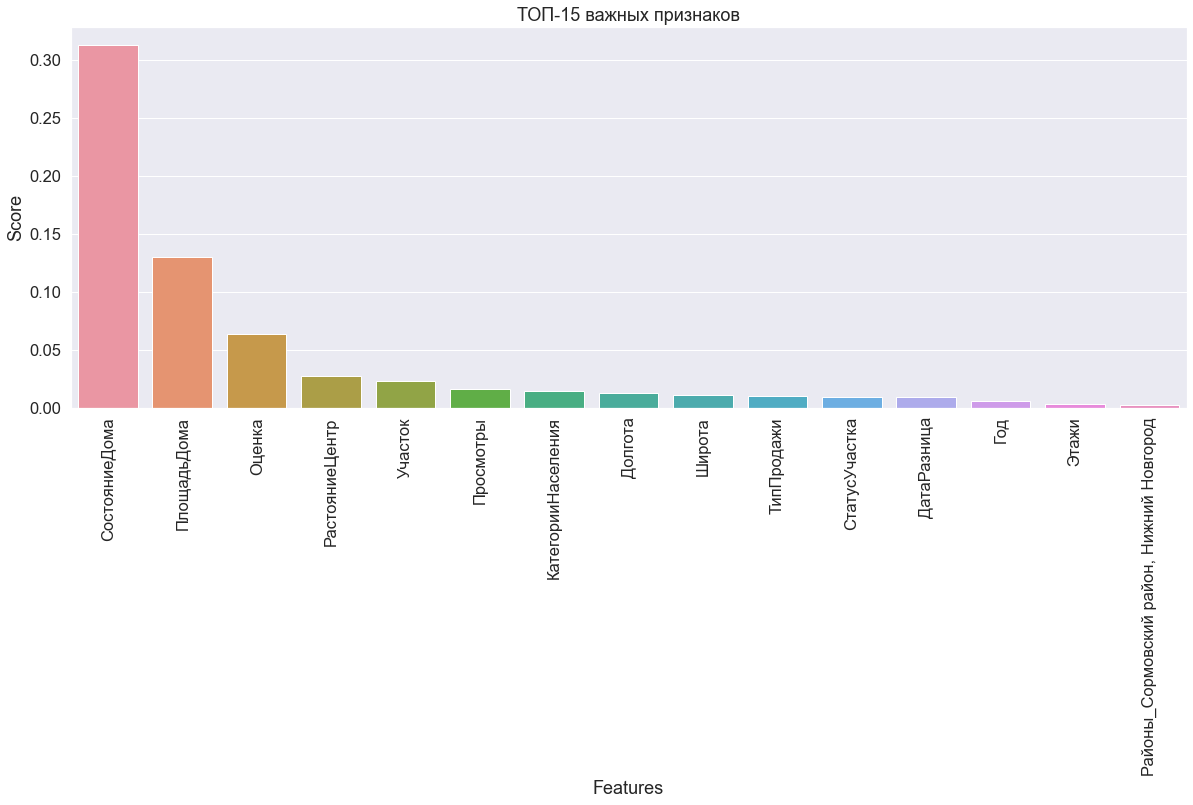

In [57]:
plt.figure(figsize=(20, 7))

sns.set(font_scale=1.5)
sns.barplot(x="Features", y="Score", data=perm_df[:15])
plt.title('ТОП-15 важных признаков')

plt.xticks(rotation=90)
plt.show();

##### SHAP

- используется значения Шепли, есть возможность наглядно посмотреть, как значения каждого важного признака влияет на target

In [58]:
warnings.filterwarnings(action='ignore', category=UserWarning)

In [59]:
X_train_summary = shap.kmeans(X_train_norm, 2)

explainer = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = explainer.shap_values(X_test_norm)

  0%|          | 0/452 [00:00<?, ?it/s]

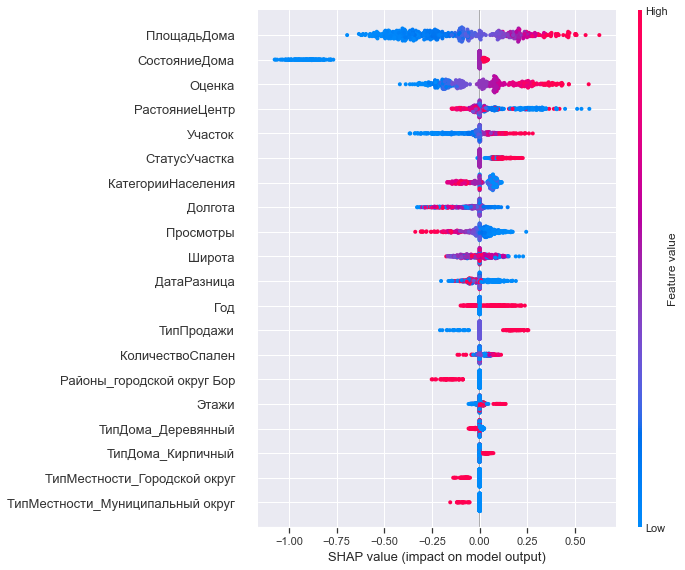

In [60]:
shap.summary_plot(shap_values, X_test)

- Мы видим, что топовый признак Состояние Дома уходит сильно в минусовые значения. Это отражает ветхие дома в этом признаке, и дома без годов.
- Площадь дома, оценка более ключевые признаки, которые хорошо объясняют данные.

### Target feature

In [61]:
df['ЦенаДома']= exp(df['ЦенаДома'])

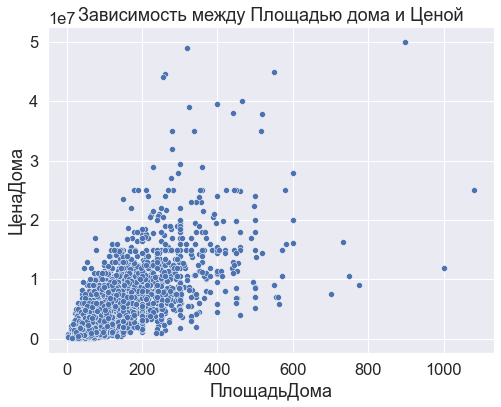

In [62]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x='ПлощадьДома', y='ЦенаДома', data=df)
plt.title('Зависимость между Площадью дома и Ценой')
plt.show()

<a id="sec11"></a>
### [11. Выводы:](#sec11)

- Максимум достигнут при данных, которые есть.
- Не хватает данных. Например заполнить года. 50% не хватает данных. А это может быть одним из ключевых признаков. На нем построен признак состояние дома.
- Проработать признак состояние дома дальше.
- Также признак оценка неплохо себя показывает. Можно проработать заполнение признаков, которые его составляют.
- Также возможно доработать другие признаки, которые не раскрылись.

### Что было проверено

- Сокращал диапозон цен, до приближенного к нормальному распределению. Эффект RMSE 700 тыс. руб. при ценах до 6 млн. руб. Эффект получается похуже.
- Посчитал только с заполненными годами. Т к этот признак может играть свою роль важную. Результаты так себе. Конечно здесь данные вырваные получаются. Становится очень мало данных, которые гораздо меньшее отражают.
- Посчитал как есть, без логорифмирования. По сути логорифмирование дает чуть лучше результат. Ну и оно подходит больше для простых линейных моделей и метрических типо LinearRegression,  KNeighborsRegressor. Здесь результат вырастает в разы даже на Baseline.

### Косяки сайта Циан

- Есть дата публикации и дата обновления объявления. Мы видим дату публикации которая, является по сути датой обновления объявления. При нажатии на дату, мы уже видим данные по дате когда именно опубликовано объявление. Но при фильтрации объявлений к примеру за последний месяц, мы можем встретить объявления очень старые, но которые обновили недавно.Есть объявления которые висят на сайте и по 2, 3 года. **Непонятно пока, как вытащить с сайта именно дату публикации. Это могло поменять результат.** 
- **Цена за квадратный метр не соответствует действительности. В учет не идет участок дома.** В таком случае дома с большими участками земли получаются с очень дорогим квадратным метром.
- Очень много в объявлениях путаницы с м2, сотками и га. **Пользователи сайта, неверно порой заполняют единицы измерения.** Это можно было исправить, указывая рядом, чем отличаются эти метрики.
- Если человек не указывает какие либо параметры, к примеру сколько у него этажей в доме, комнат или прочего, то тот кто ищет по определенным параметрам видит только объявления с указанными параметрами. **Очень много данных содержится в описании объявления. Можно разными способами достать от туда, дополнительно данные.**
- Ветхих домов не мало, по сути участок один продают. Либо недостроев тоже хватает, в стадии строительства.

##### Продолжение следует...(доработка проекта идет дальше)

### Содержание
1. [Обработка сырых данных полученных парсингом.](#sec1)
    * [1.2 Проверка признаков](#sec1.2) 
2. [Feature engineering](#sec2)  
    * [2.1 Работа с адресом и получение долготы и широты](#sec2.1)
    * [2.2 Данные из википедии по количеству населения в районах.](#sec2.2)
    * [2.3 Новые признаки.](#sec2.3)
    * [2.4 Обработка данных по участкам (выкачанных отдельно с сайта).](#sec2.4)
3. [Обработка выбросов в данных](#sec3)
    * [3.2 Удаление данных узкой категории, которые вносят выбросы](#sec3.1)
4. [Обработка пропущенных значений](#sec4)
5. [EDA - Разведочный анализ данных](#sec5)
    * [5.2 Data visualization](#sec5.2)
    * [5.3 Ключевой признак: Состояние дома.](#sec5.3)
    * [5.4 Time data.](#sec5.4)
6. [Финальная чистка выбросов, для улучшения модели.](#sec6)
7. [Трансформация целевого признака.](#sec7)
8. [Feature selection.](#sec8)
9. [Correlation.](#sec9)
10. [Modeling.](#sec10)
11. [Выводы:](#sec11)